In [65]:
# regular imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from env import get_db_url
import env
import seaborn as sns
import scipy.stats as stats
import explore
from itertools import combinations

# local libraries
import wrangle_zillow

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

import warnings
warnings.filterwarnings("ignore")

# Wrangling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
alpha = 0.05

In [2]:
df=wrangle_zillow.wrangle_zillow()

Using cached data


In [3]:
df.head()

id  parcelid  basementsqft             bathroom              bedroom  \
0  1727539  14297519           NaN                 3.50                 4.00   
1  1387261  17052889           NaN                 1.00                 2.00   
2    11677  14186244           NaN                 2.00                 3.00   
3  2288172  12177905           NaN                 3.00                 4.00   
4  1970746  10887214           NaN                 3.00                 3.00   

             condition    calculatedbathnbr  decktypeid  \
0                  NaN                 3.50         NaN   
1                  NaN                 1.00         NaN   
2                  NaN                 2.00         NaN   
3                 8.00                 3.00         NaN   
4                 8.00                 3.00         NaN   

   finishedfloor1squarefeet          square_feet  ...   censustractandblock  \
0                       NaN             3,100.00  ... 60,590,630,072,012.00   
1                  1,465.00             1,465.00  ... 61,110,010,023,006.00   
2                       NaN             1,243.00  ... 60,590,218,022,012.00   
3                       NaN             2,376.00  ... 60,373,001,001,006.00   
4                       NaN             1,312.00  ... 60,371,236,012,000.00   

              logerror  transactiondate        propertylandusedesc  \
0                 0.03       2017-01-01  Single Family Residential   
1                 0.06       2017-01-01  Single Family Residential   
2                 0.01       2017-01-01  Single Family Residential   
3                -0.10       2017-01-01  Single Family Residential   
4                 0.01       2017-01-01                Condominium   

   airconditioningdesc  architecturalstyledesc  buildingclassdesc  \
0                  NaN                     NaN                NaN   
1                  NaN                     NaN                NaN   
2                  NaN                     NaN                NaN   
3                  NaN                     NaN                NaN   
4              Central                     NaN                NaN   

   heatingorsystemdesc  storydesc  typeconstructiondesc  
0                  NaN        NaN                   NaN  
1                  NaN        NaN                   NaN  
2                  NaN        NaN                   NaN  
3              Central        NaN                   NaN  
4              Central        NaN                   NaN  

[5 rows x 61 columns]

In [4]:
df.latitude = df.latitude / 1_000_000
df.longitude = df.longitude / 1_000_000

In [5]:
df = wrangle_zillow.handle_missing_zillow_values(df)

For threshold based dropping: 
(52463, 61)  original shape
(52463, 59)  shape after dropping columns with prop required rows below theshold
(52463, 59)  shape after dropping rows with prop required columns below threshold


In [6]:
df.shape

(50906, 53)

In [7]:
df.columns

Index(['id', 'parcelid', 'basementsqft', 'bathroom', 'bedroom', 'condition',
       'decktypeid', 'square_feet', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garage', 'garagetotalsqft', 'hashottuborspa', 'latitude', 'longitude',
       'lot_size', 'pools', 'poolsizesum', 'pooltypeid10', 'pooltypeid2',
       'pooltypeid7', 'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'zip',
       'roomcnt', 'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17',
       'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'fireplaceflag',
       'structuretaxvaluedollarcnt', 'tax_value', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyflag',
       'taxdelinquencyyear', 'censustractandblock', 'logerror',
       'transactiondate', 'propertylandusedesc', 'airconditioningdesc',
       'architecturalstyledesc', 'heatingorsystemdesc', 'storydesc',
       'typeconstructiondesc', 'county'],
      dtype='o

- Ask at least 5 questions about the data, keeping in mind that your target variable is `logerror`. e.g. Is `logerror` significantly different for properties in LA County vs Orange County vs Ventura County?

### Questions

1. Is `logerror` significantly different for properties in LA County vs Orange County vs Ventura County?
2. What is the distribution of each of the variables?
3. Is there a relationship between `logerror` and finished square footage of the property in each county? (small, medium, large, extra large)
4. Is there a relationship between `logerror` and lot size square footage in each county? (small, medium, large, extra large)
5. Controlling for property square footage, what is the relationship between `logerror` and age of the home?

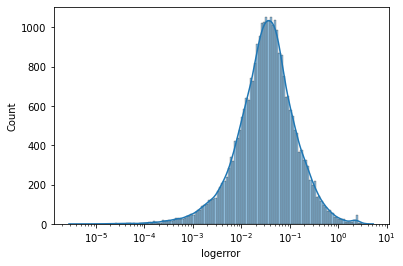

In [8]:
ax = sns.histplot(data=df, x="logerror", kde=True, log_scale=True)

### Split Data

In [9]:
train, validate, test = wrangle_zillow.split_data(df)

Data split as follows: Train 56.00%, Validate 24.00%, Test 20.00%


In [10]:
train.shape, validate.shape, test.shape

((28506, 53), (12218, 53), (10182, 53))

In [11]:
train.roomcnt.value_counts()

 0.00    20463
 6.00     2239
 7.00     1996
 8.00     1553
 5.00     1020
 9.00      638
 4.00      285
10.00      188
11.00       54
 3.00       39
12.00       15
 2.00        6
13.00        5
14.00        4
 1.00        1
Name: roomcnt, dtype: int64

In [12]:
train['age'] = 2017 - train.yearbuilt
train['bathroom_bin'] = pd.qcut(train.bathroom, 2, labels=["less_than_2","2_or_more"])
train['bedroom_bin'] = pd.qcut(train.bedroom, 3, labels = ["less_than_3","3","4_or_more"])
train['age_bin']=pd.qcut(train.age, 2, labels=['young','old'])
train['has_garage'] = train.garage>0
train['home_size'] = pd.qcut(train.square_feet,3, labels=['small','medium','large'])
train['living_space'] = train.square_feet - (40*train.bathroom+200*train.bedroom)
train['tax_rate'] = train.taxamount/train.tax_value
train['acres'] = train.lot_size/43560
train['structure_dollar_per_sqft'] = train.tax_value/train.square_feet
train['land_dollar_per_sqft'] = train.landtaxvaluedollarcnt / train.square_feet
train['bed_bath_ratio'] = np.select([train.bathroom>0,train.bathroom==0],[train.bedroom/train.bathroom,0])
train['is_la'] = train.county == 'Los Angeles County'
train['abs_logerror'] = abs(train.logerror)

In [13]:
validate['age'] = 2017 - validate.yearbuilt
validate['bathroom_bin'] = pd.qcut(validate.bathroom, 2, labels=["less_than_2","2_or_more"])
validate['bedroom_bin'] = pd.qcut(validate.bedroom, 3, labels = ["less_than_3","3","4_or_more"])
validate['age_bin']=pd.qcut(validate.age, 2, labels=['young','old'])
validate['has_garage'] = validate.garage>0
validate['home_size'] = pd.qcut(validate.square_feet,3, labels=['small','medium','large'])
validate['living_space'] = validate.square_feet - (40*validate.bathroom+200*validate.bedroom)
validate['tax_rate'] = validate.taxamount/validate.tax_value
validate['acres'] = validate.lot_size/43560
validate['structure_dollar_per_sqft'] = validate.tax_value/validate.square_feet
validate['land_dollar_per_sqft'] = validate.landtaxvaluedollarcnt / validate.square_feet
validate['bed_bath_ratio'] = np.select([validate.bathroom>0,validate.bathroom==0],[validate.bedroom/validate.bathroom,0])
validate['is_la'] = validate.county == 'Los Angeles County'
validate['abs_logerror'] = abs(validate.logerror)

In [14]:
test['age'] = 2017 - test.yearbuilt
test['bathroom_bin'] = pd.qcut(test.bathroom, 2, labels=["less_than_2","2_or_more"])
test['bedroom_bin'] = pd.qcut(test.bedroom, 3, labels = ["less_than_3","3","4_or_more"])
test['age_bin']=pd.qcut(test.age, 2, labels=['young','old'])
test['has_garage'] = test.garage>0
test['home_size'] = pd.qcut(test.square_feet,3, labels=['small','medium','large'])
test['living_space'] = test.square_feet - (40*test.bathroom+200*test.bedroom)
test['tax_rate'] = test.taxamount/test.tax_value
test['acres'] = test.lot_size/43560
test['structure_dollar_per_sqft'] = test.tax_value/test.square_feet
test['land_dollar_per_sqft'] = test.landtaxvaluedollarcnt / test.square_feet
test['bed_bath_ratio'] = np.select([test.bathroom>0,test.bathroom==0],[test.bedroom/test.bathroom,0])
test['is_la'] = test.county == 'Los Angeles County'
test['abs_logerror'] = abs(test.logerror)

In [15]:
# No values show any significant correlation with logerror right off the bat
train.corrwith(train.logerror).sort_values(ascending=False)

logerror                                     1.00
abs_logerror                                 0.44
square_feet                                  0.04
bedroom                                      0.04
living_space                                 0.03
bathroom                                     0.03
longitude                                    0.03
fullbathcnt                                  0.03
garagetotalsqft                              0.03
threequarterbathnbr                          0.03
garage                                       0.02
yearbuilt                                    0.02
has_garage                                   0.02
roomcnt                                      0.02
numberofstories                              0.02
parcelid                                     0.01
basementsqft                                 0.01
lot_size                                     0.01
acres                                        0.01
regionidcity                                 0.01


In [16]:
overall_mean = train.logerror.mean()
print(f"Overall mean logerror: {overall_mean}")
for col in train.columns:
    if train[col].nunique()<10:
        for option in train[col].unique():
            if len(train[train[col]==option].logerror)>2:
                t, p = stats.ttest_1samp(train[train[col]==option].logerror, train.logerror.mean())
                if p<alpha:
                    sample_mean = train[train[col]==option].logerror.mean()
                    difference = sample_mean - overall_mean
                    print(f"For {col} - {option} the mean ({sample_mean:.4f}) differs significantly from overall mean by {difference:.4f}, sample size {len(train[train[col]==option].logerror)}")

Overall mean logerror: 0.018113638023293778
For fips - 6037.0 the mean (0.0148) differs significantly from overall mean by -0.0033, sample size 18412
For fips - 6059.0 the mean (0.0280) differs significantly from overall mean by 0.0099, sample size 7668
For fireplacecnt - 1.0 the mean (0.0116) differs significantly from overall mean by -0.0065, sample size 3359
For pools - 1.0 the mean (0.0121) differs significantly from overall mean by -0.0060, sample size 6005
For pooltypeid7 - 1.0 the mean (0.0113) differs significantly from overall mean by -0.0068, sample size 5456
For regionidcounty - 3101.0 the mean (0.0148) differs significantly from overall mean by -0.0033, sample size 18412
For regionidcounty - 1286.0 the mean (0.0280) differs significantly from overall mean by 0.0099, sample size 7668
For threequarterbathnbr - 1.0 the mean (0.0296) differs significantly from overall mean by 0.0115, sample size 3614
For unitcnt - None the mean (0.0241) differs significantly from overall mean b

In [21]:
train.columns

Index(['id', 'parcelid', 'basementsqft', 'bathroom', 'bedroom', 'condition',
       'decktypeid', 'square_feet', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garage', 'garagetotalsqft', 'hashottuborspa', 'latitude', 'longitude',
       'lot_size', 'pools', 'poolsizesum', 'pooltypeid10', 'pooltypeid2',
       'pooltypeid7', 'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'zip',
       'roomcnt', 'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17',
       'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'fireplaceflag',
       'structuretaxvaluedollarcnt', 'tax_value', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyflag',
       'taxdelinquencyyear', 'censustractandblock', 'logerror',
       'transactiondate', 'propertylandusedesc', 'airconditioningdesc',
       'architecturalstyledesc', 'heatingorsystemdesc', 'storydesc',
       'typeconstructiondesc', 'county', 'age', 'bathroo

In [46]:
train.logerror.dtypes

dtype('float64')

In [47]:
categorical = ['bedroom', 'bathroom','condition', 'fips','fireplacecnt','fullbathcnt', 'garage','county', 'bathroom_bin','bedroom_bin','age_bin','is_la']
continuous = ['logerror','square_feet','garagetotalsqft','lot_size', 'tax_value','age', 'living_space','acres','structure_dollar_per_sqft', 'land_dollar_per_sqft']

### Univariate Analysis

#### What is the distribution of each of the variables?

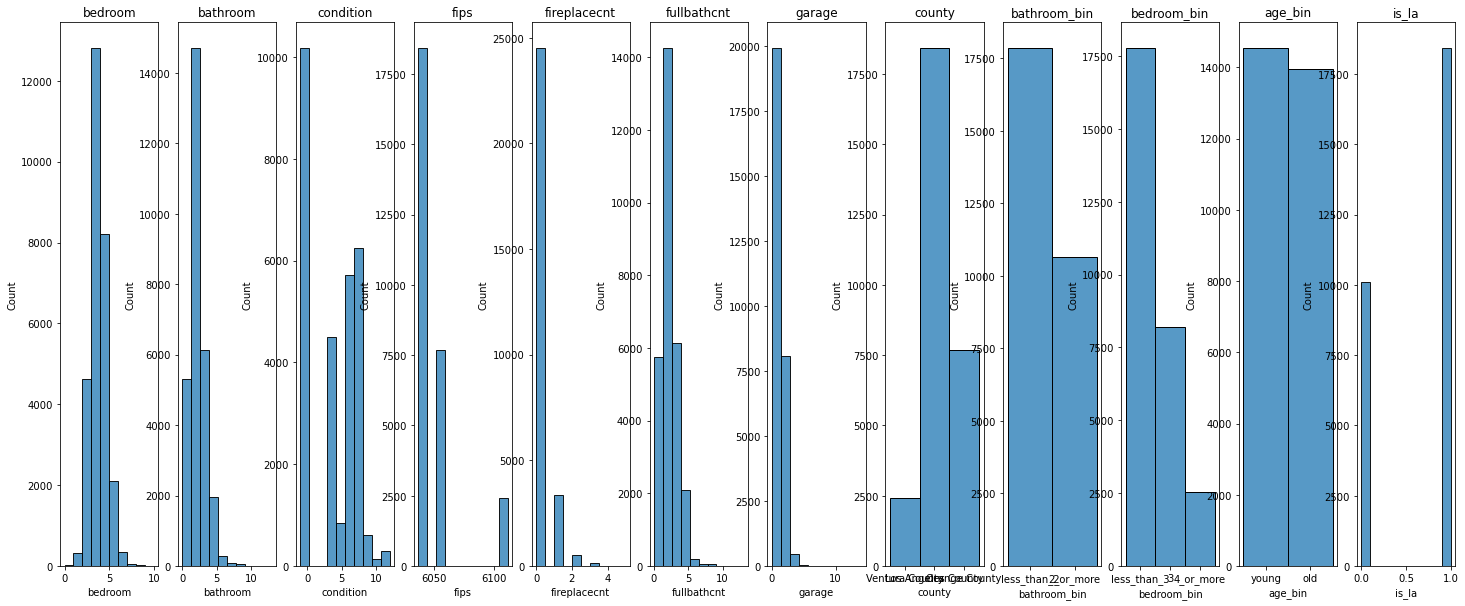

In [42]:
explore.plot_histograms(train, categorical)

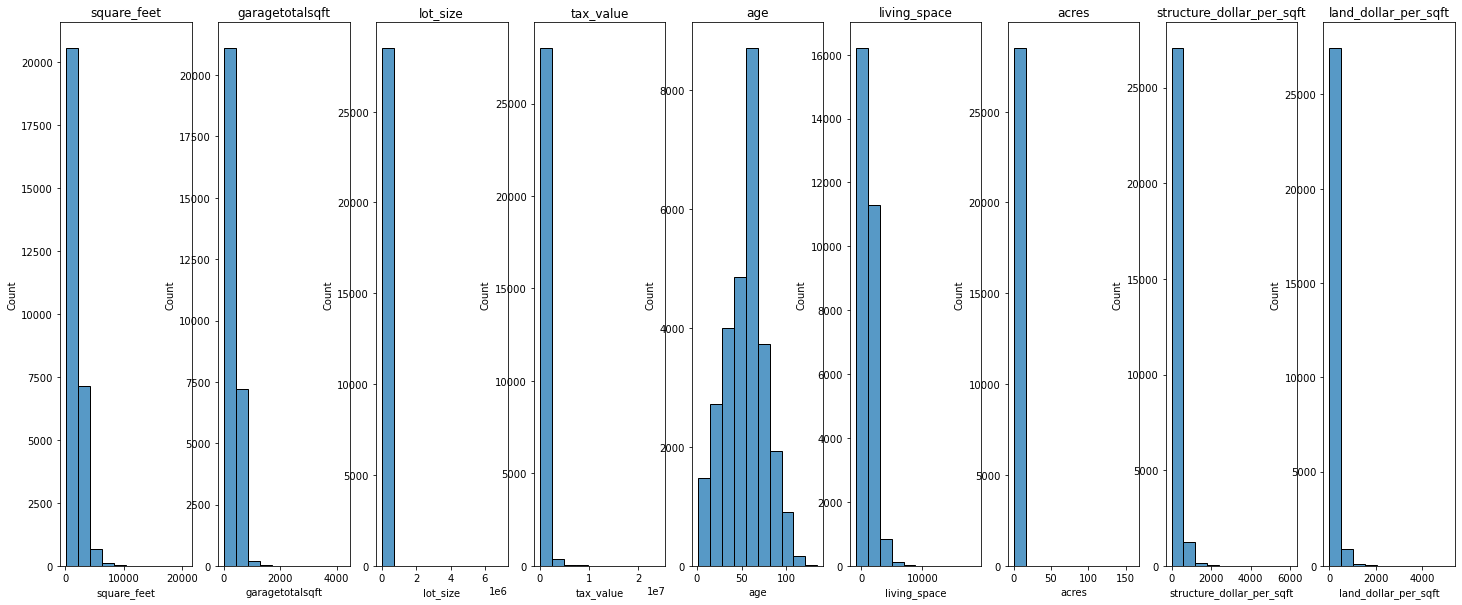

In [43]:
explore.plot_histograms(train, continuous)

#### Bivariate analysis

Generating plots logerror by bedroom


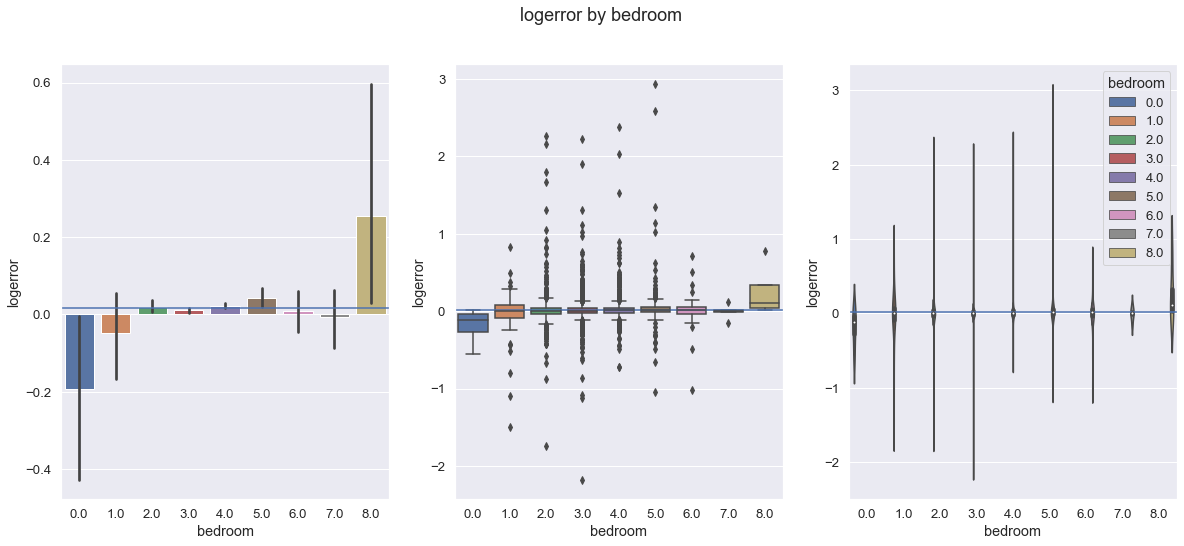

Generating plots logerror by bathroom


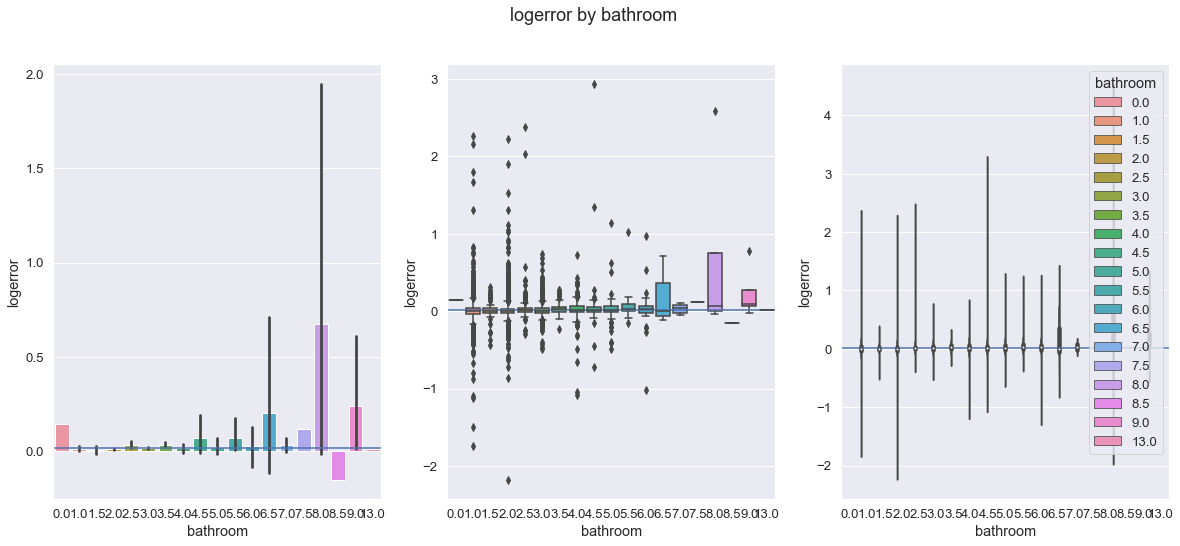

Generating plots logerror by condition


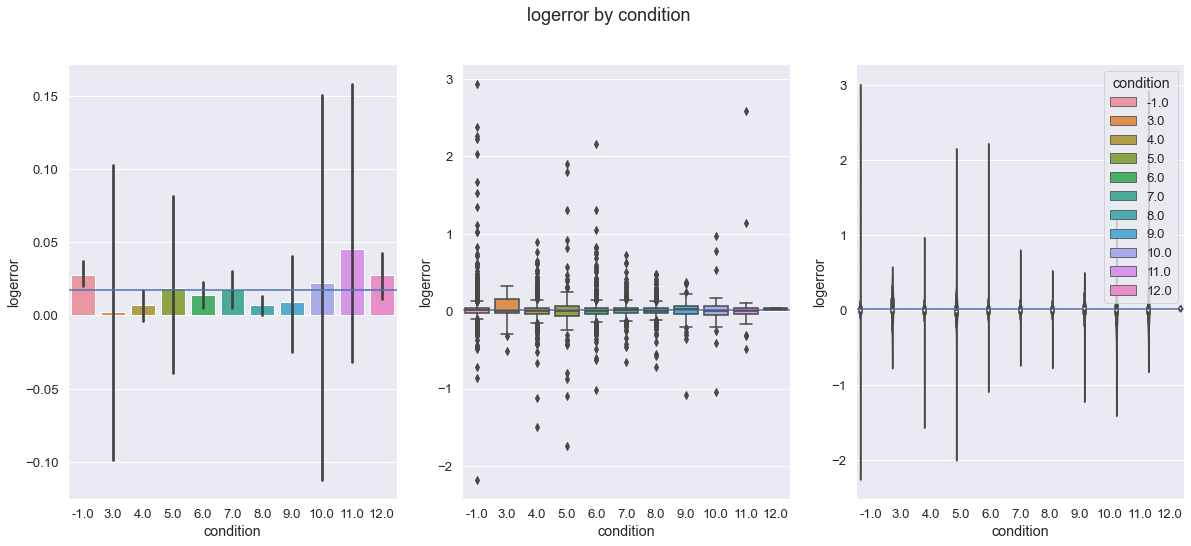

Generating plots logerror by fips


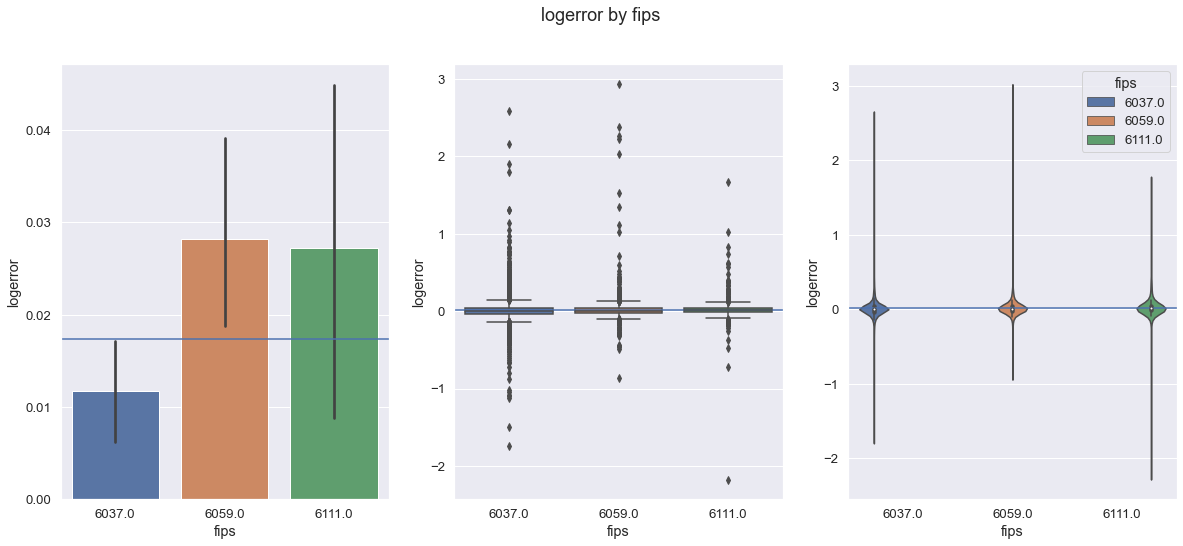

Generating plots logerror by fireplacecnt


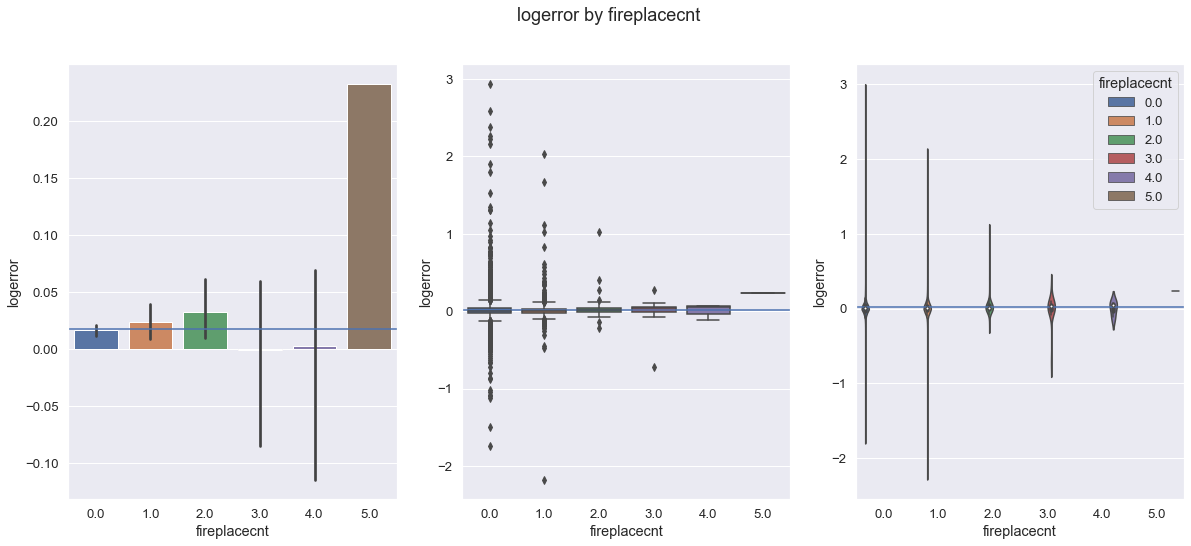

Generating plots logerror by fullbathcnt


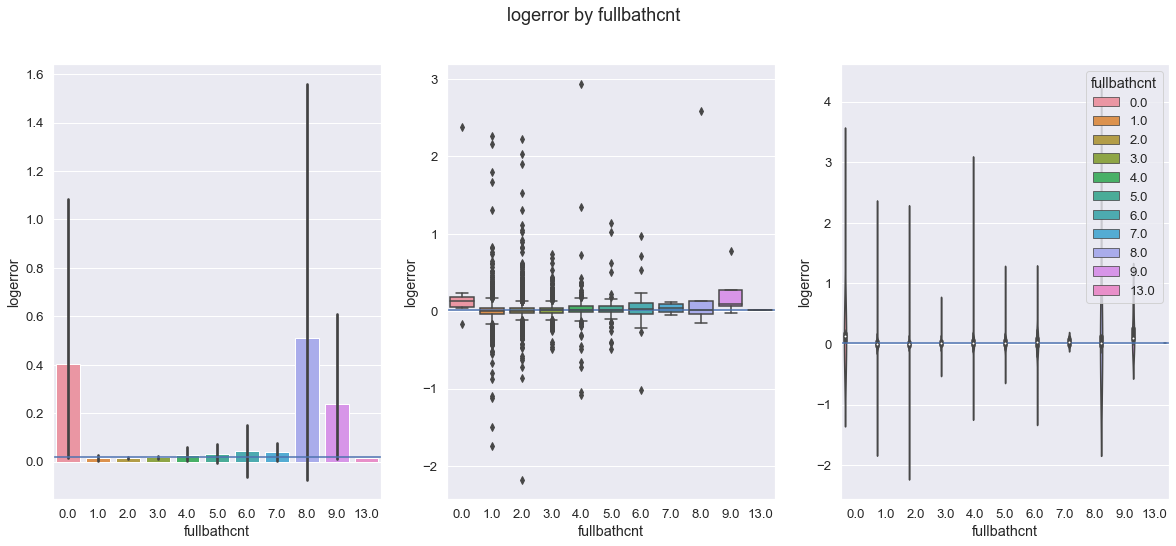

Generating plots logerror by garage


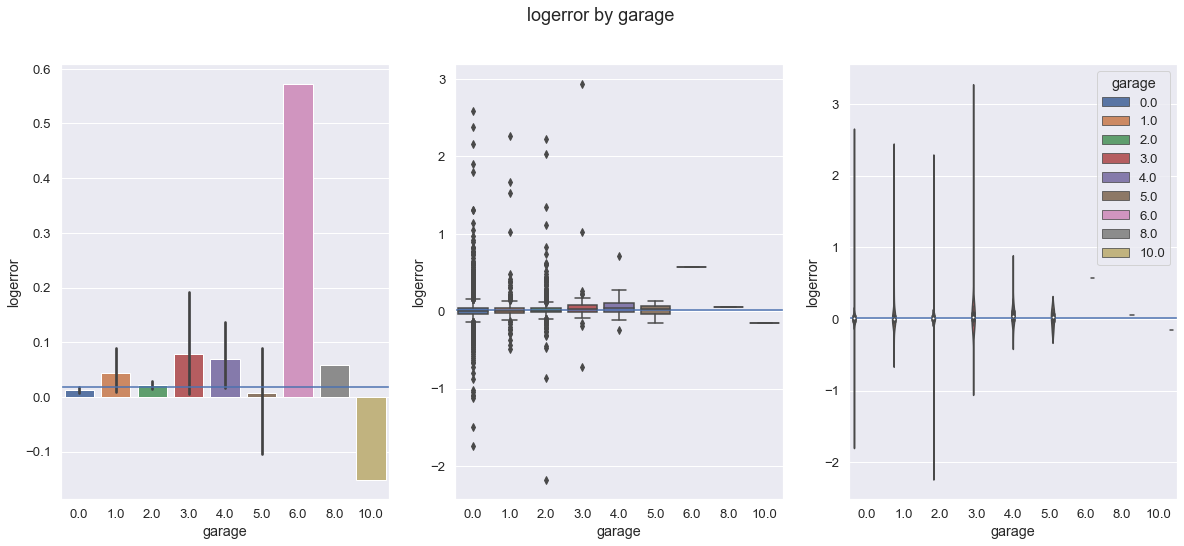

Generating plots logerror by county


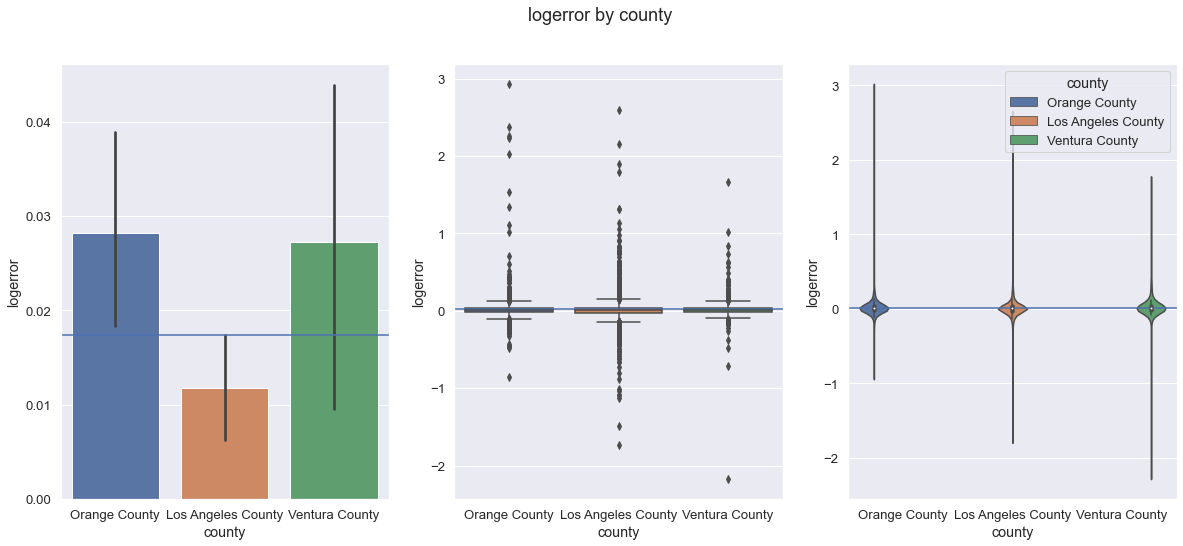

Generating plots logerror by bathroom_bin


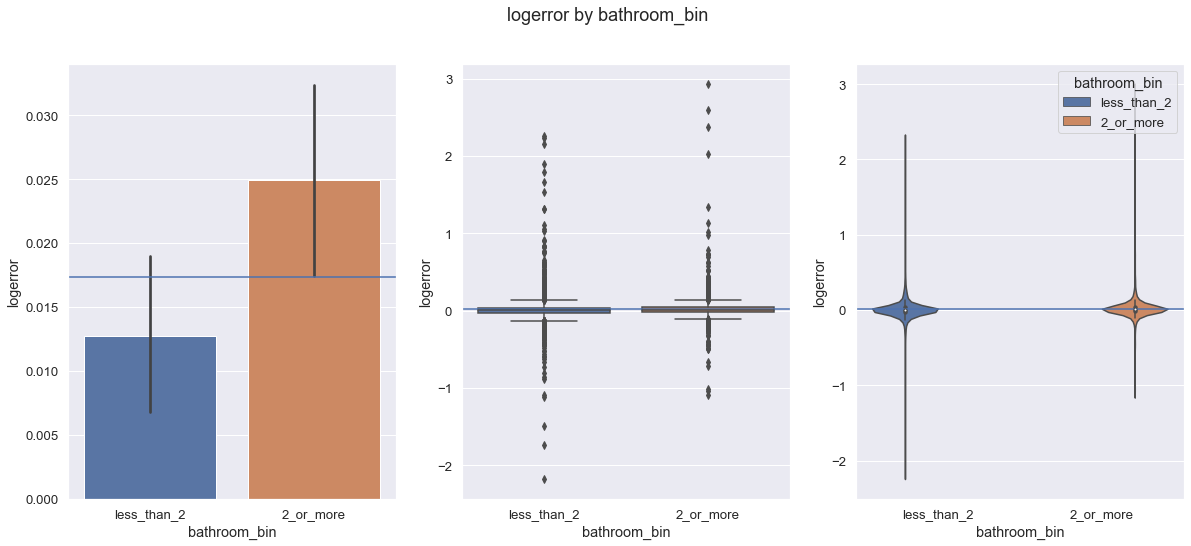

Generating plots logerror by bedroom_bin


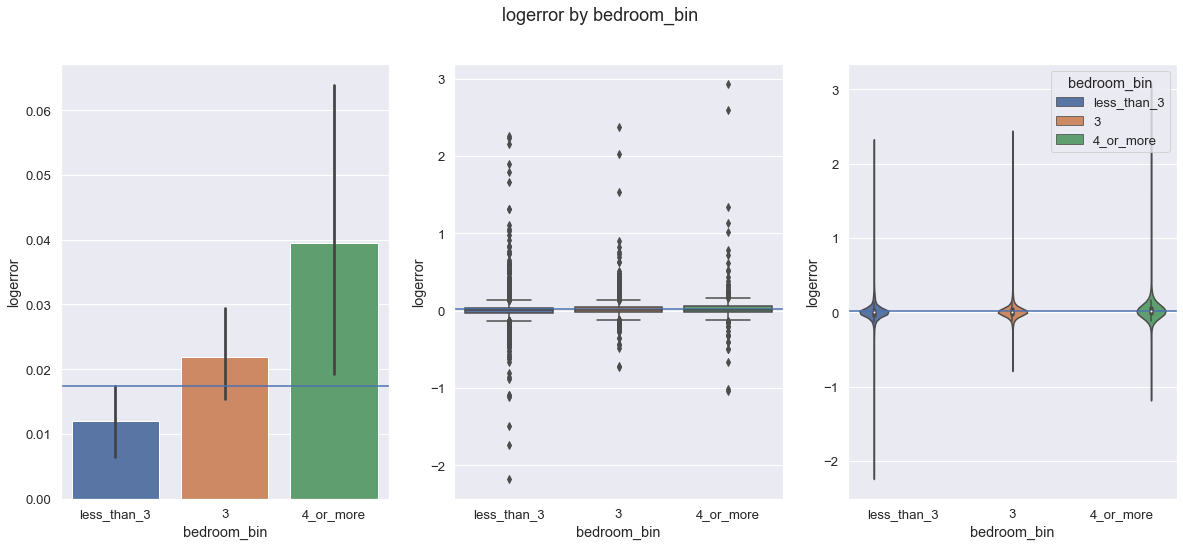

Generating plots logerror by age_bin


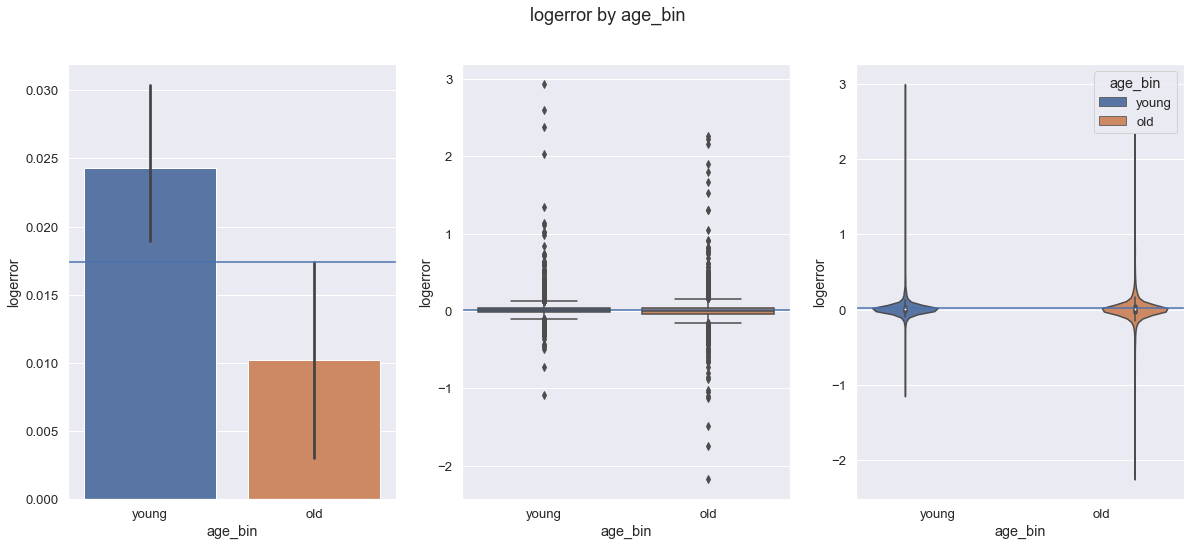

Generating plots logerror by is_la


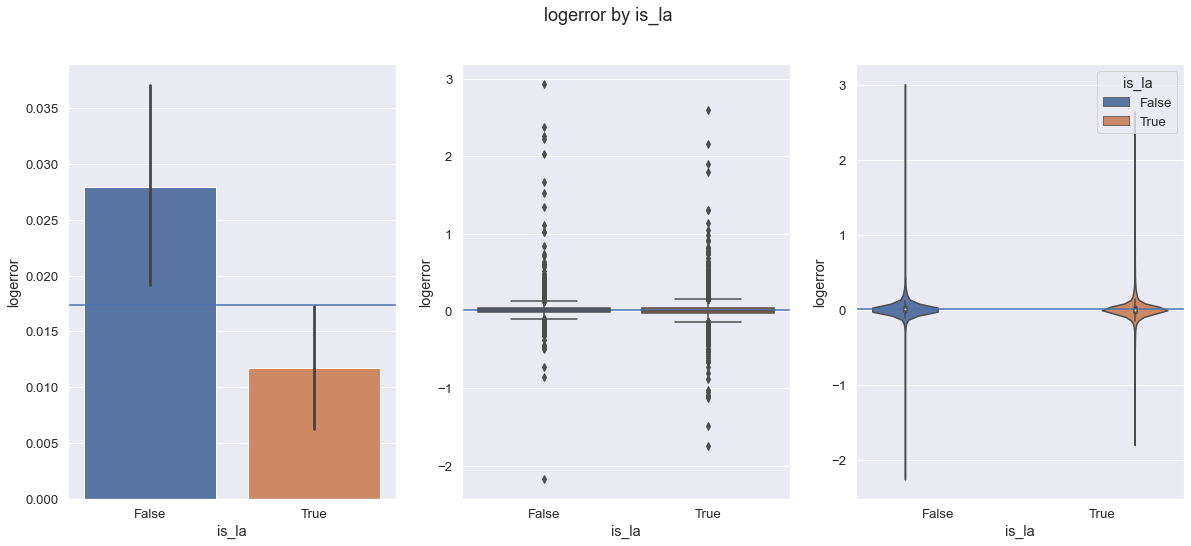

Generating plots square_feet by bedroom


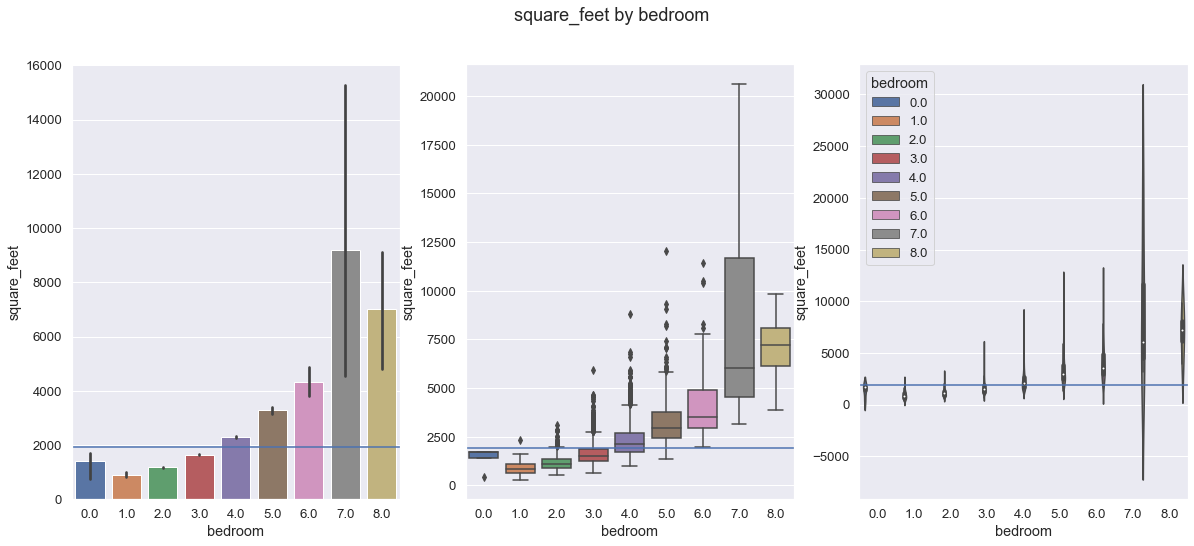

Generating plots square_feet by bathroom


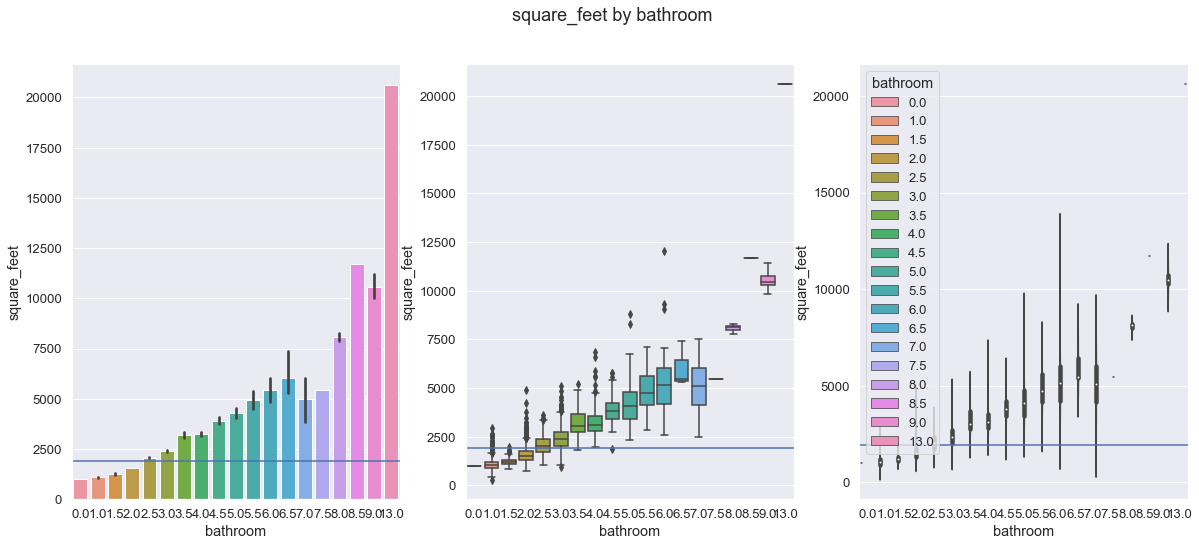

Generating plots square_feet by condition


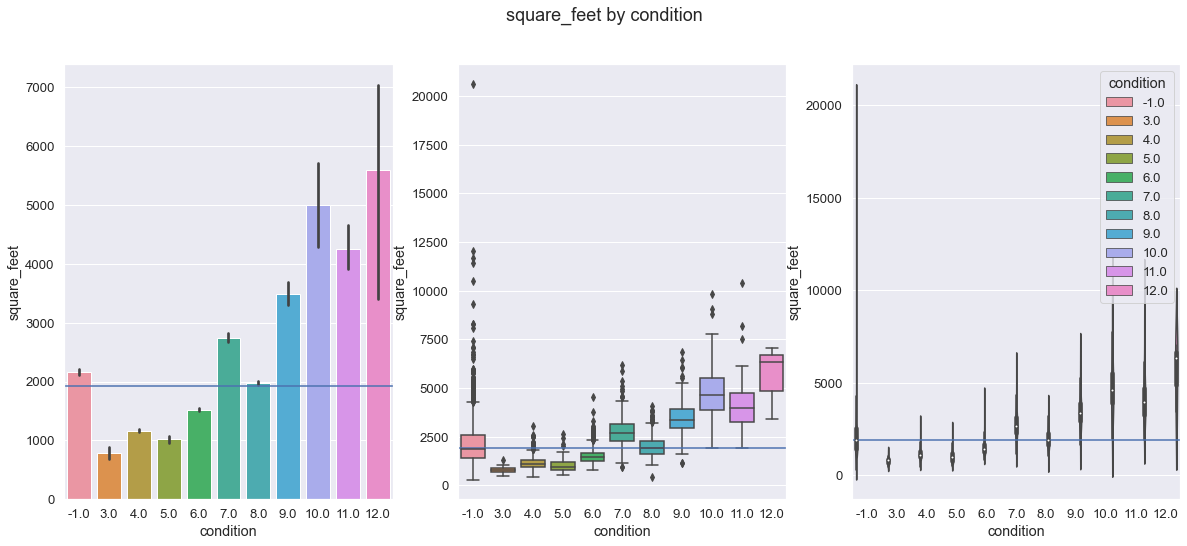

Generating plots square_feet by fips


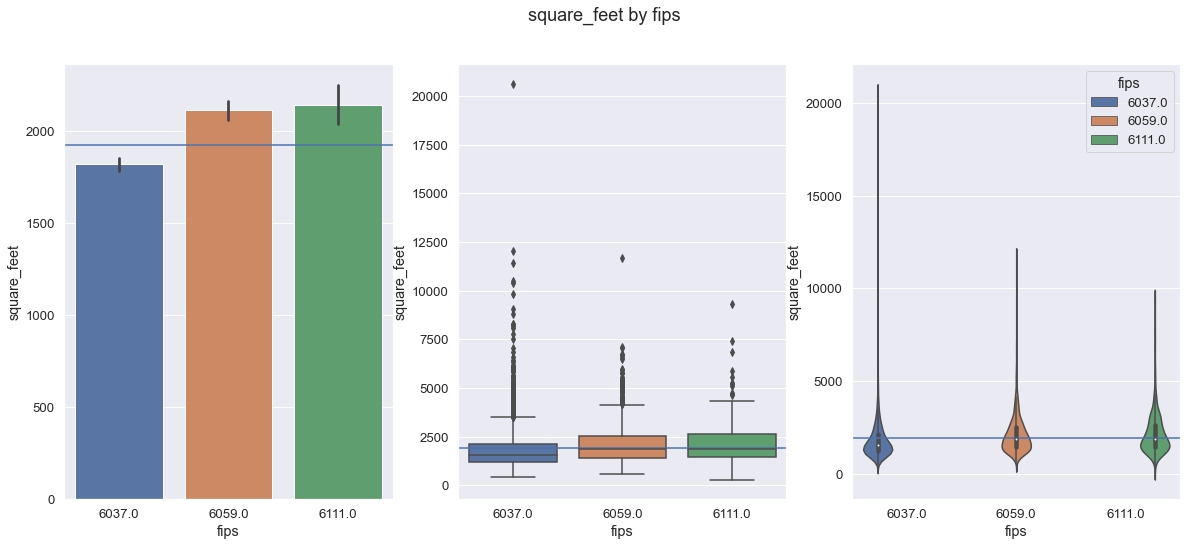

Generating plots square_feet by fireplacecnt


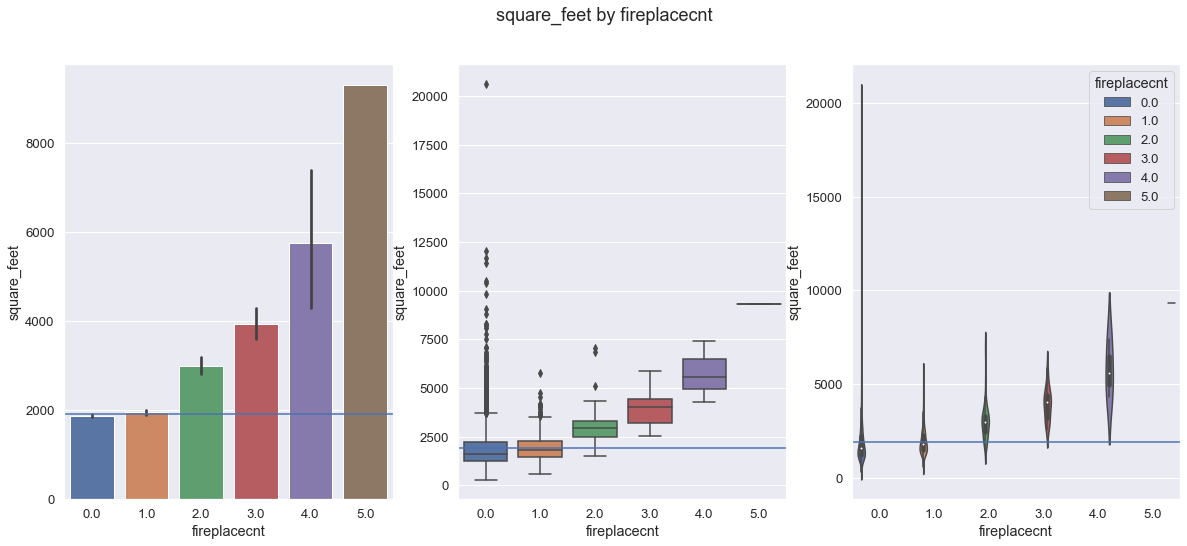

Generating plots square_feet by fullbathcnt


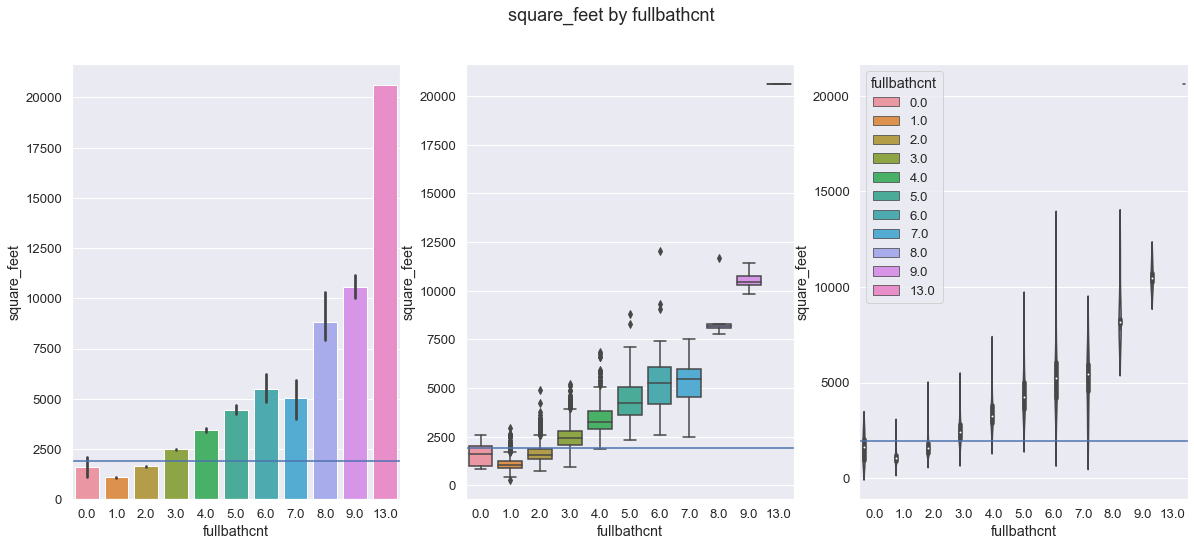

Generating plots square_feet by garage


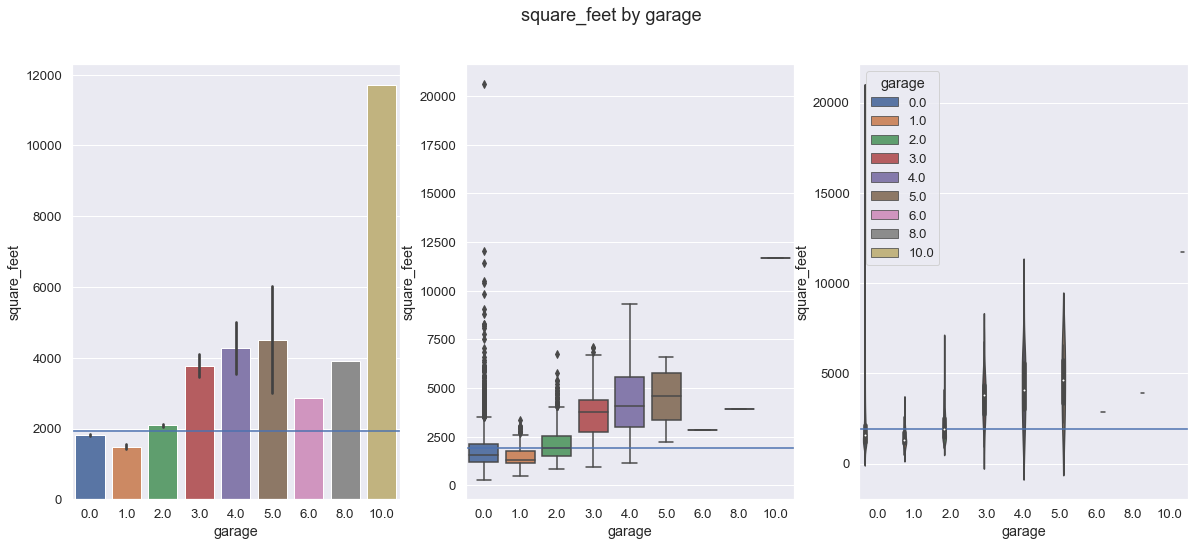

Generating plots square_feet by county


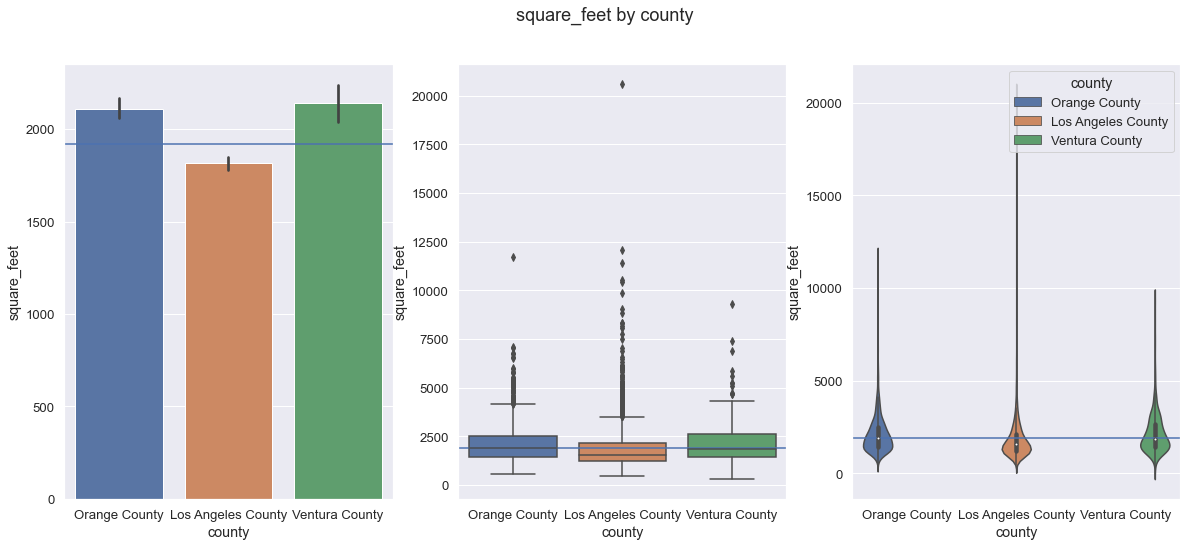

Generating plots square_feet by bathroom_bin


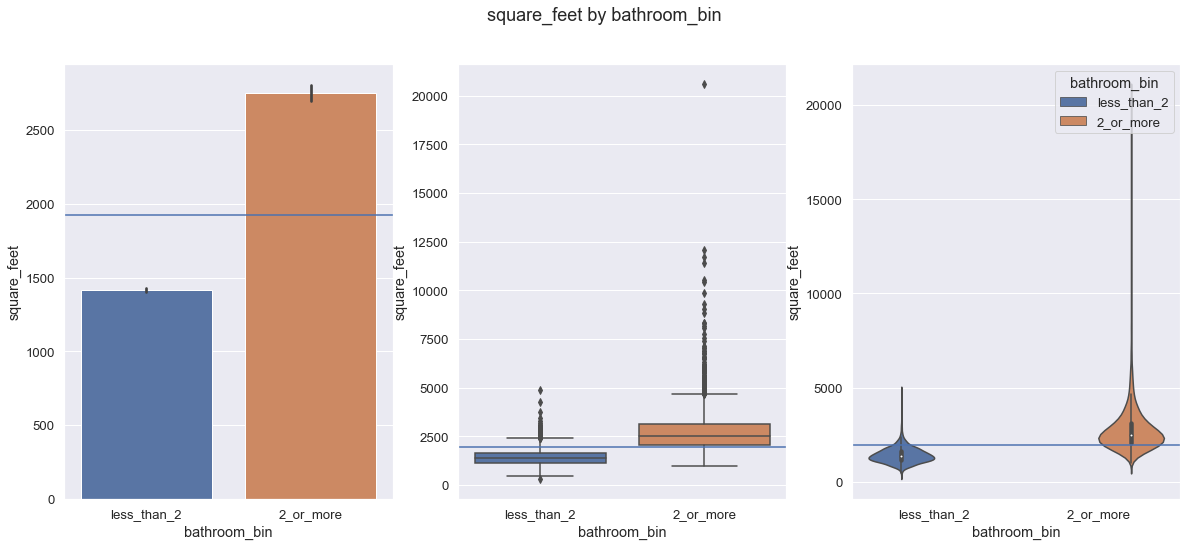

Generating plots square_feet by bedroom_bin


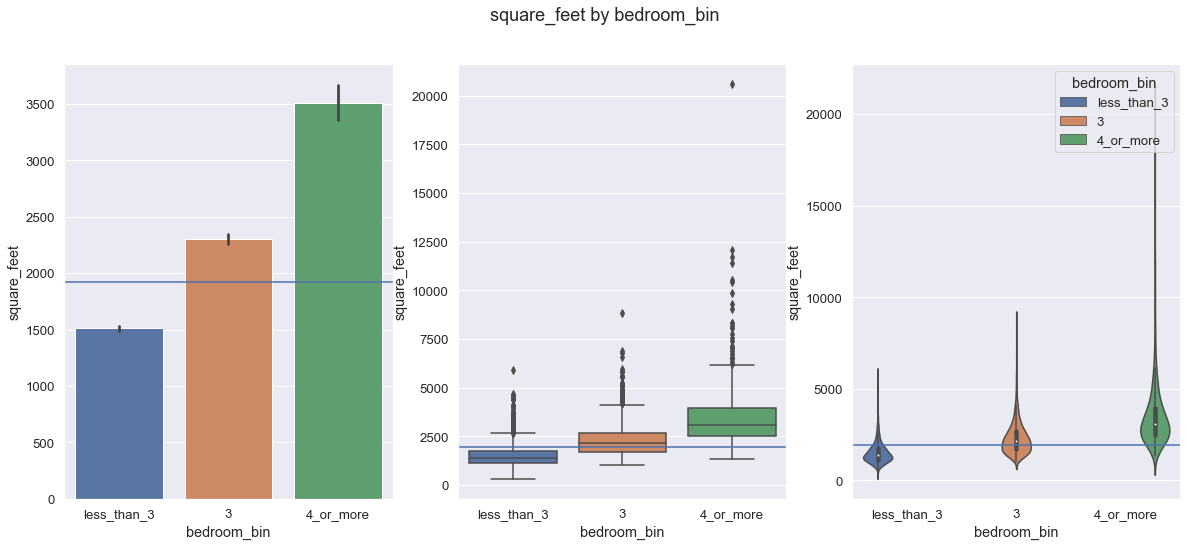

Generating plots square_feet by age_bin


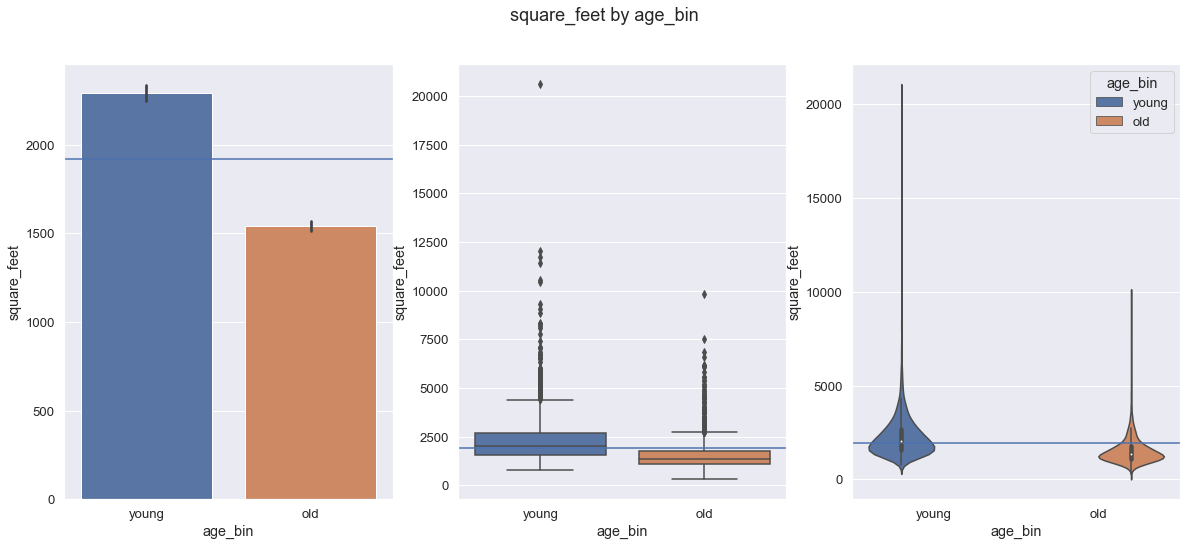

Generating plots square_feet by is_la


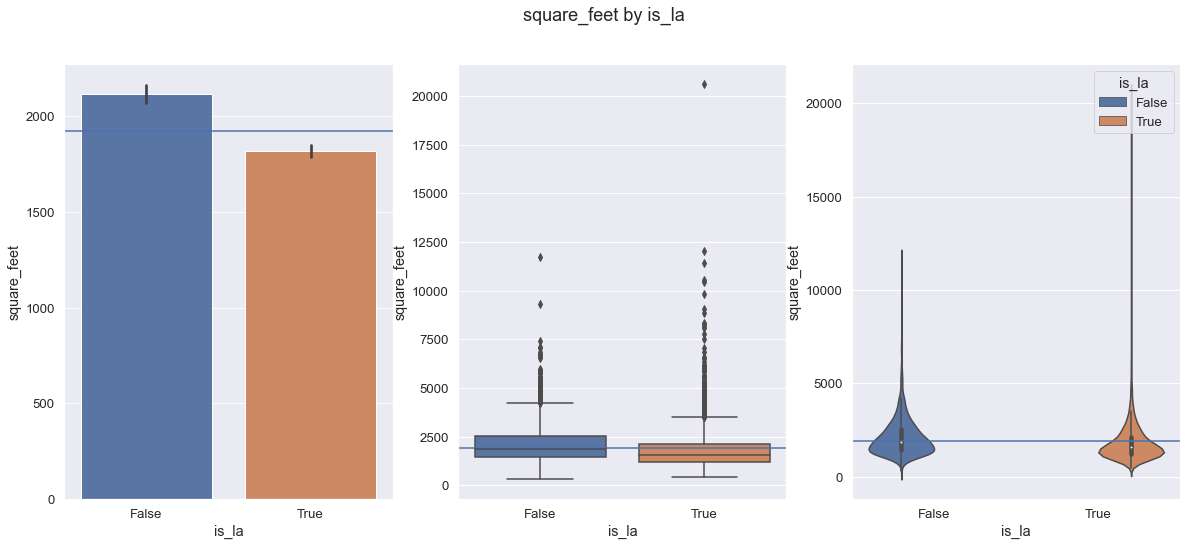

Generating plots garagetotalsqft by bedroom


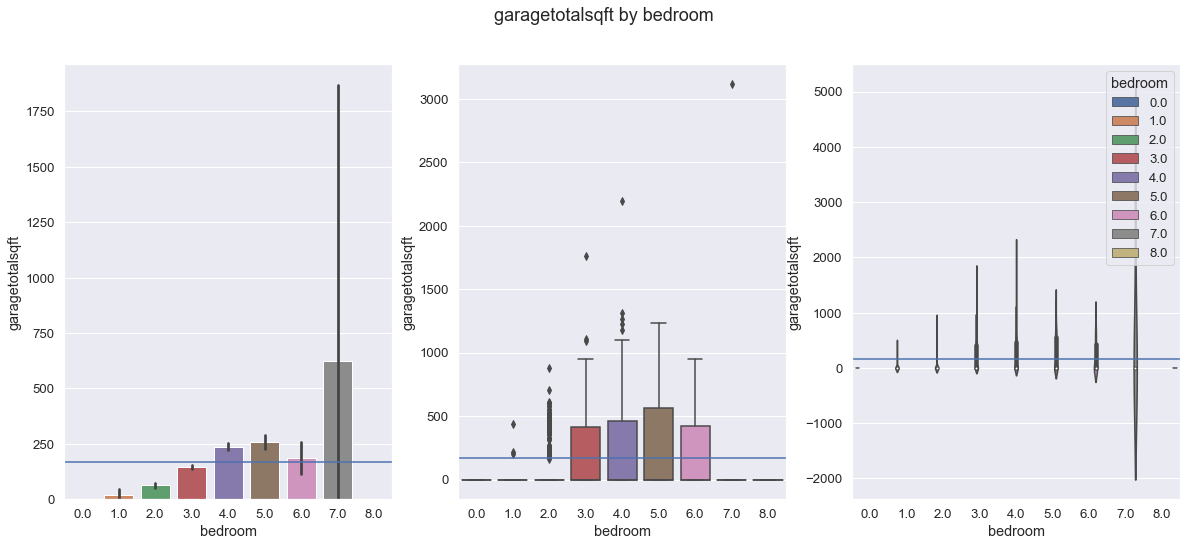

Generating plots garagetotalsqft by bathroom


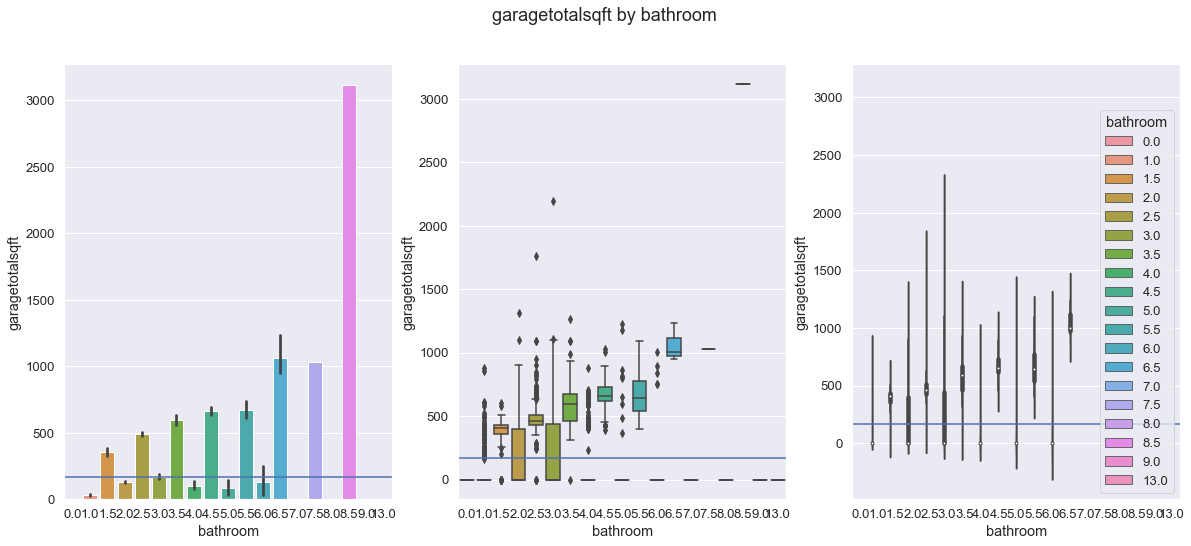

Generating plots garagetotalsqft by condition


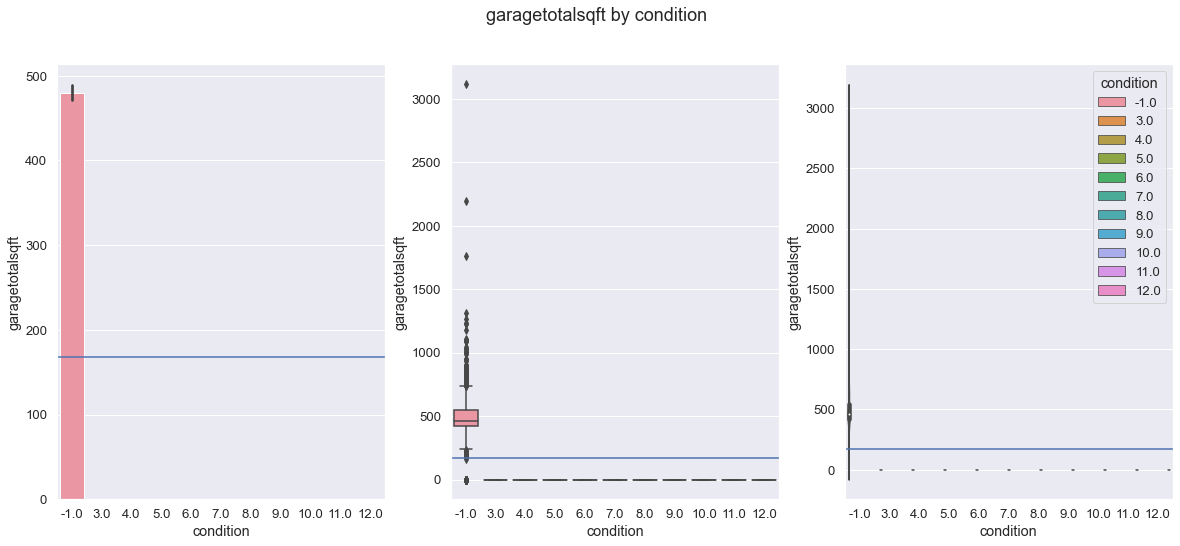

Generating plots garagetotalsqft by fips


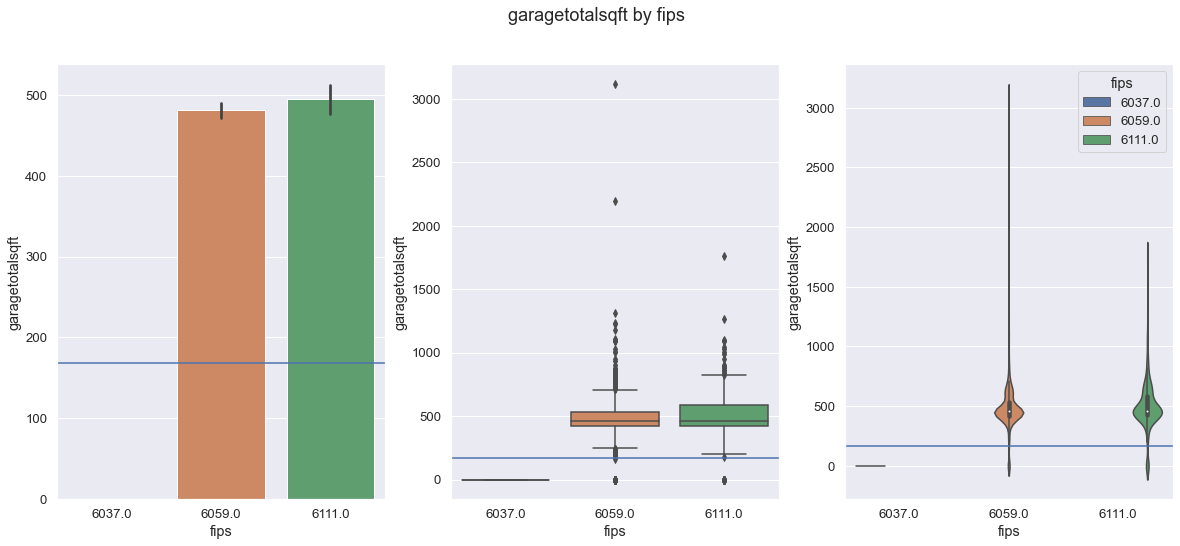

Generating plots garagetotalsqft by fireplacecnt


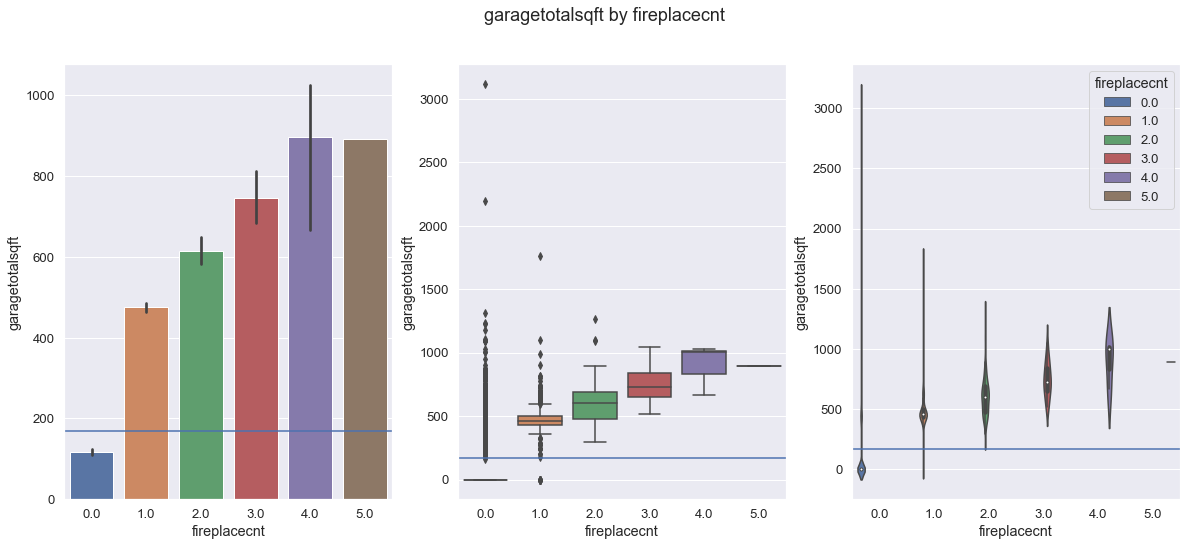

Generating plots garagetotalsqft by fullbathcnt


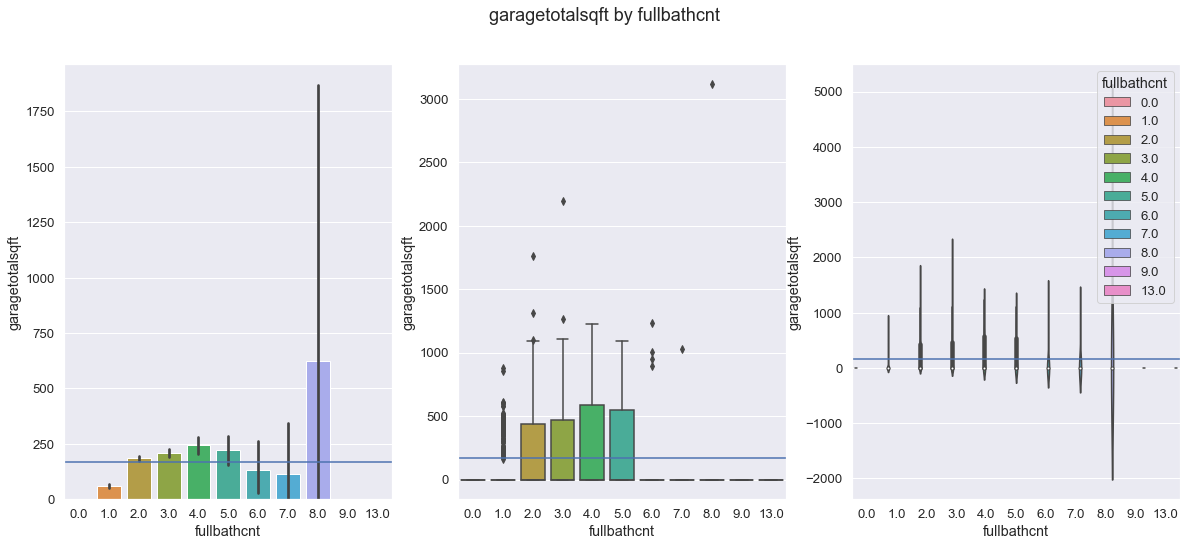

Generating plots garagetotalsqft by garage


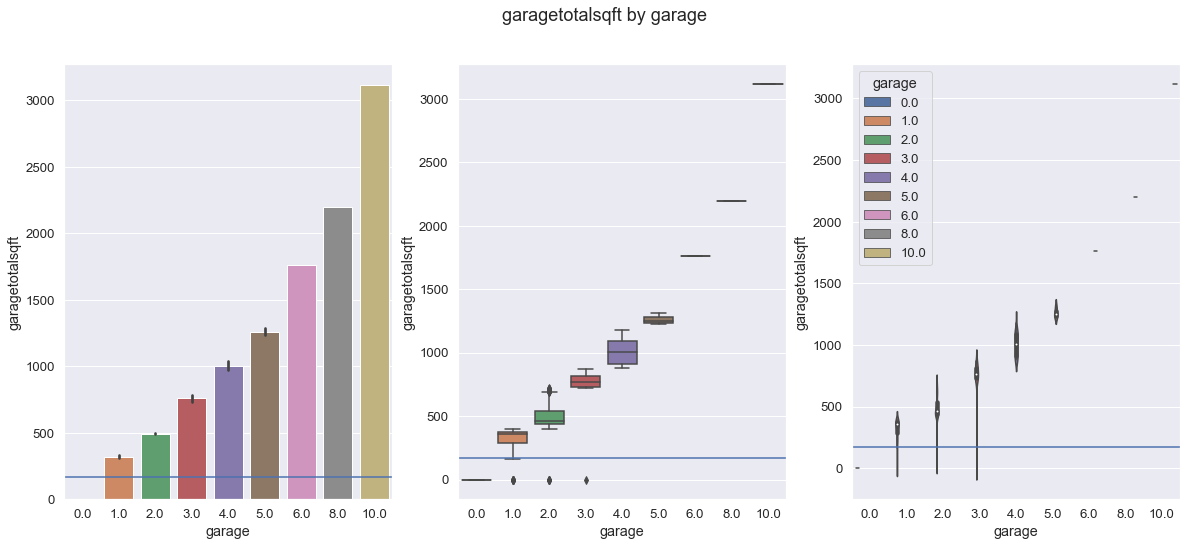

Generating plots garagetotalsqft by county


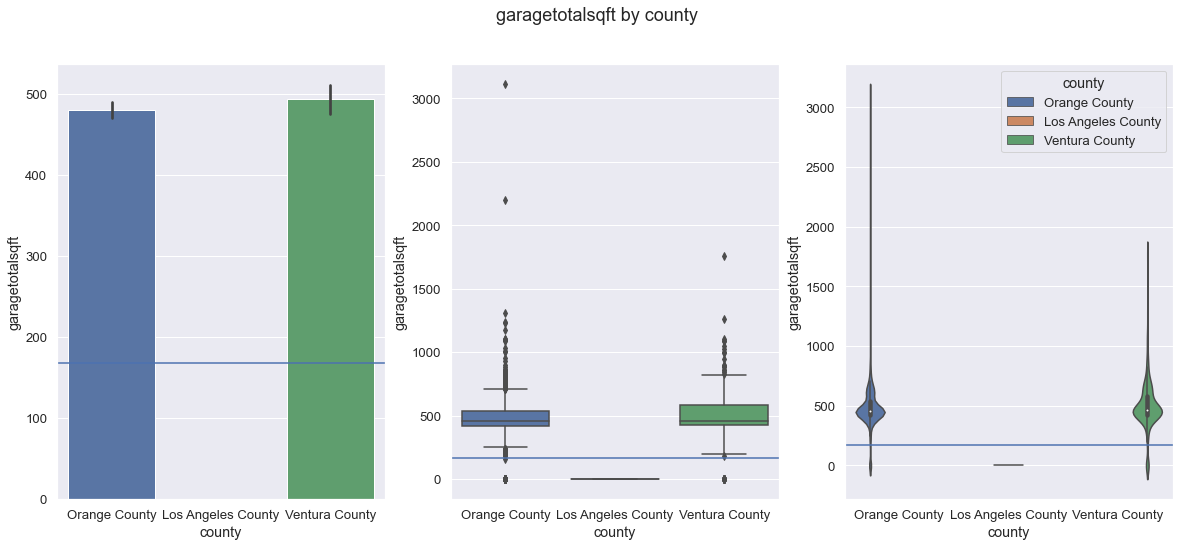

Generating plots garagetotalsqft by bathroom_bin


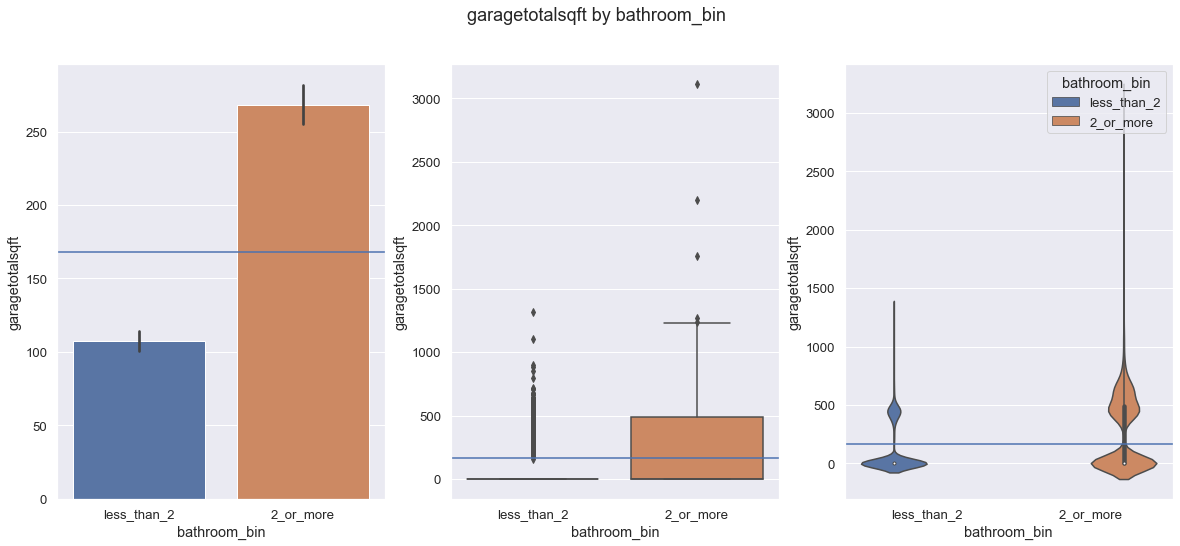

Generating plots garagetotalsqft by bedroom_bin


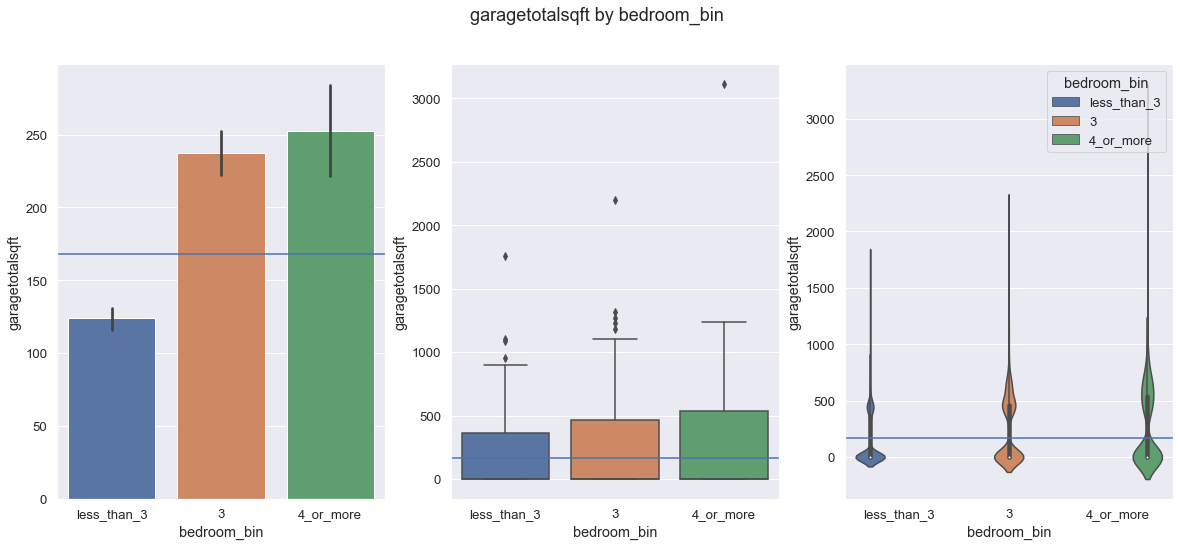

Generating plots garagetotalsqft by age_bin


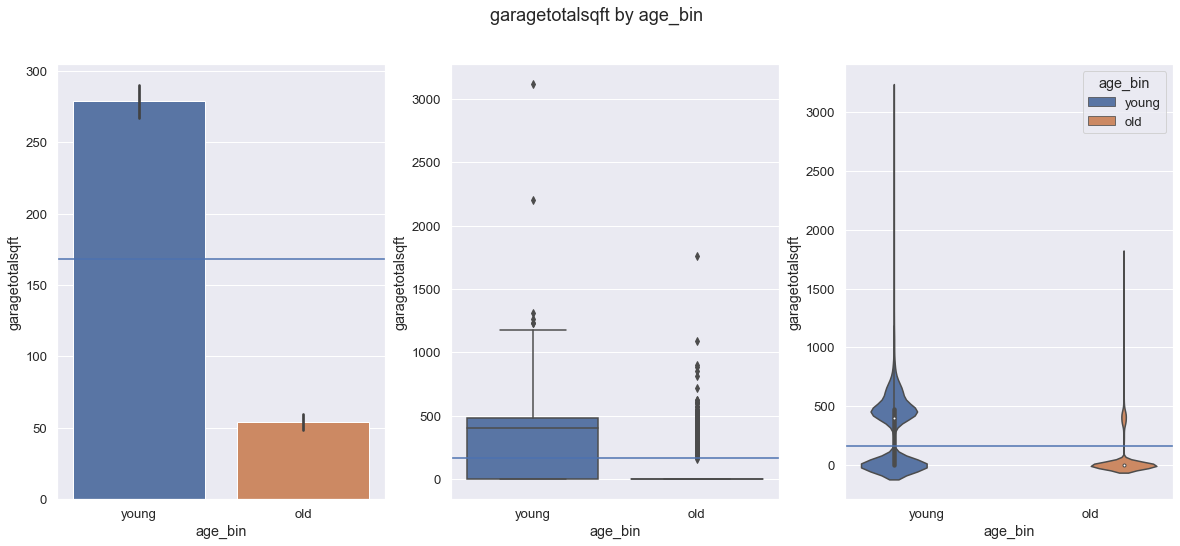

Generating plots garagetotalsqft by is_la


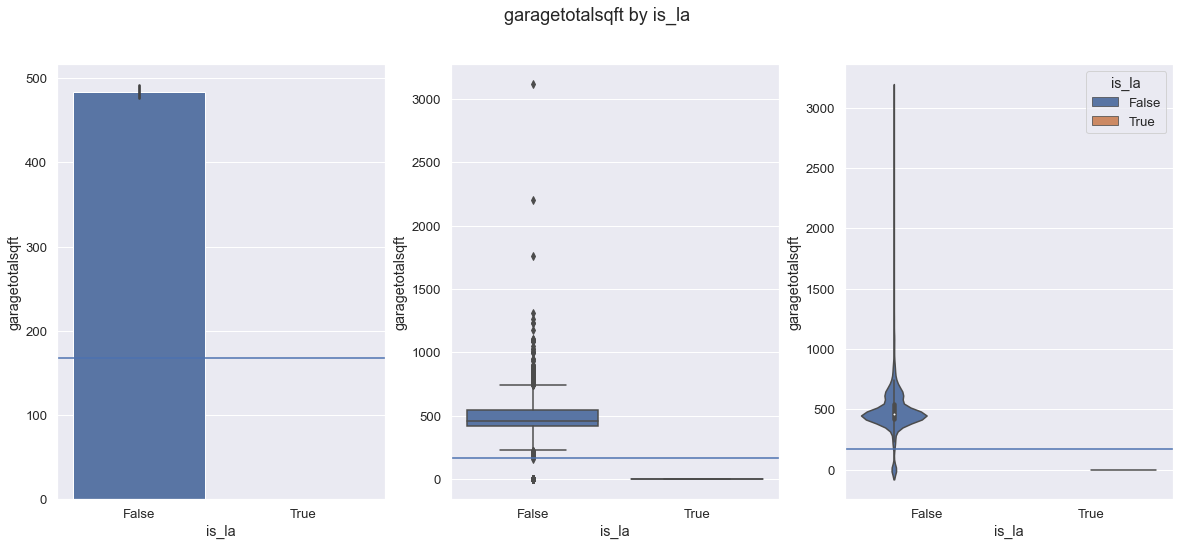

Generating plots lot_size by bedroom


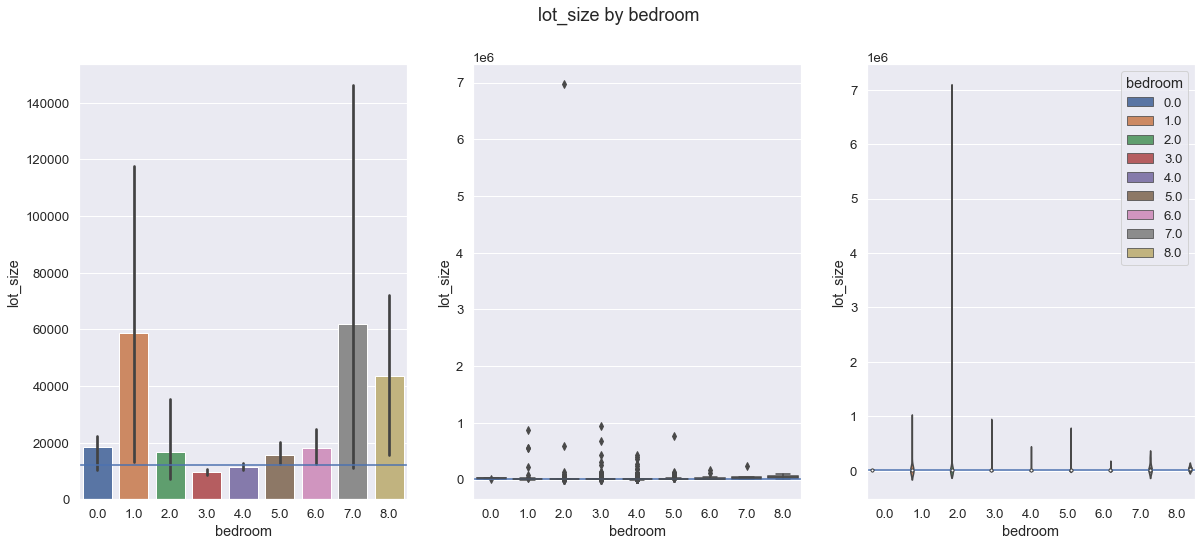

Generating plots lot_size by bathroom


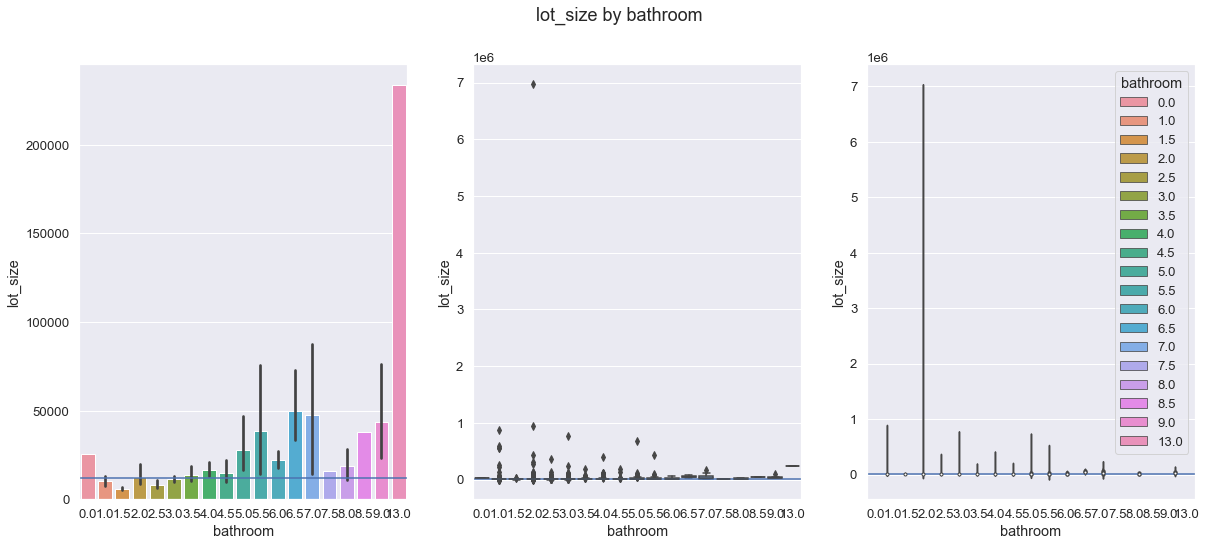

Generating plots lot_size by condition


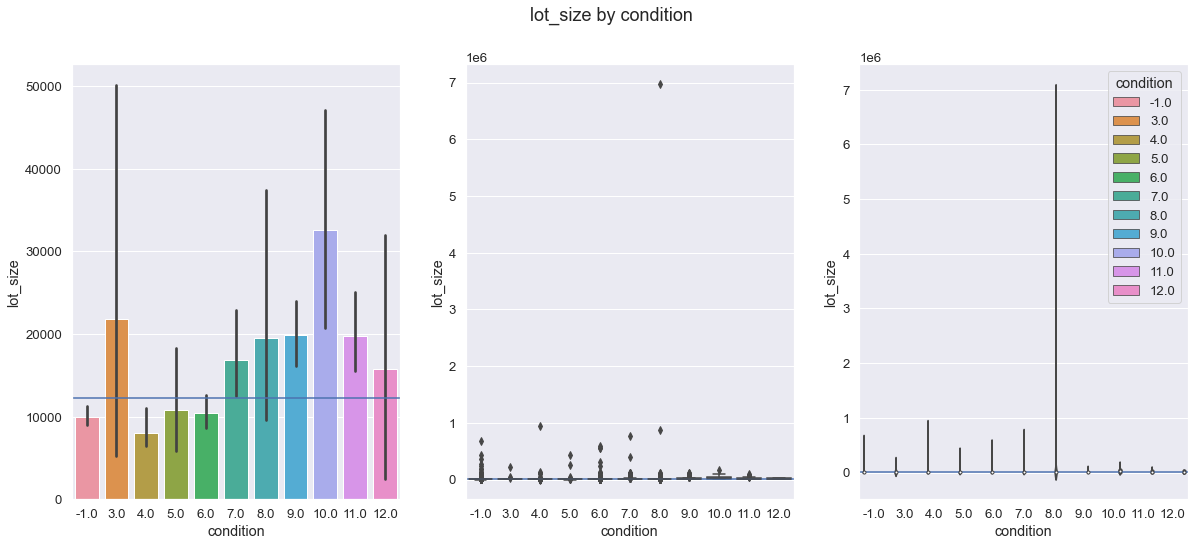

Generating plots lot_size by fips


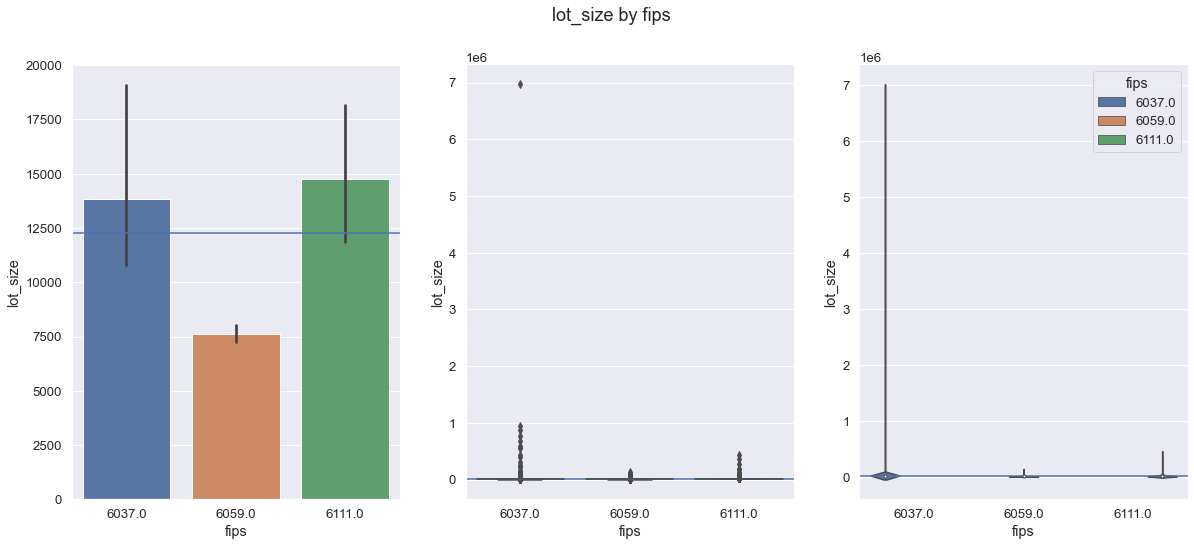

Generating plots lot_size by fireplacecnt


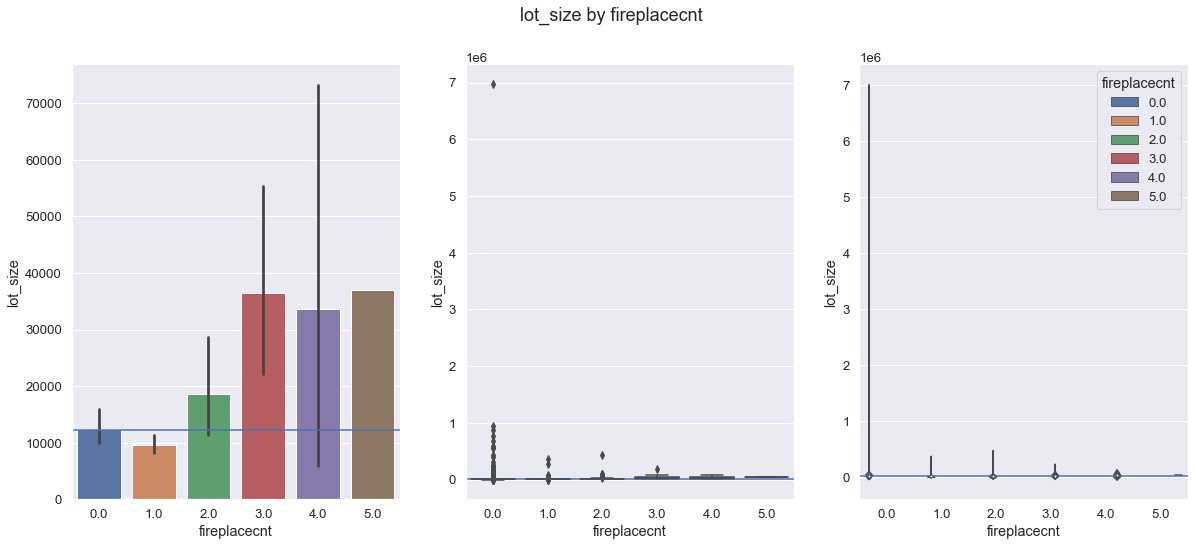

Generating plots lot_size by fullbathcnt


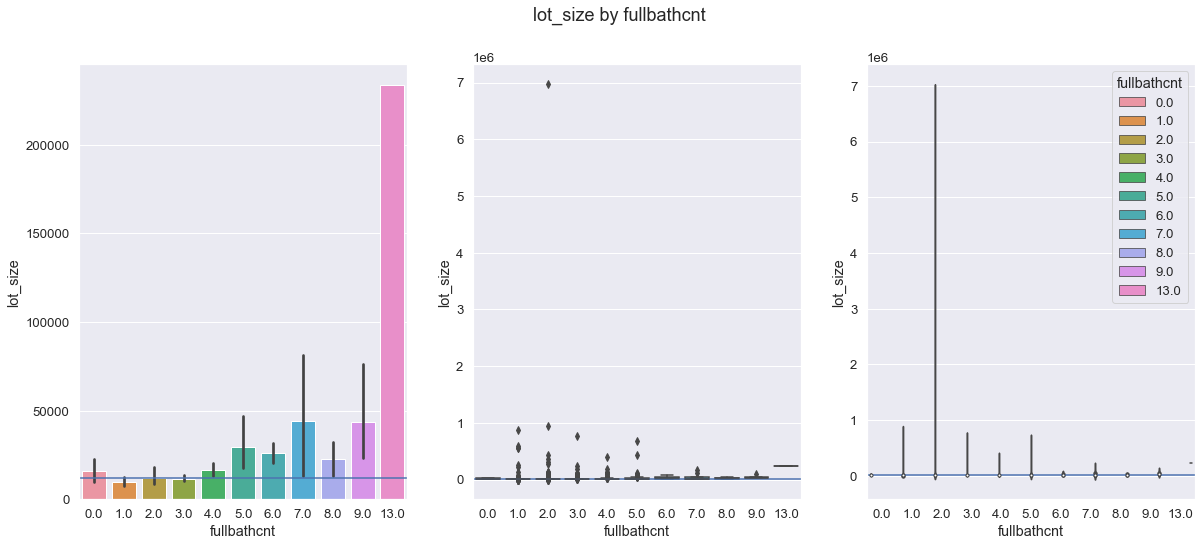

Generating plots lot_size by garage


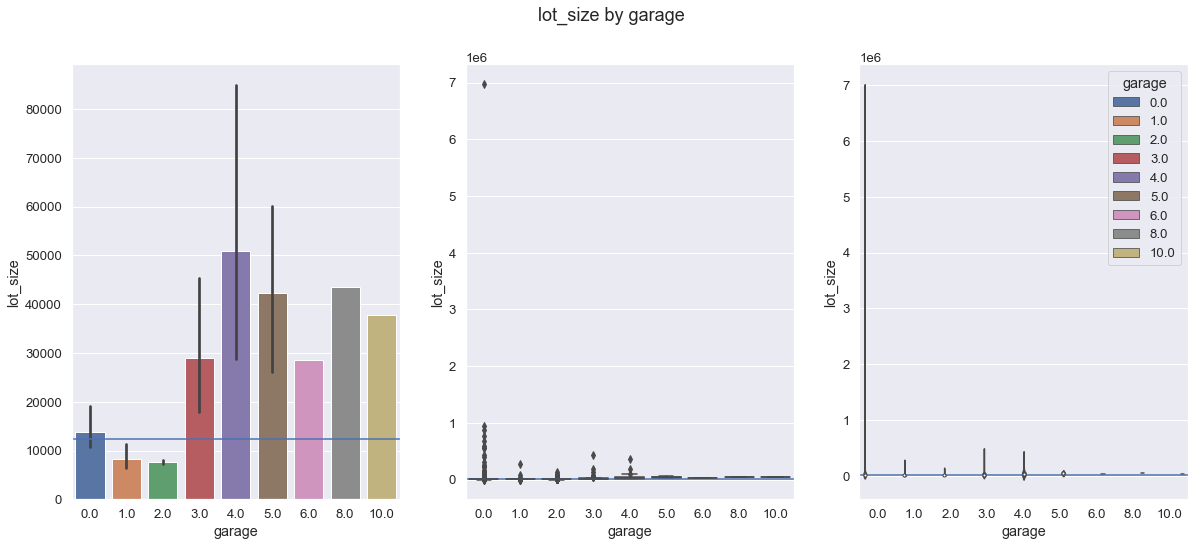

Generating plots lot_size by county


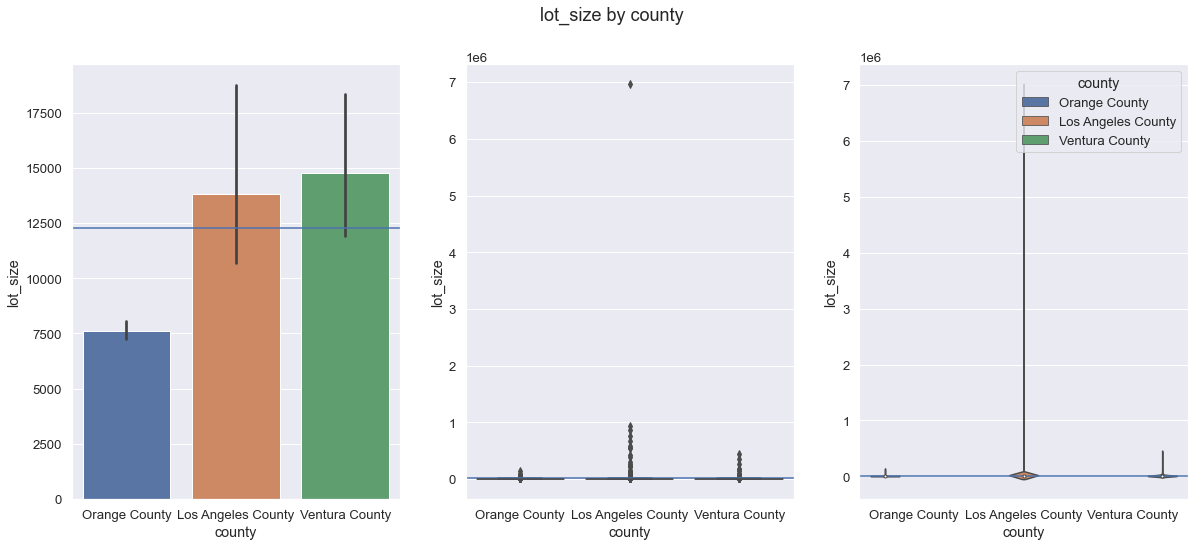

Generating plots lot_size by bathroom_bin


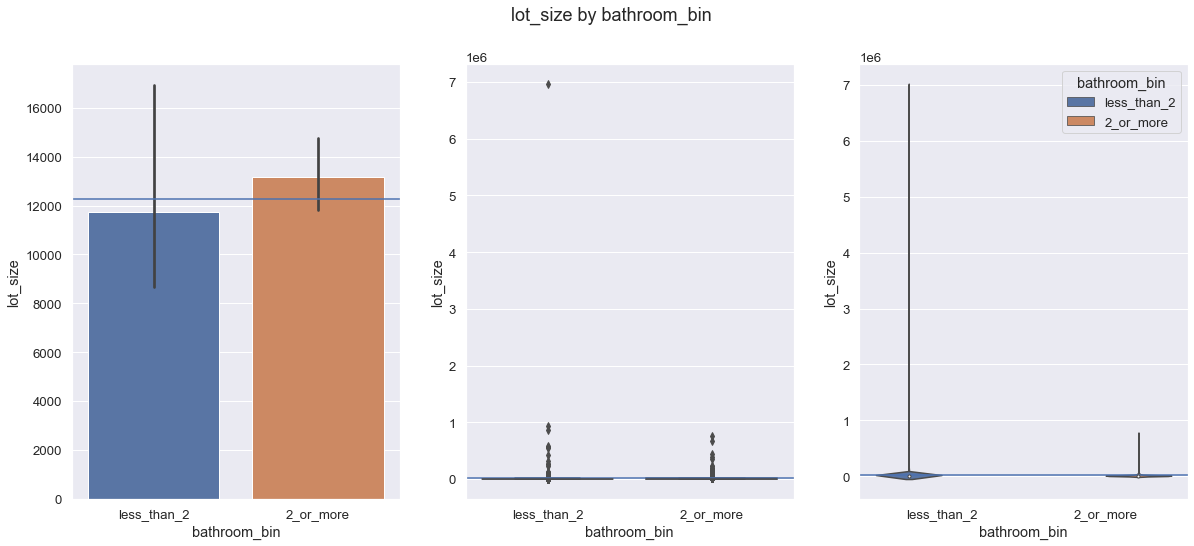

Generating plots lot_size by bedroom_bin


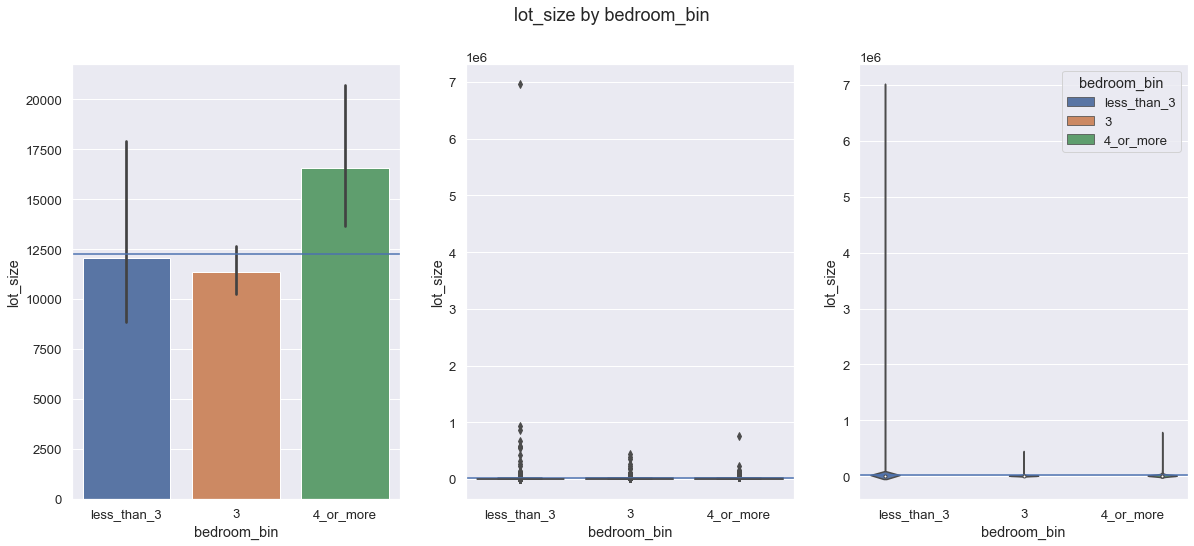

Generating plots lot_size by age_bin


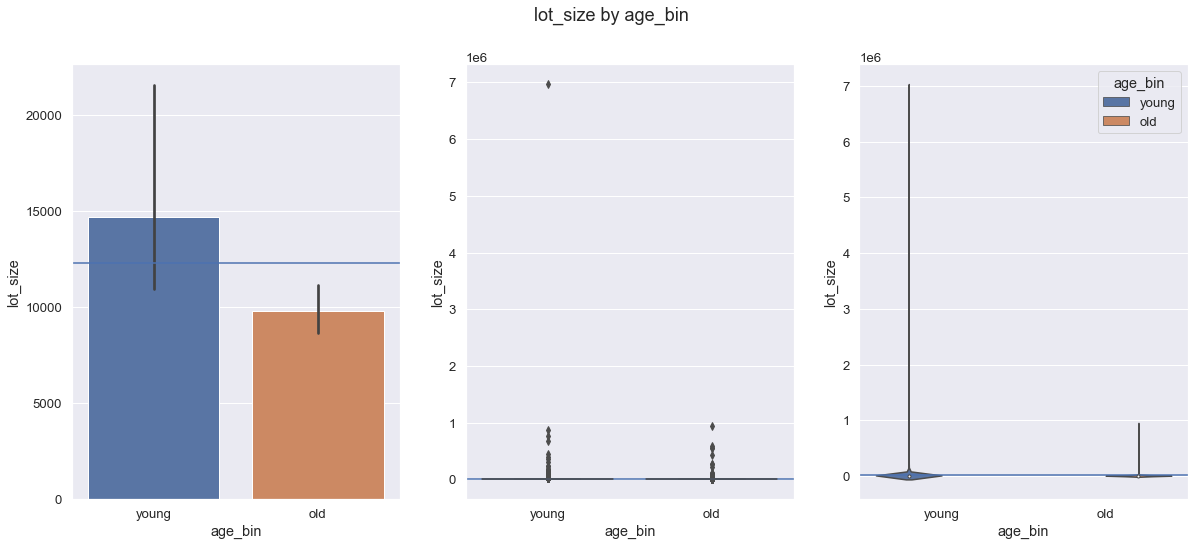

Generating plots lot_size by is_la


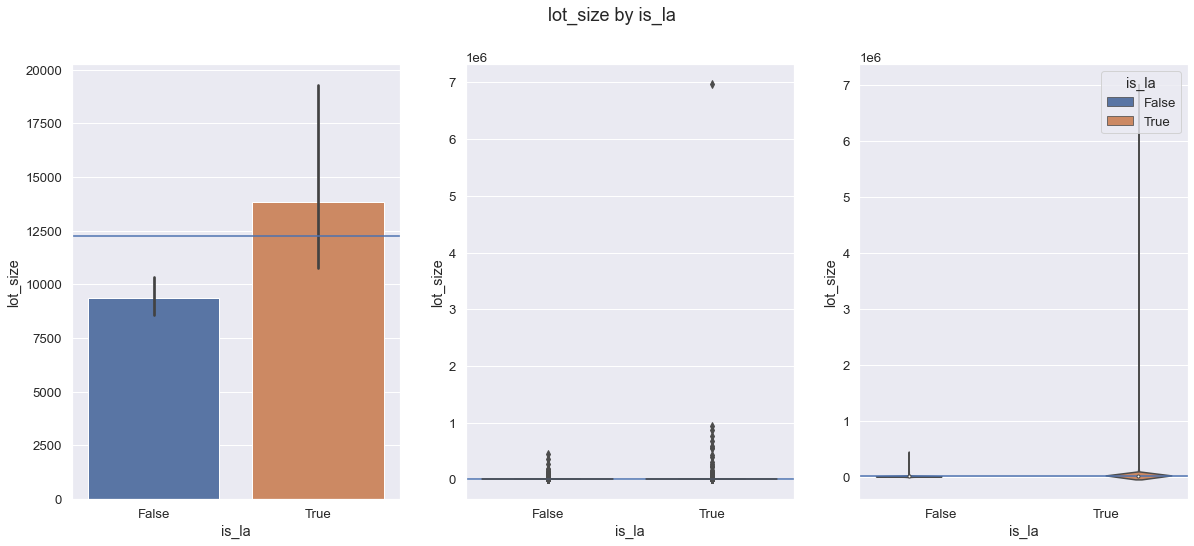

Generating plots tax_value by bedroom


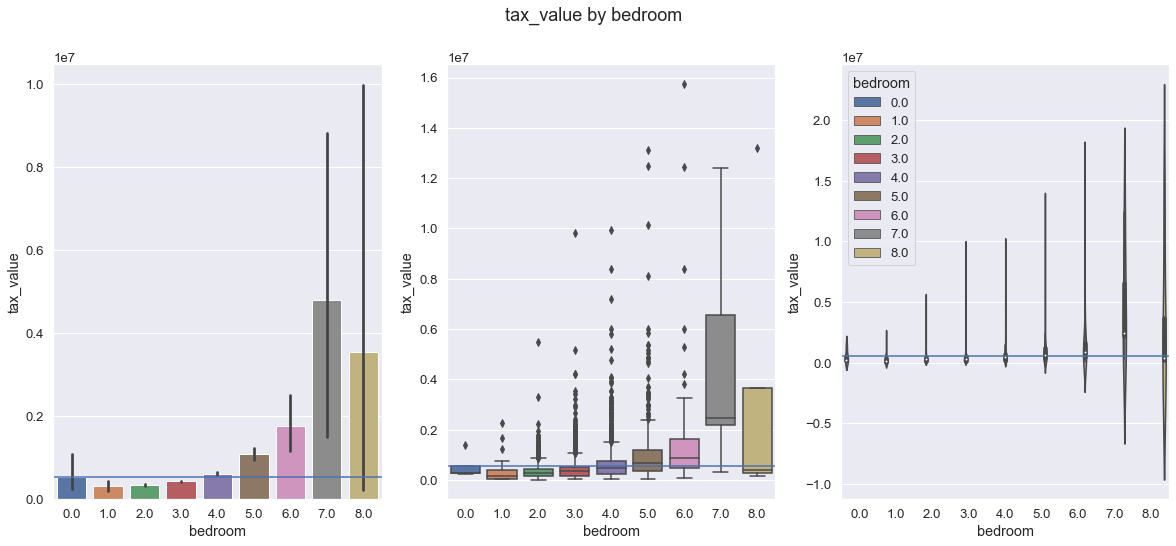

Generating plots tax_value by bathroom


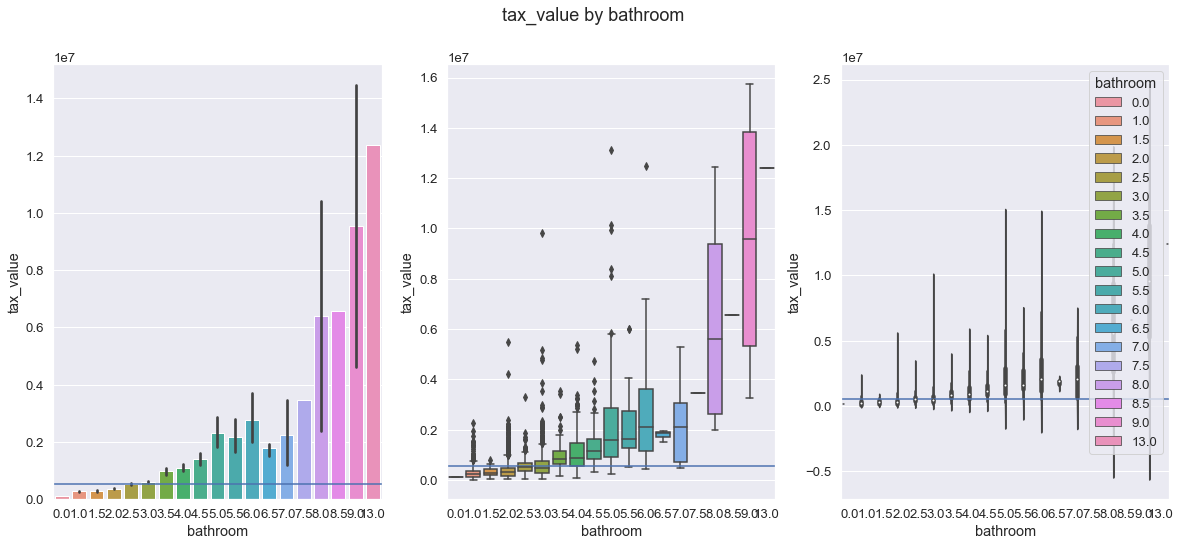

Generating plots tax_value by condition


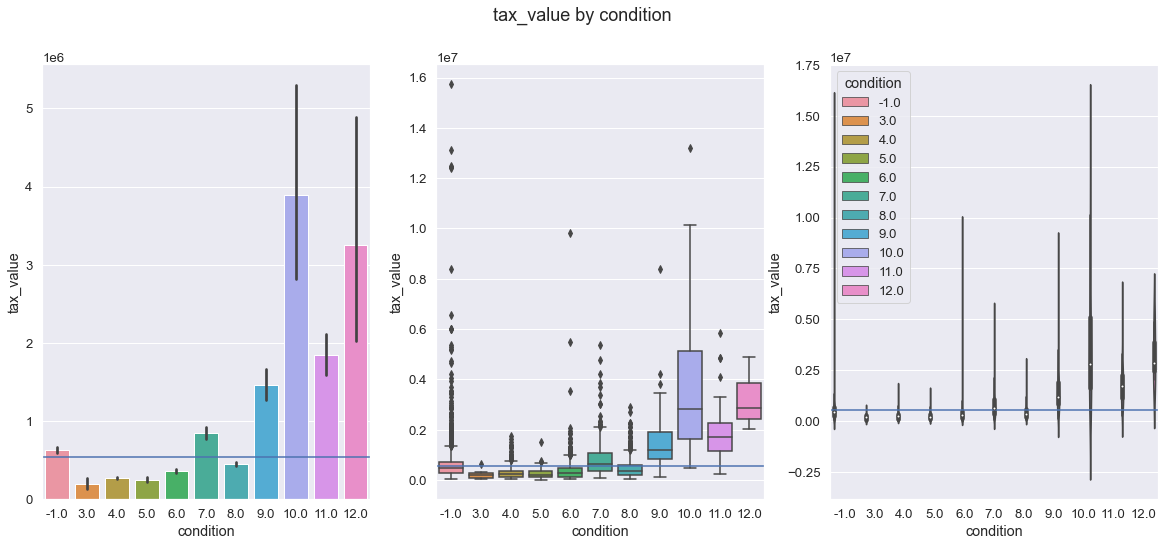

Generating plots tax_value by fips


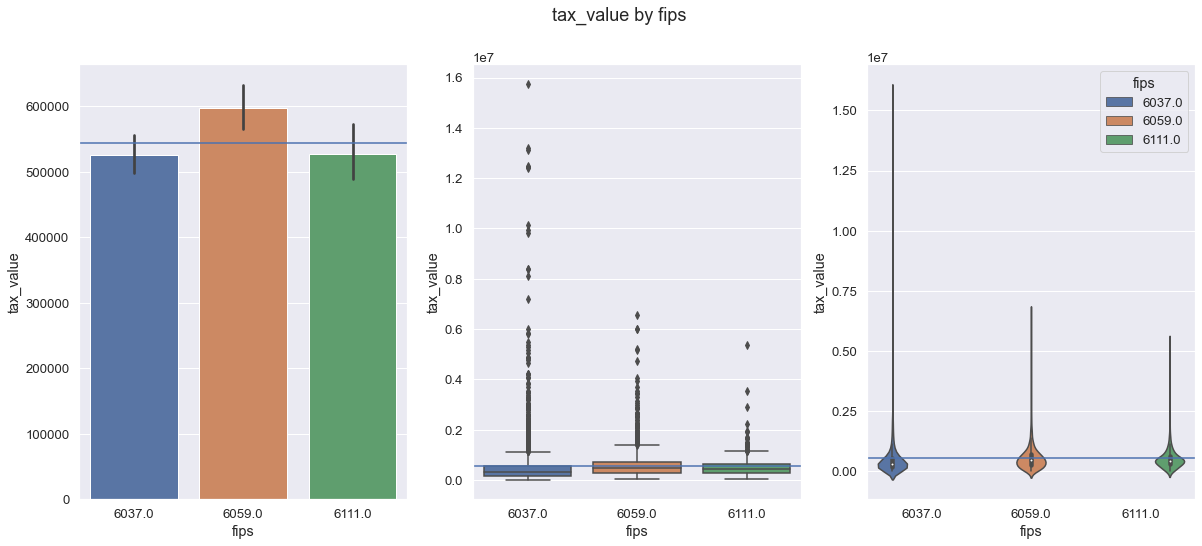

Generating plots tax_value by fireplacecnt


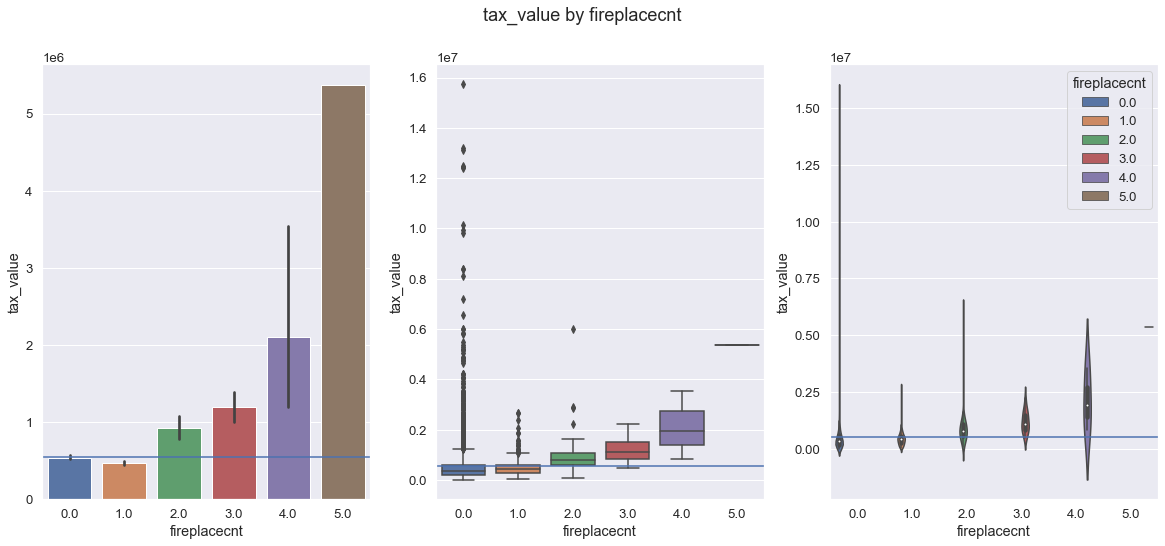

Generating plots tax_value by fullbathcnt


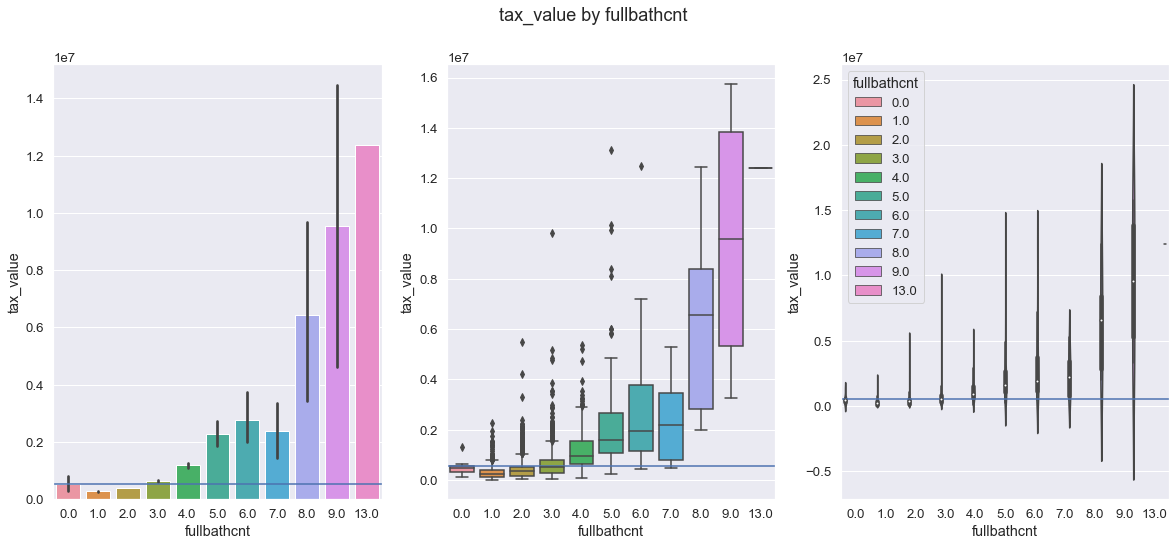

Generating plots tax_value by garage


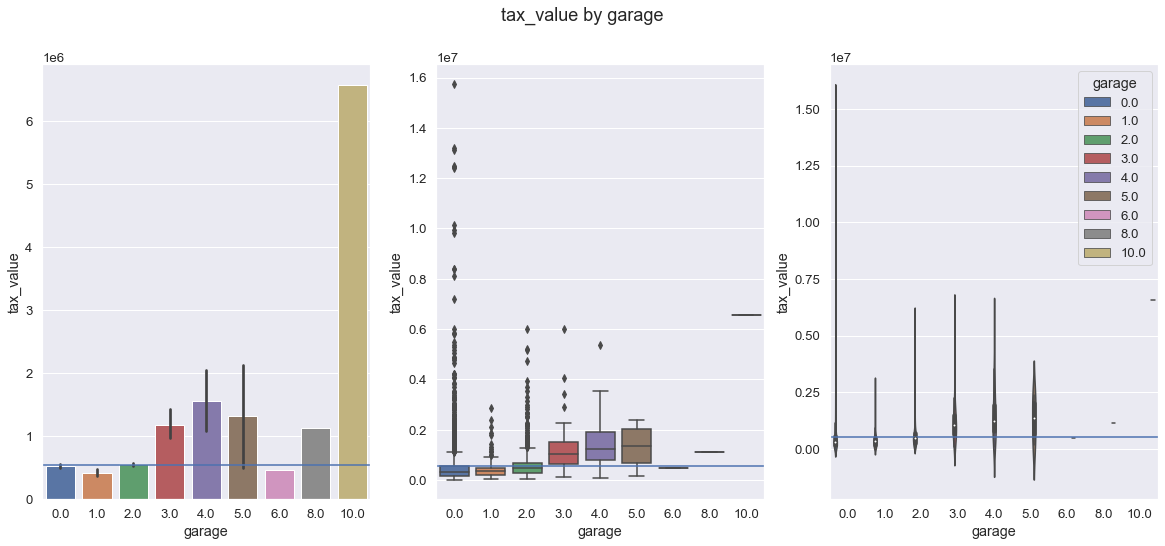

Generating plots tax_value by county


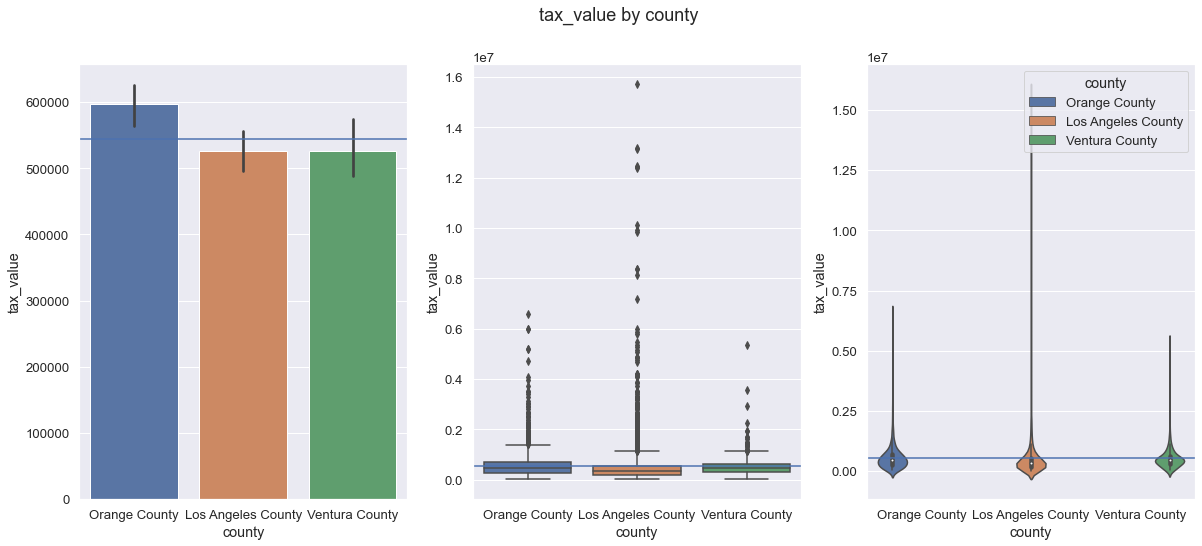

Generating plots tax_value by bathroom_bin


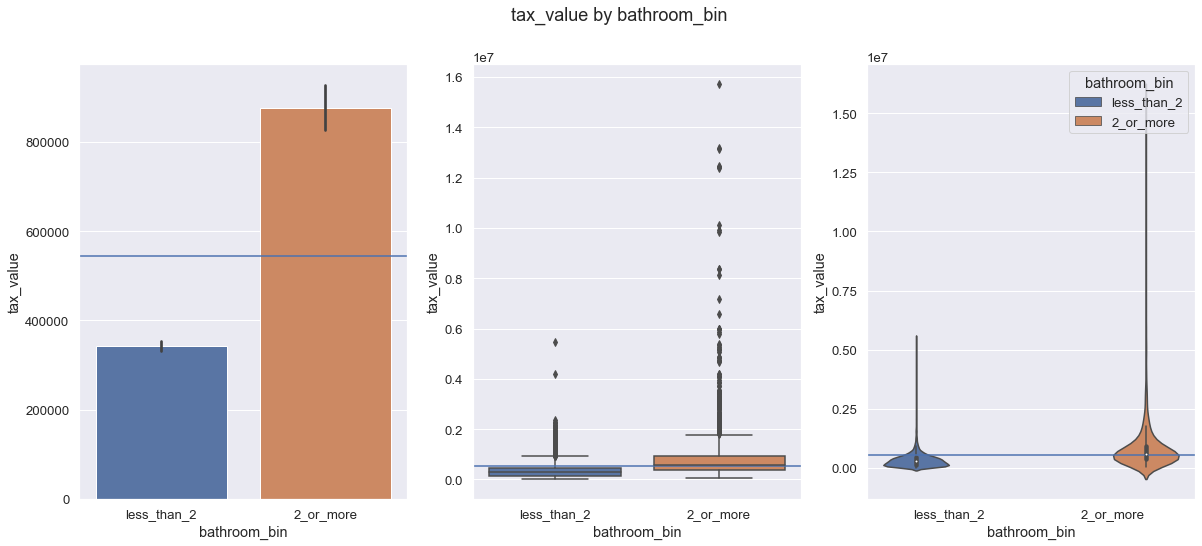

Generating plots tax_value by bedroom_bin


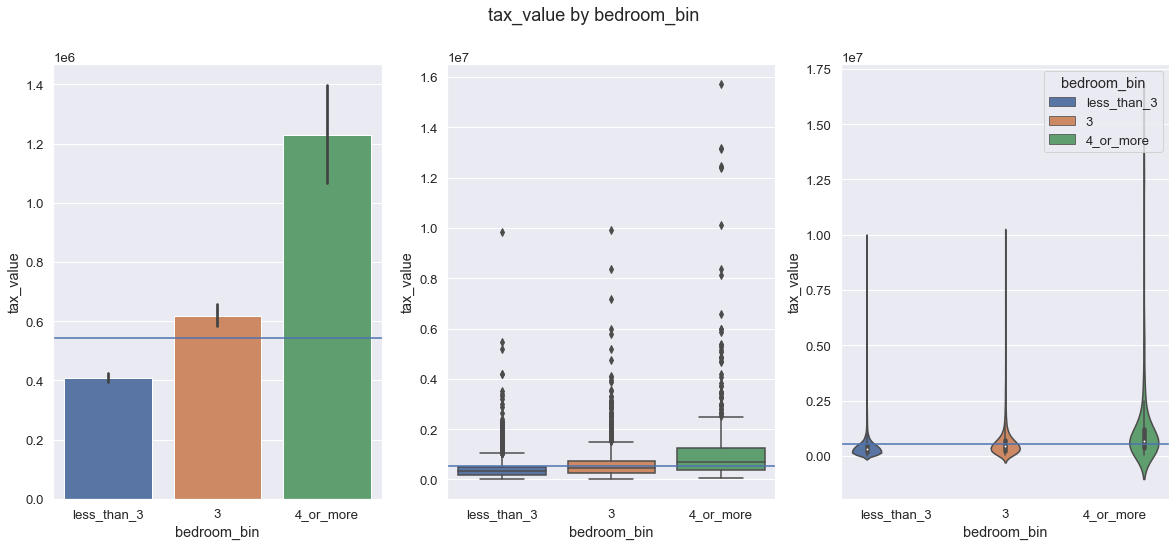

Generating plots tax_value by age_bin


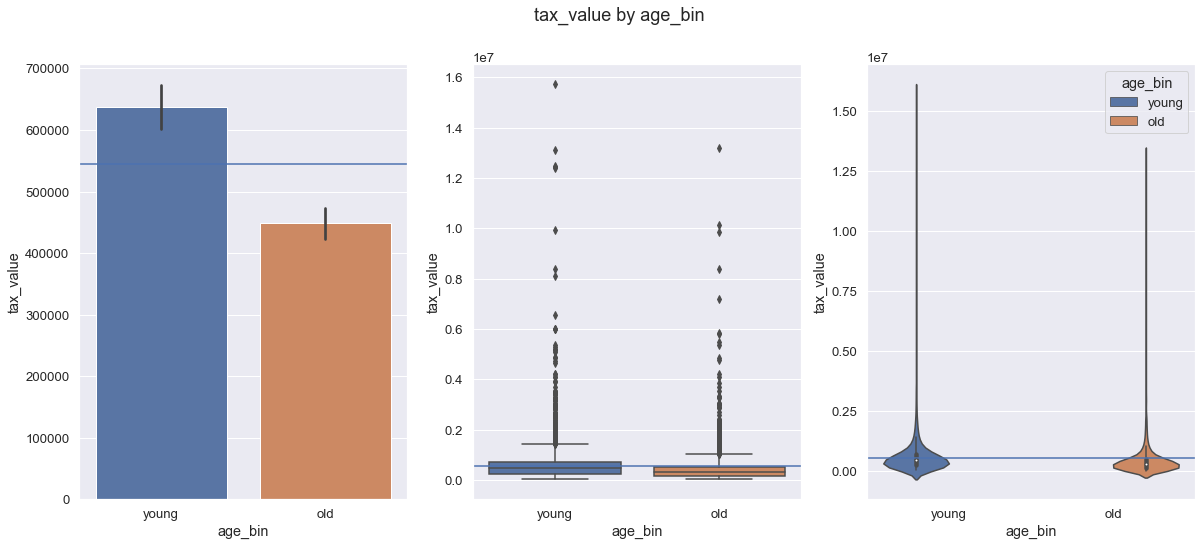

Generating plots tax_value by is_la


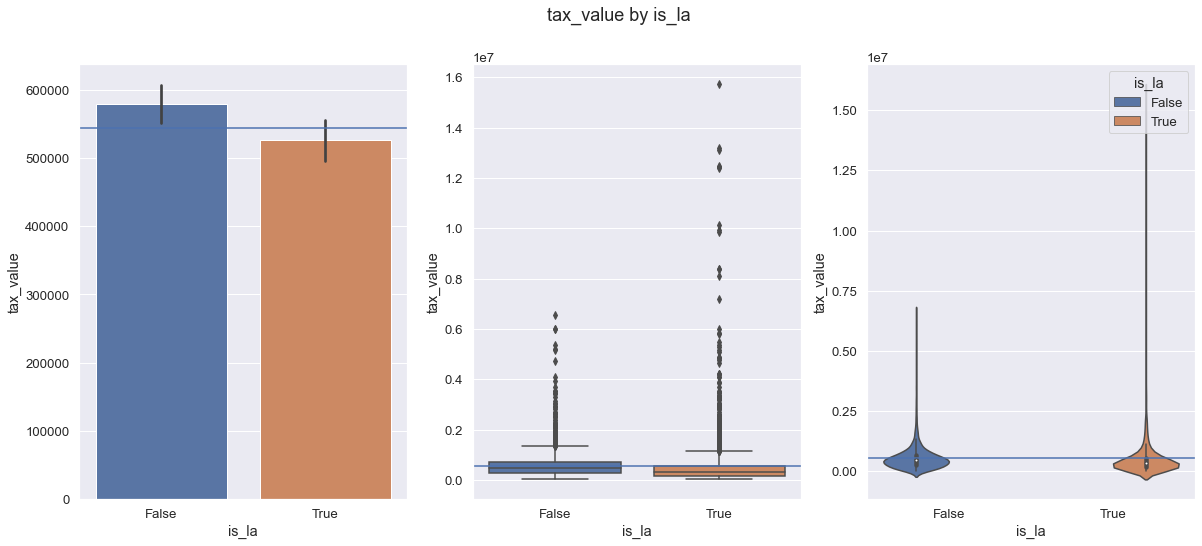

Generating plots age by bedroom


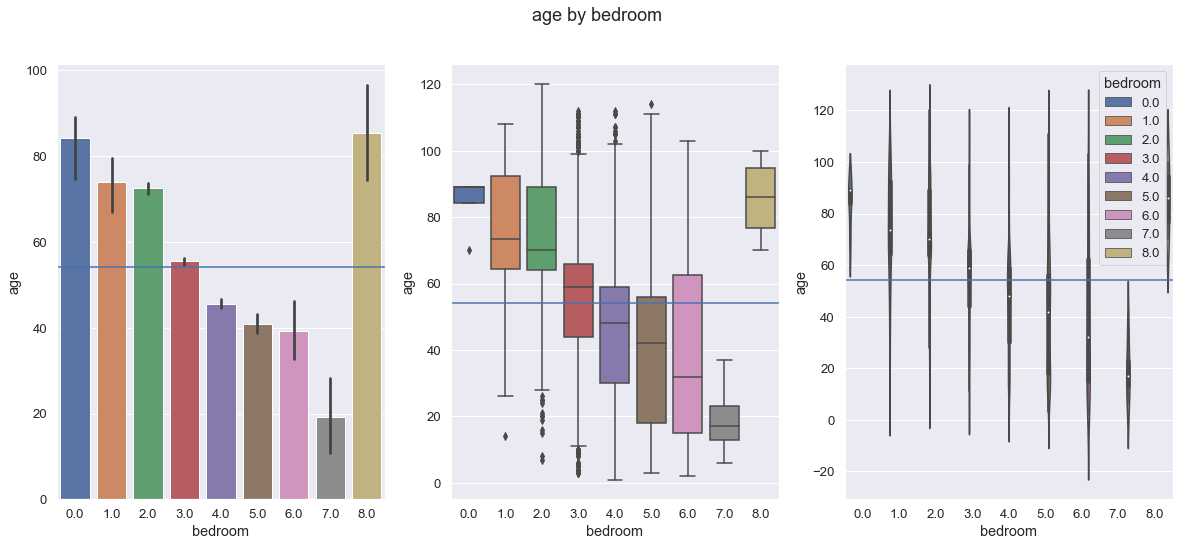

Generating plots age by bathroom


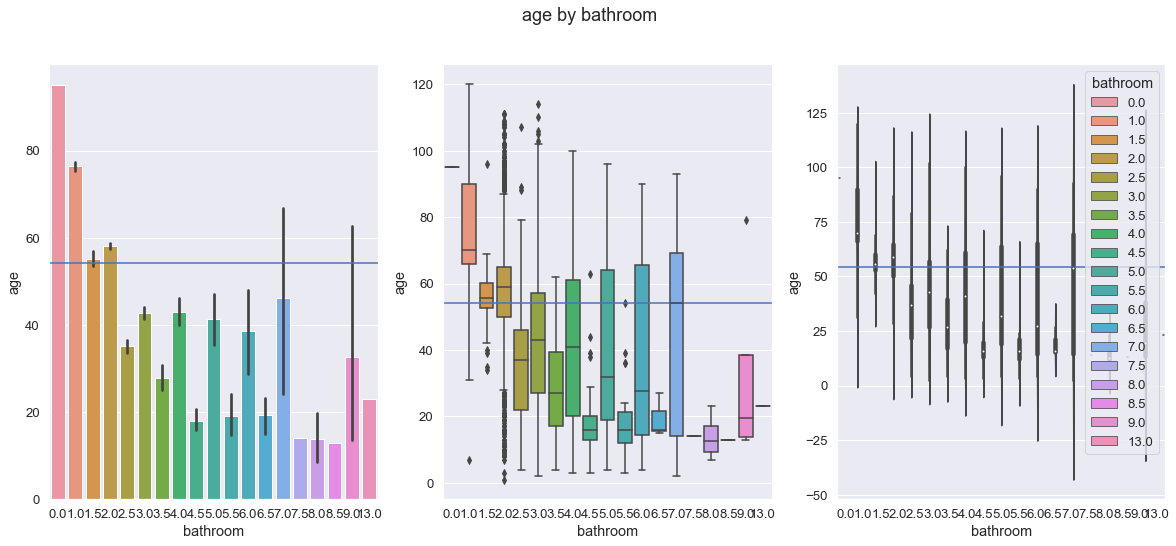

Generating plots age by condition


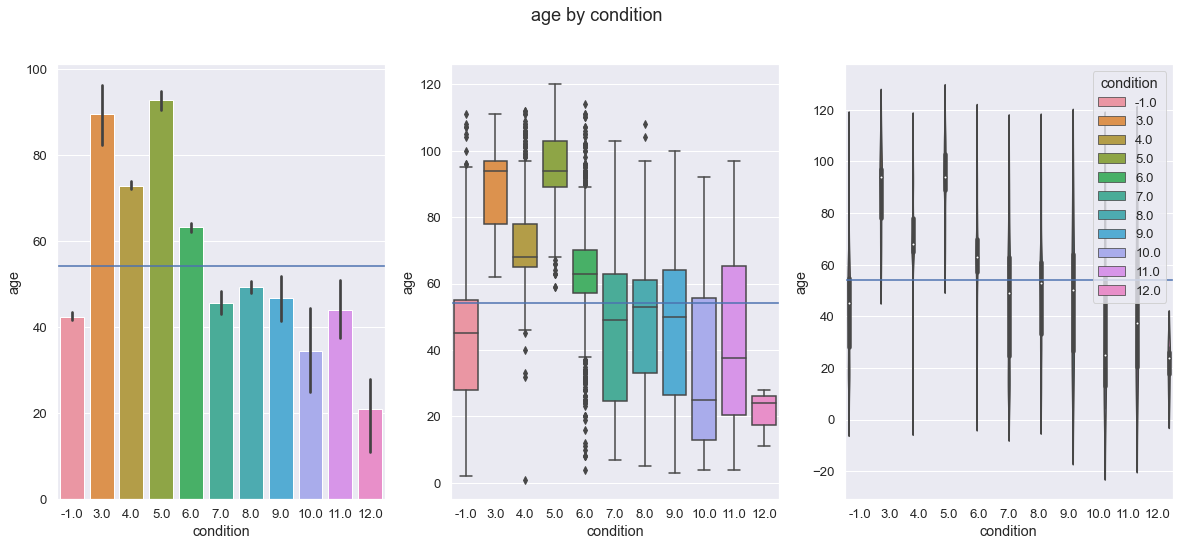

Generating plots age by fips


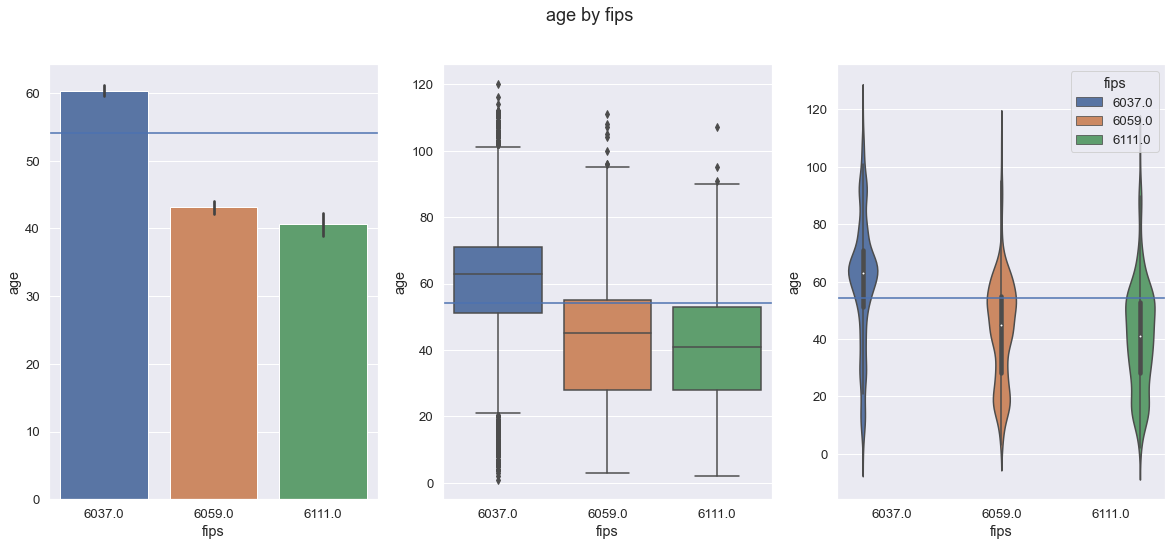

Generating plots age by fireplacecnt


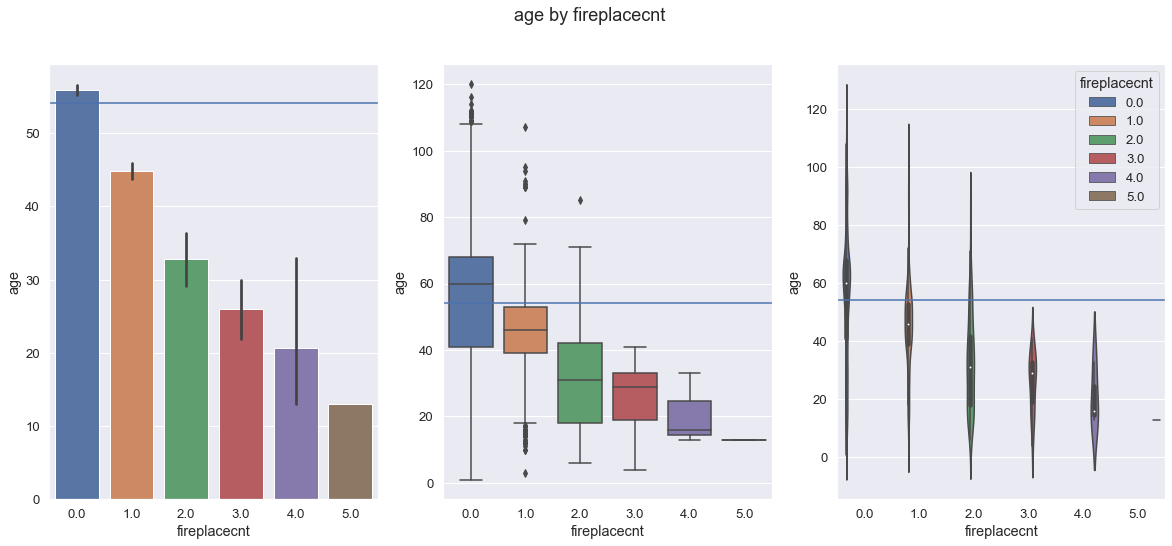

Generating plots age by fullbathcnt


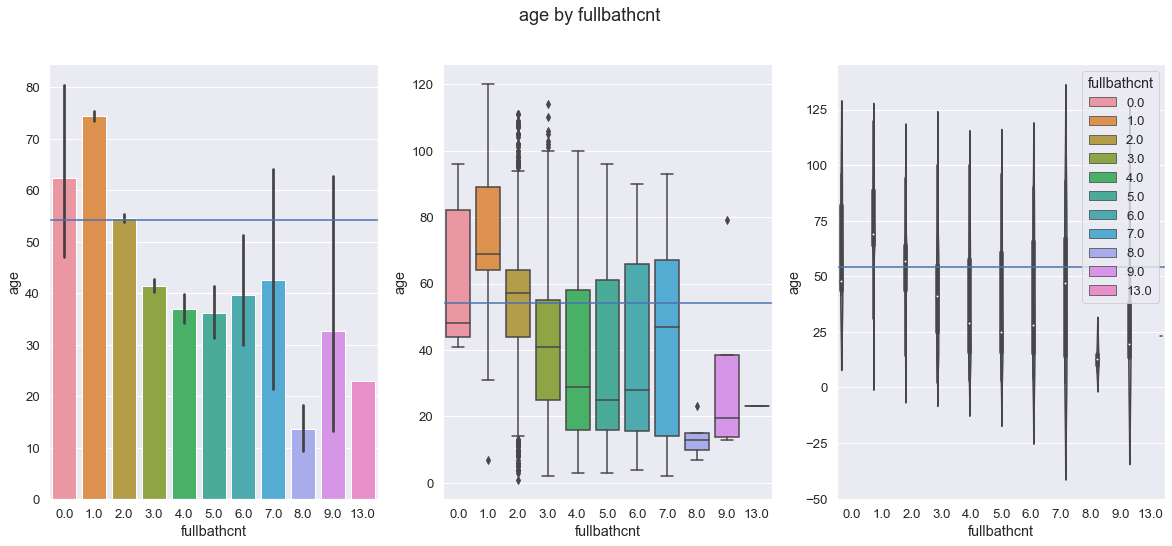

Generating plots age by garage


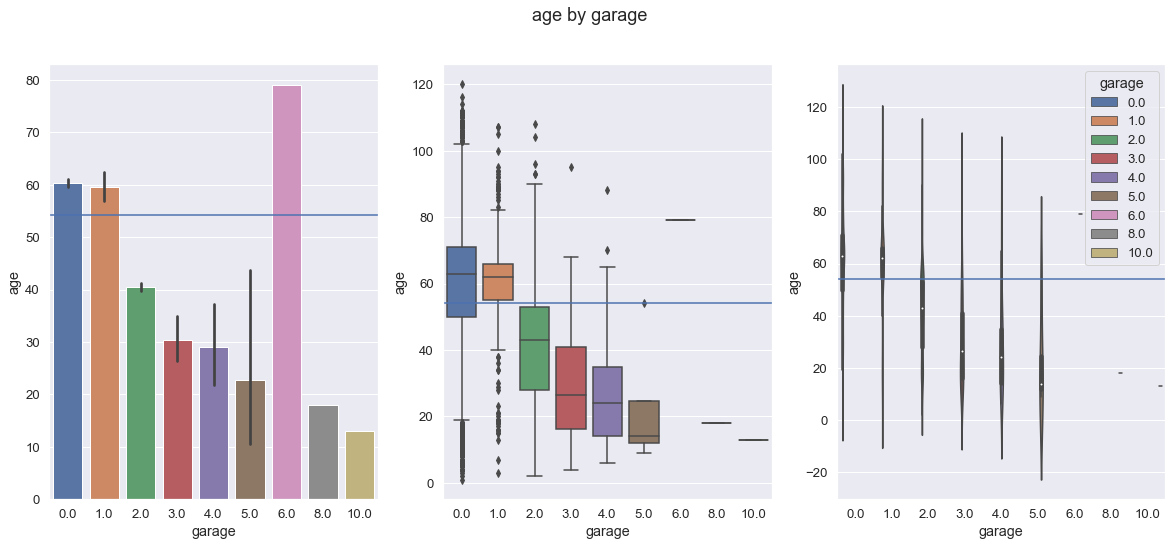

Generating plots age by county


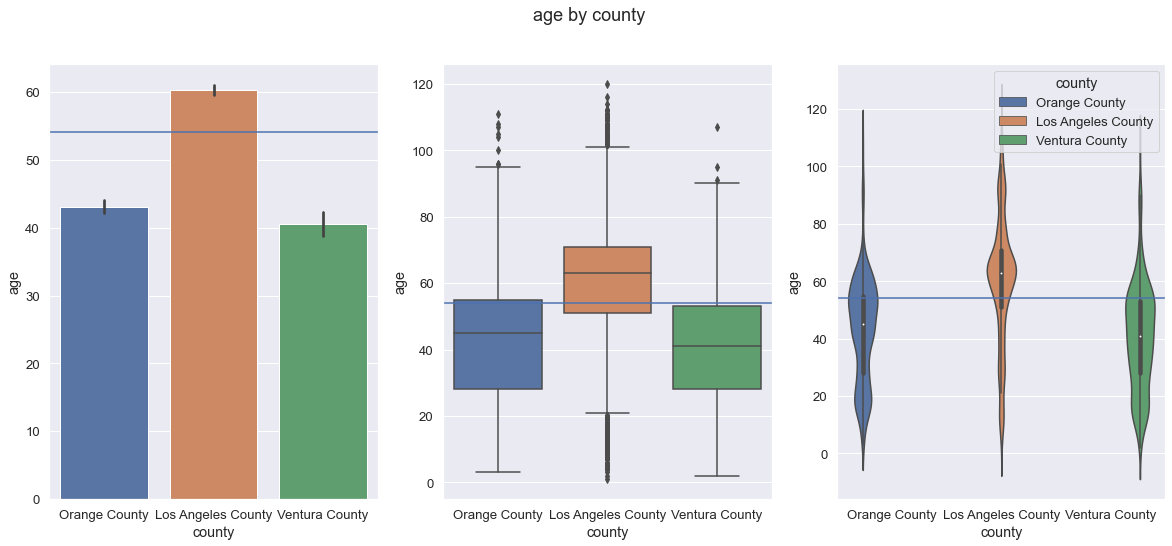

Generating plots age by bathroom_bin


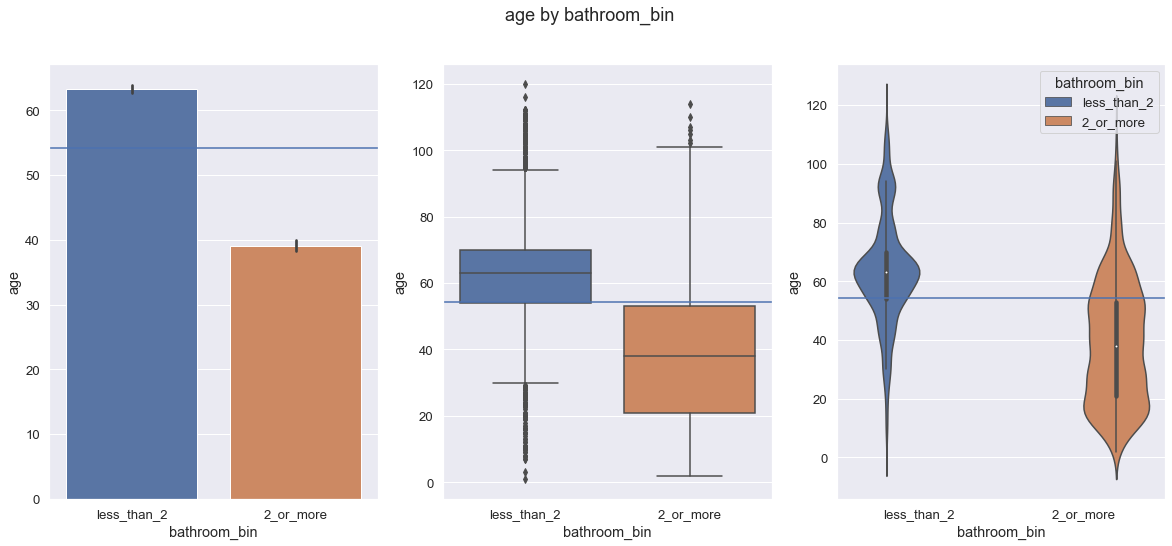

Generating plots age by bedroom_bin


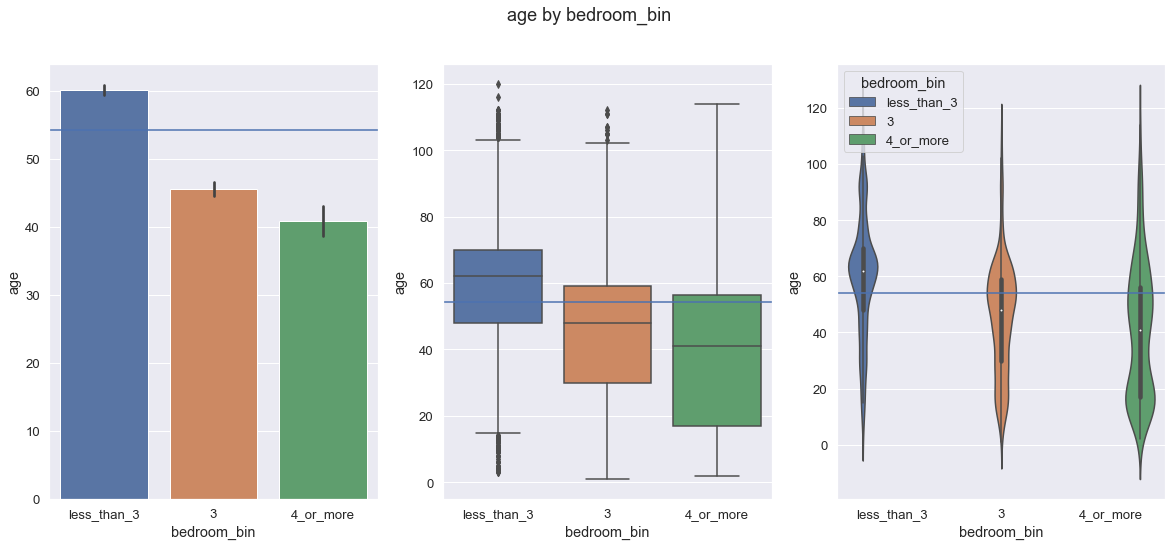

Generating plots age by age_bin


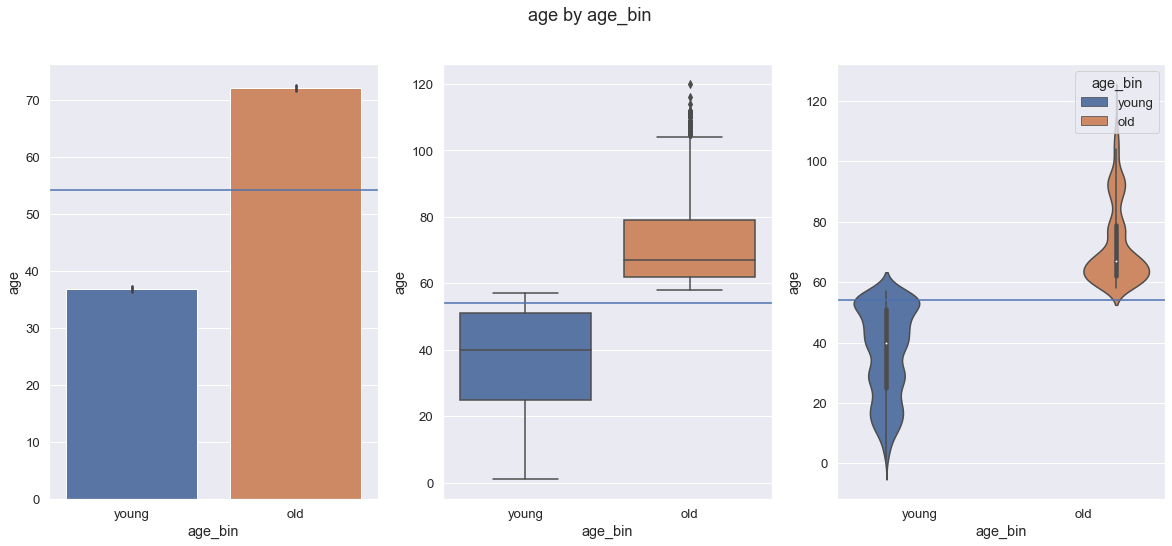

Generating plots age by is_la


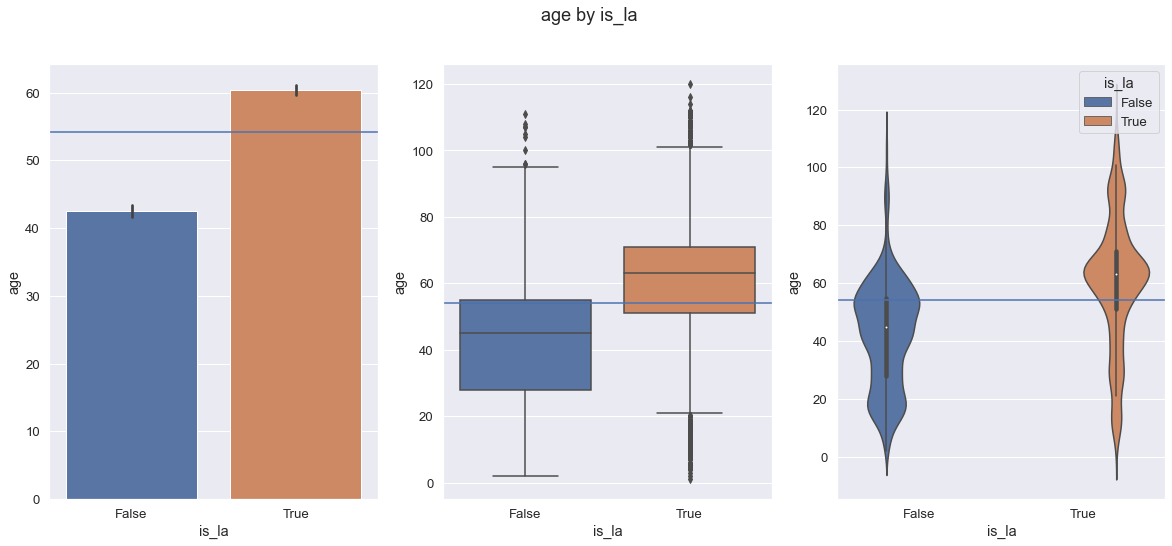

Generating plots living_space by bedroom


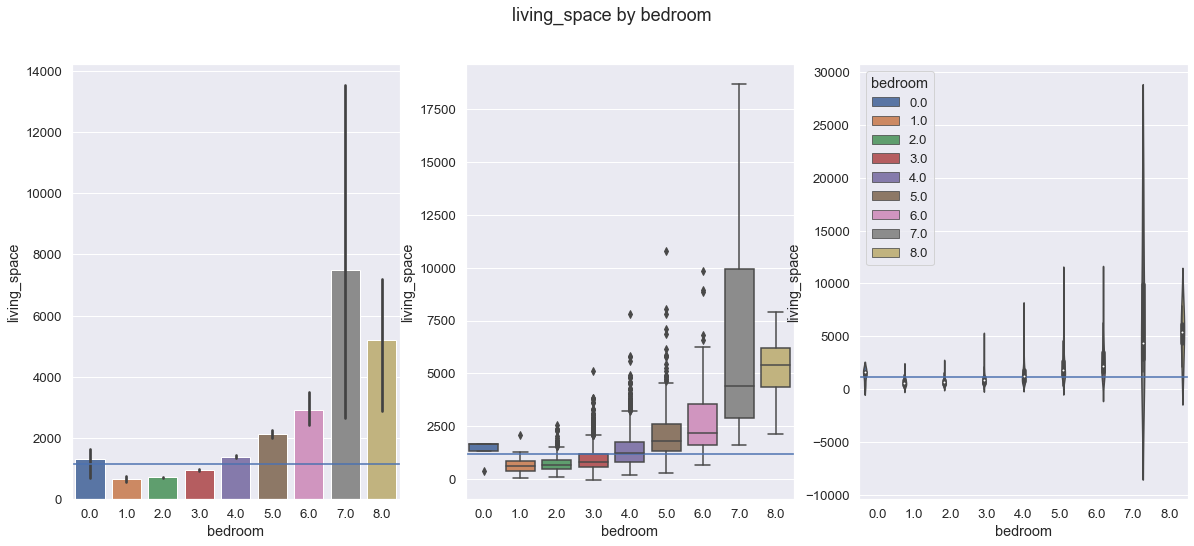

Generating plots living_space by bathroom


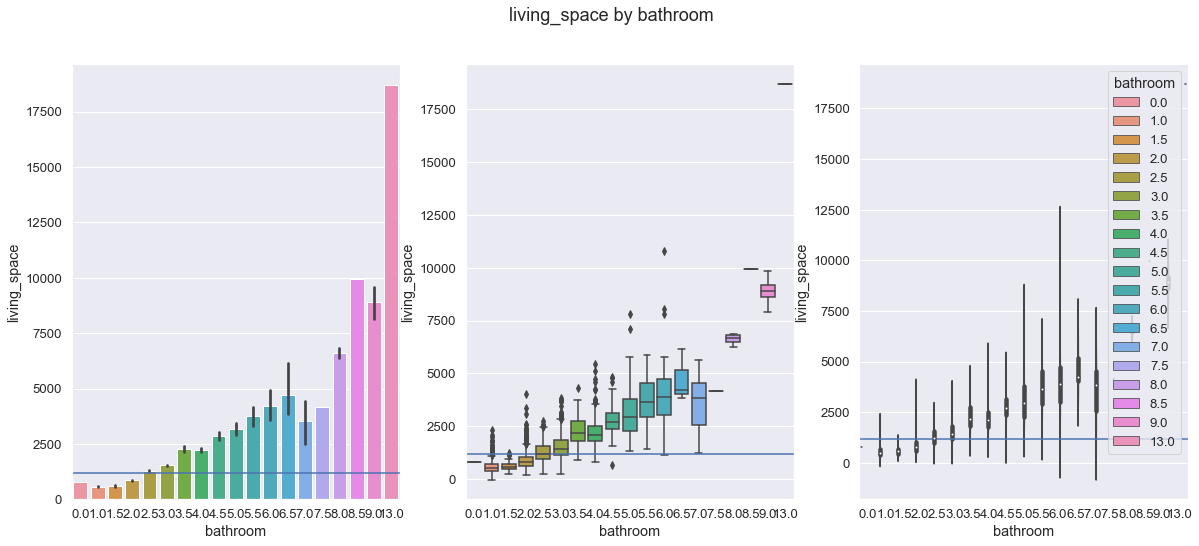

Generating plots living_space by condition


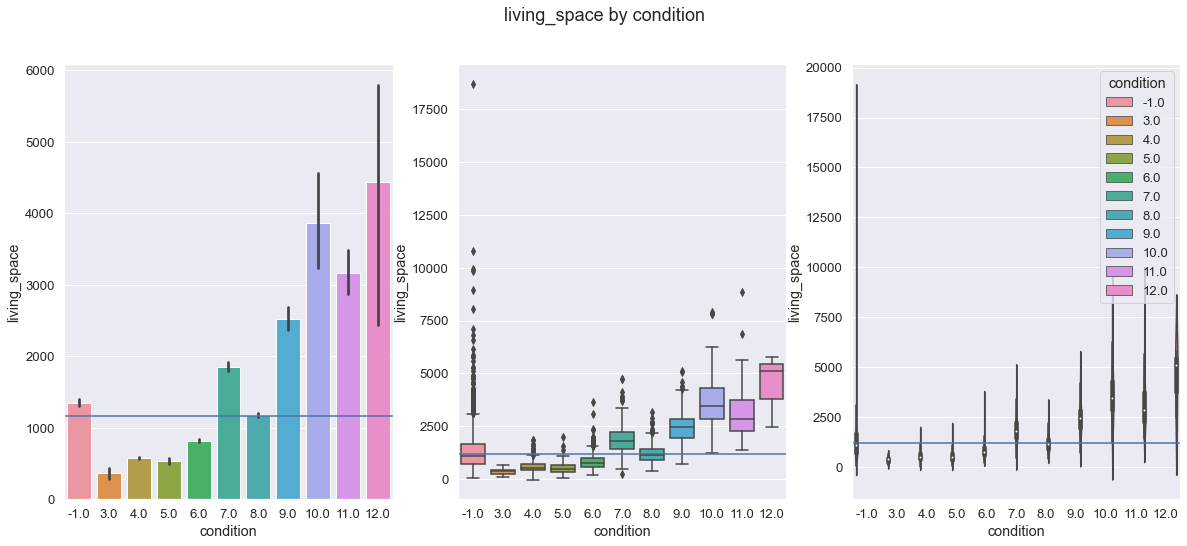

Generating plots living_space by fips


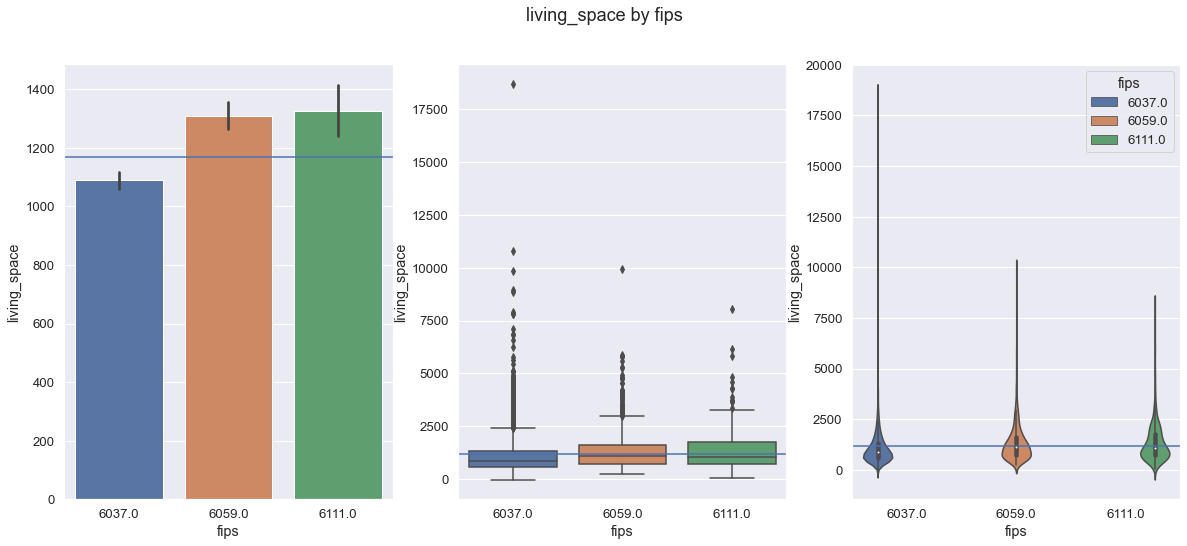

Generating plots living_space by fireplacecnt


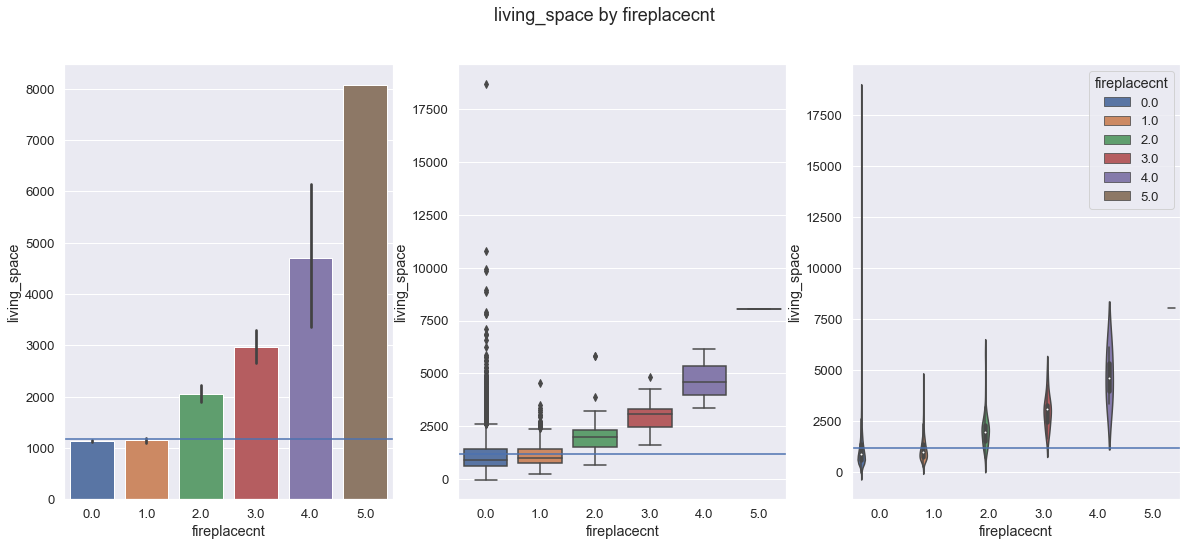

Generating plots living_space by fullbathcnt


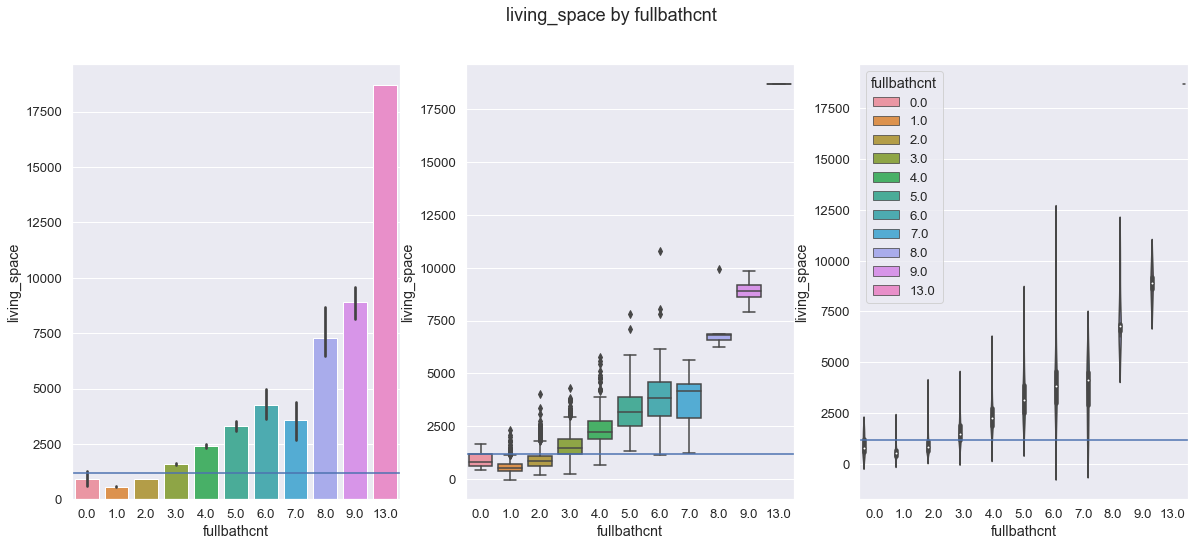

Generating plots living_space by garage


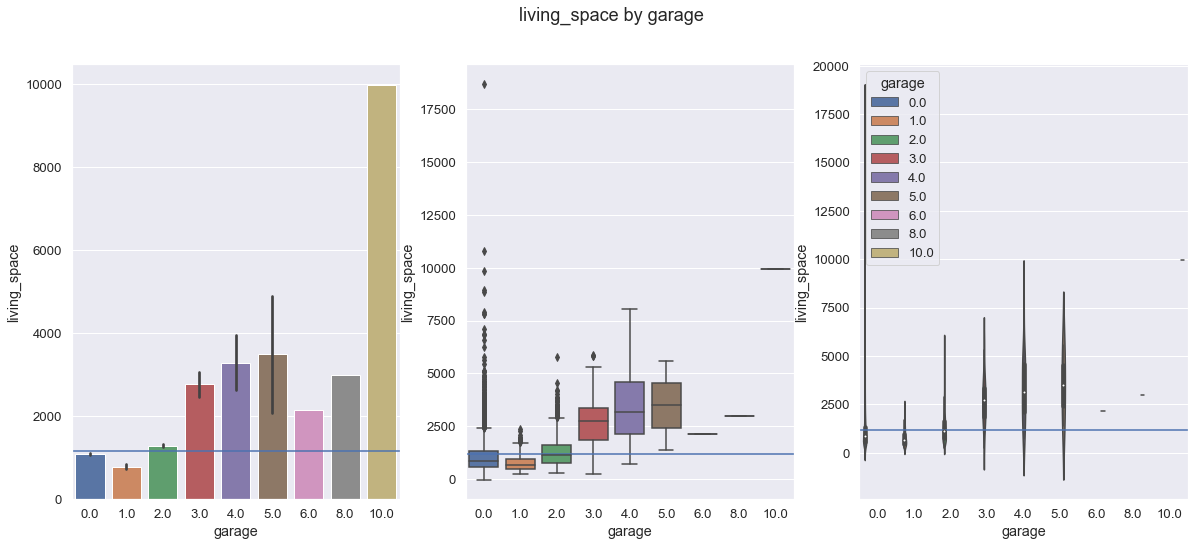

Generating plots living_space by county


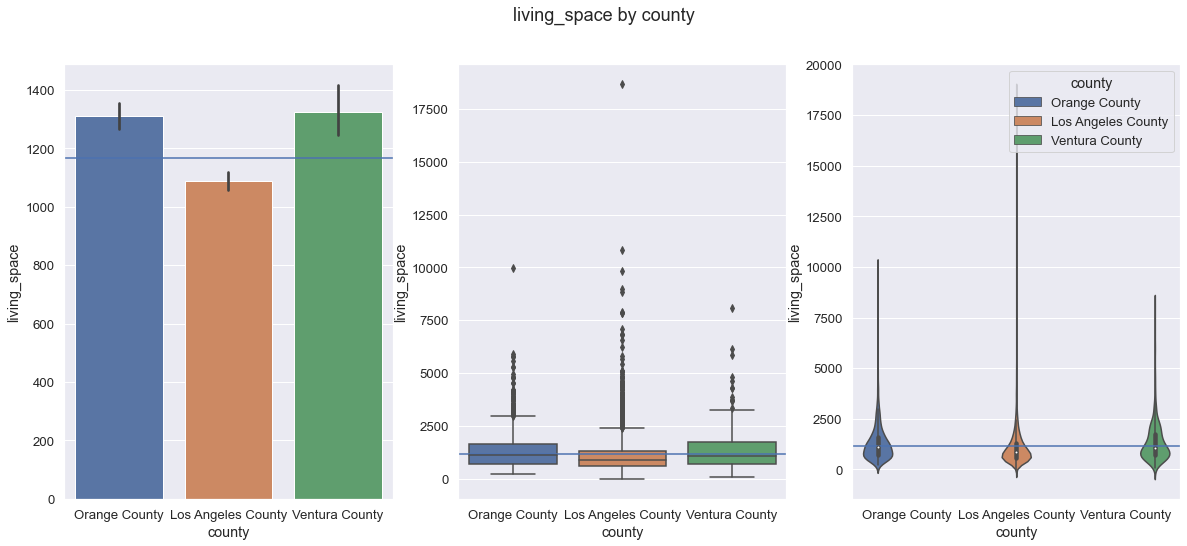

Generating plots living_space by bathroom_bin


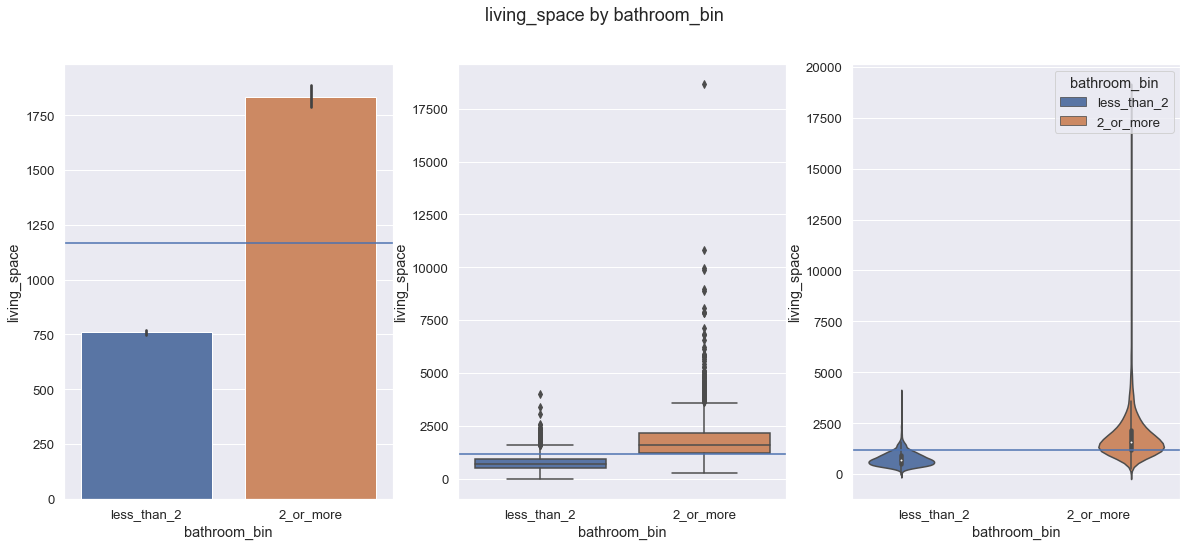

Generating plots living_space by bedroom_bin


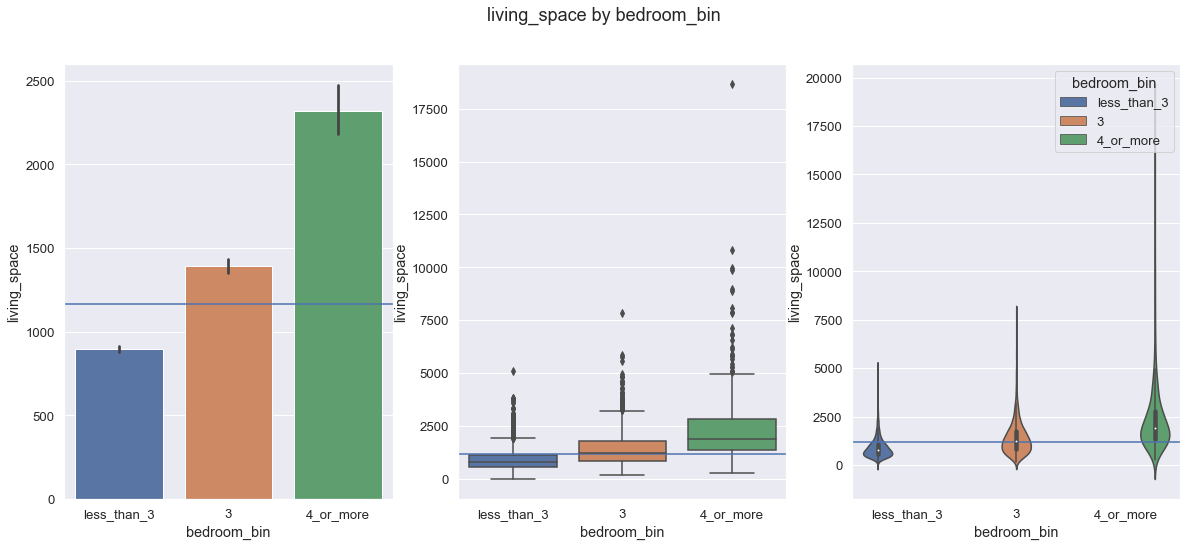

Generating plots living_space by age_bin


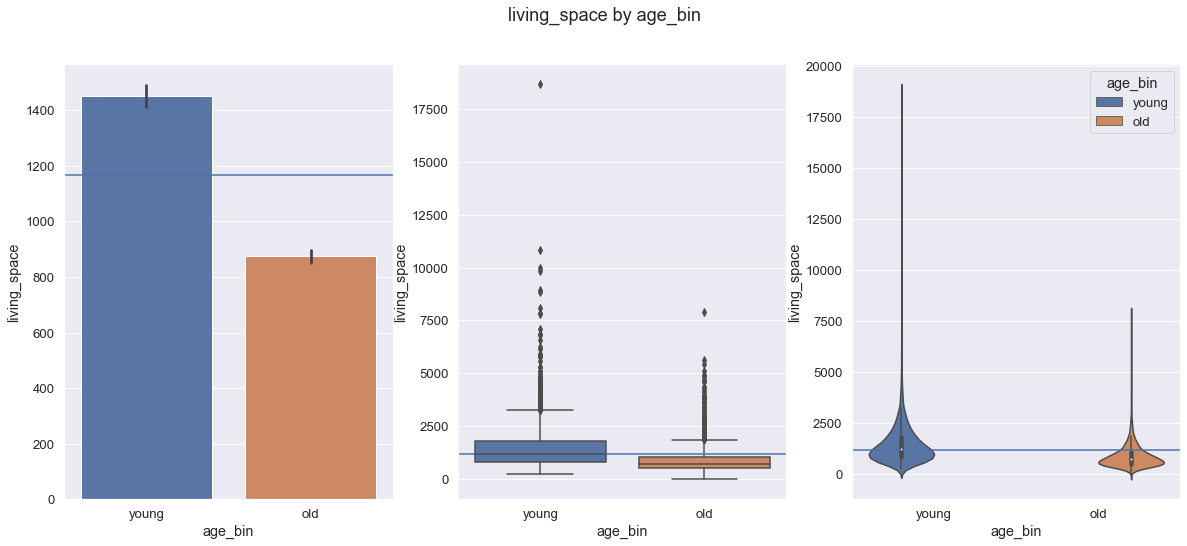

Generating plots living_space by is_la


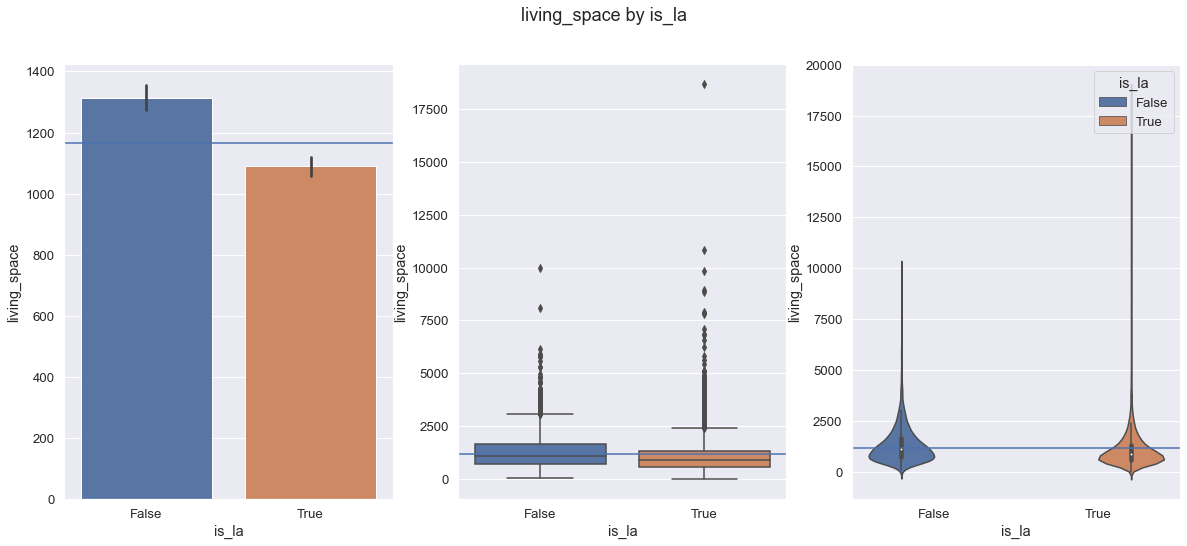

Generating plots acres by bedroom


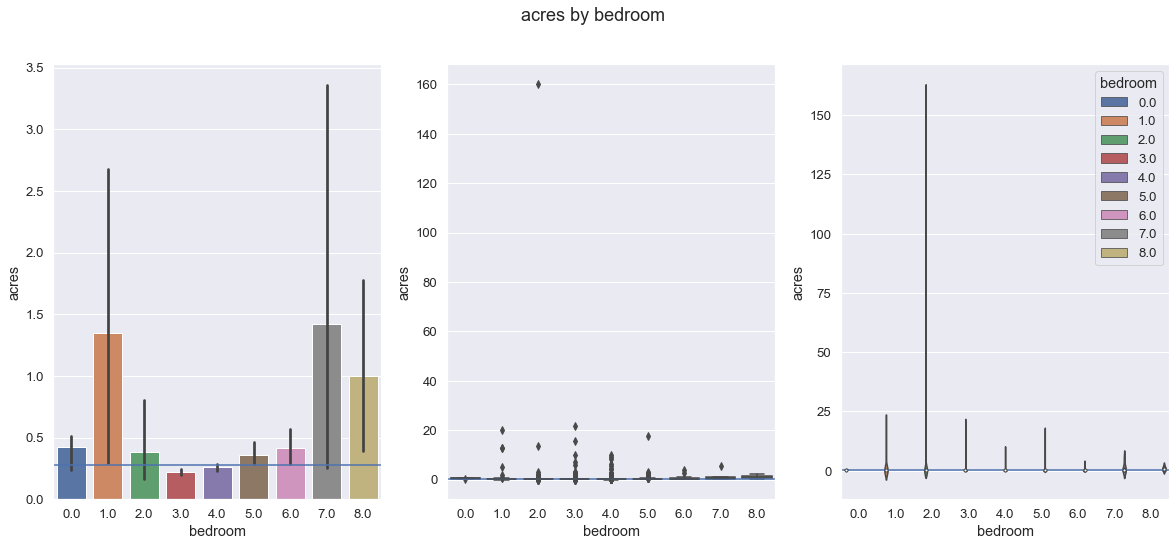

Generating plots acres by bathroom


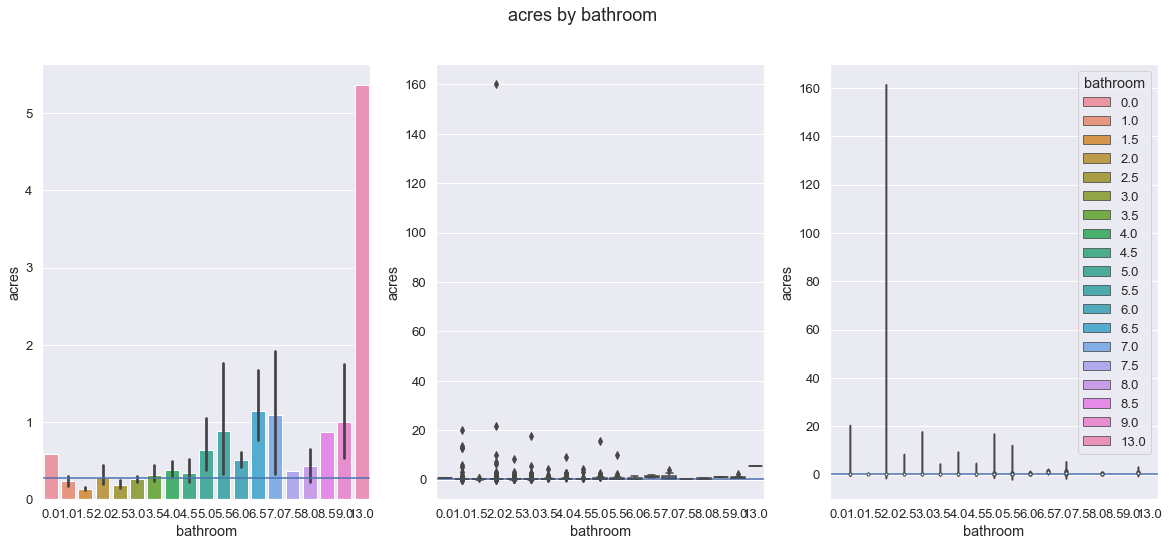

Generating plots acres by condition


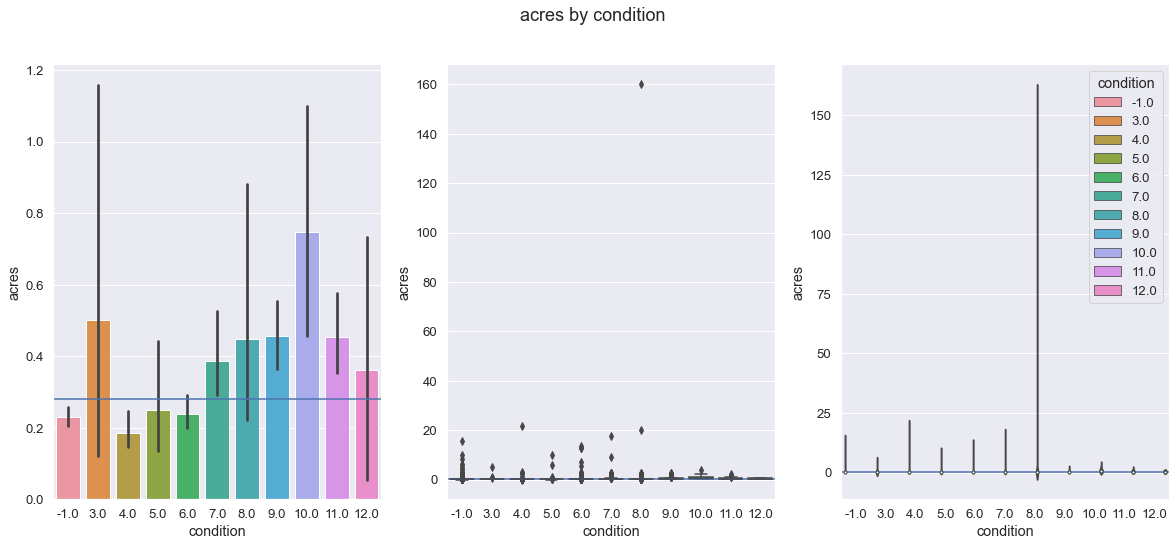

Generating plots acres by fips


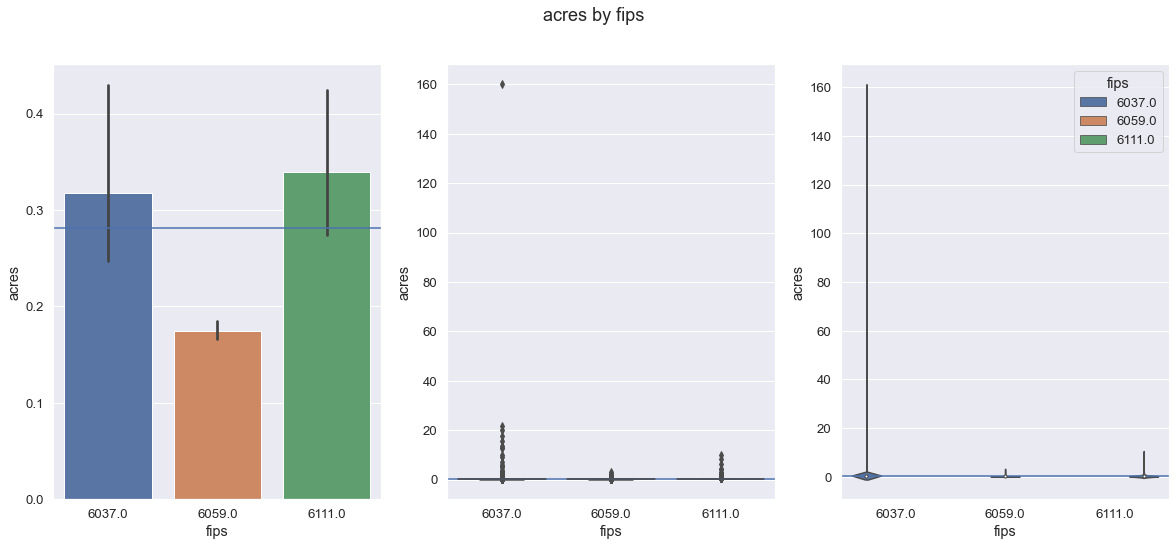

Generating plots acres by fireplacecnt


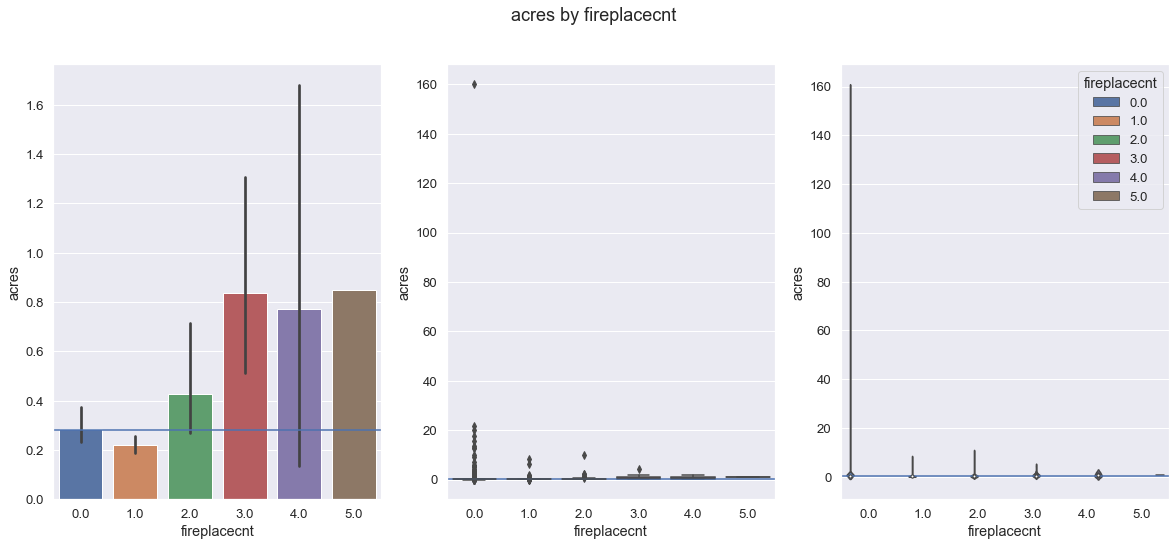

Generating plots acres by fullbathcnt


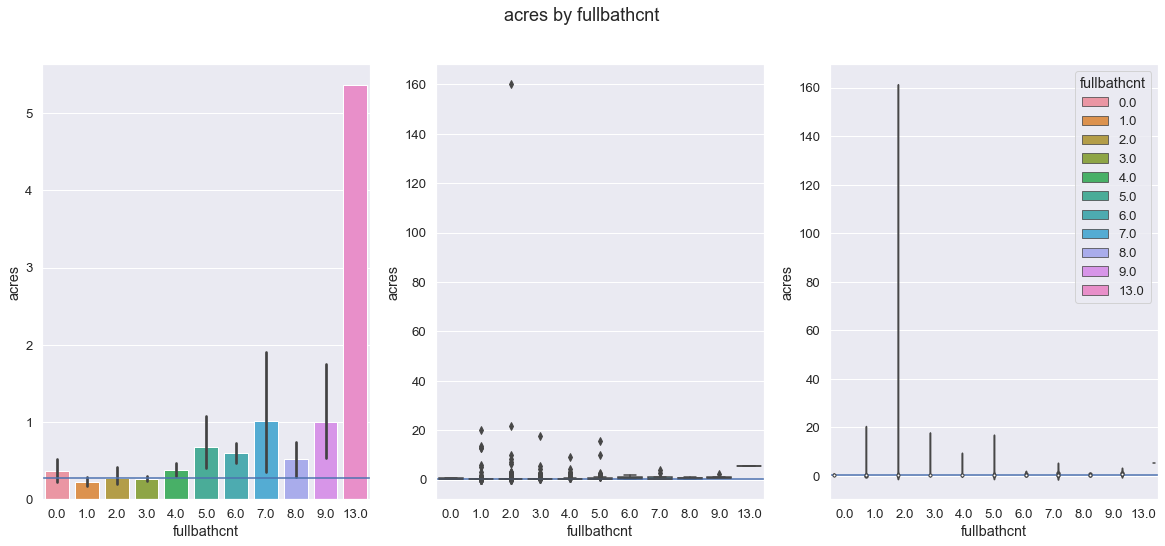

Generating plots acres by garage


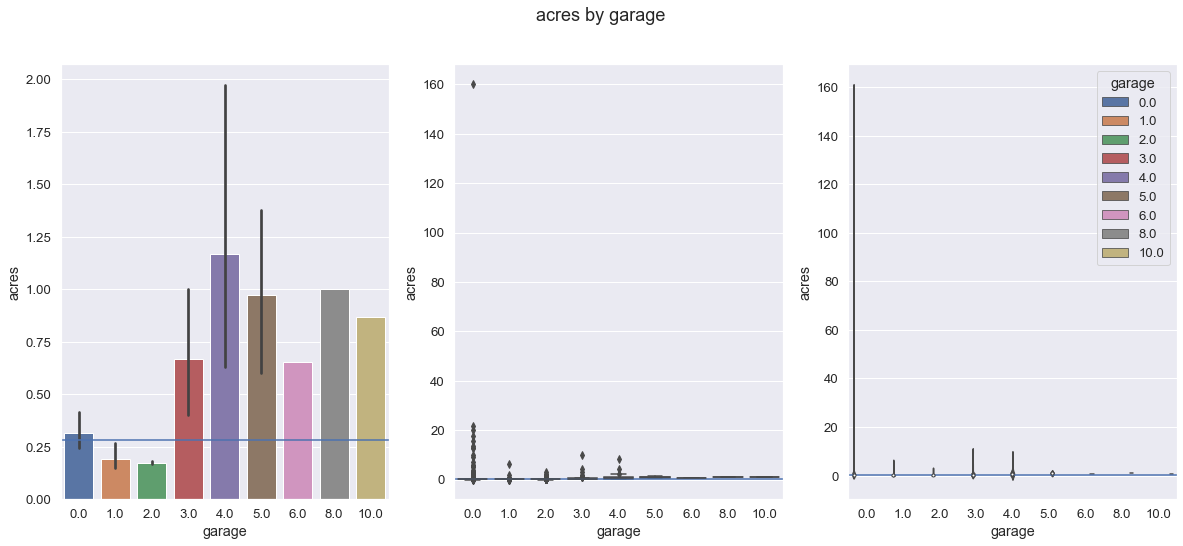

Generating plots acres by county


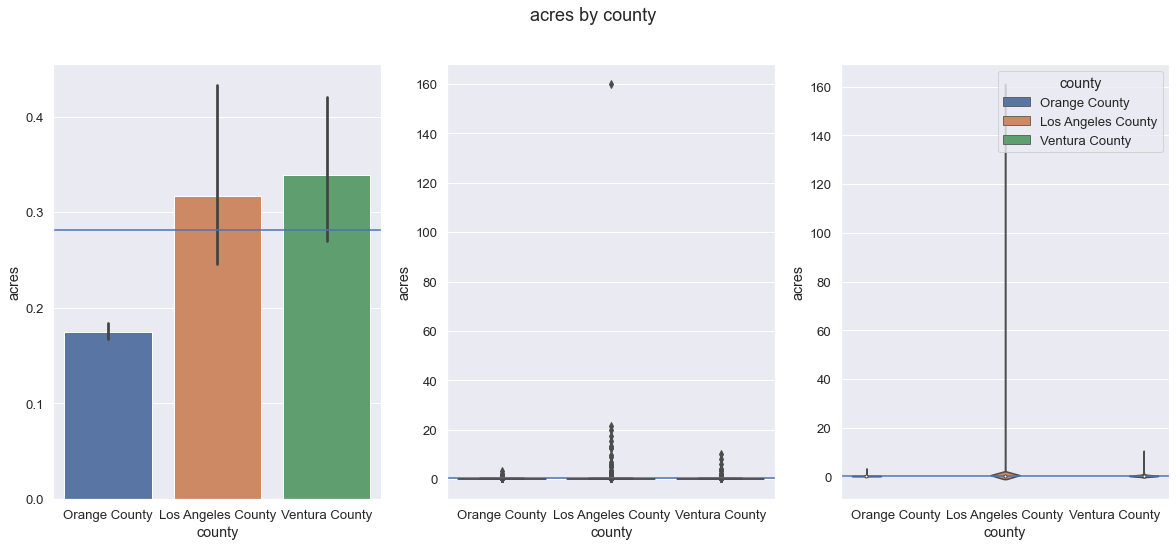

Generating plots acres by bathroom_bin


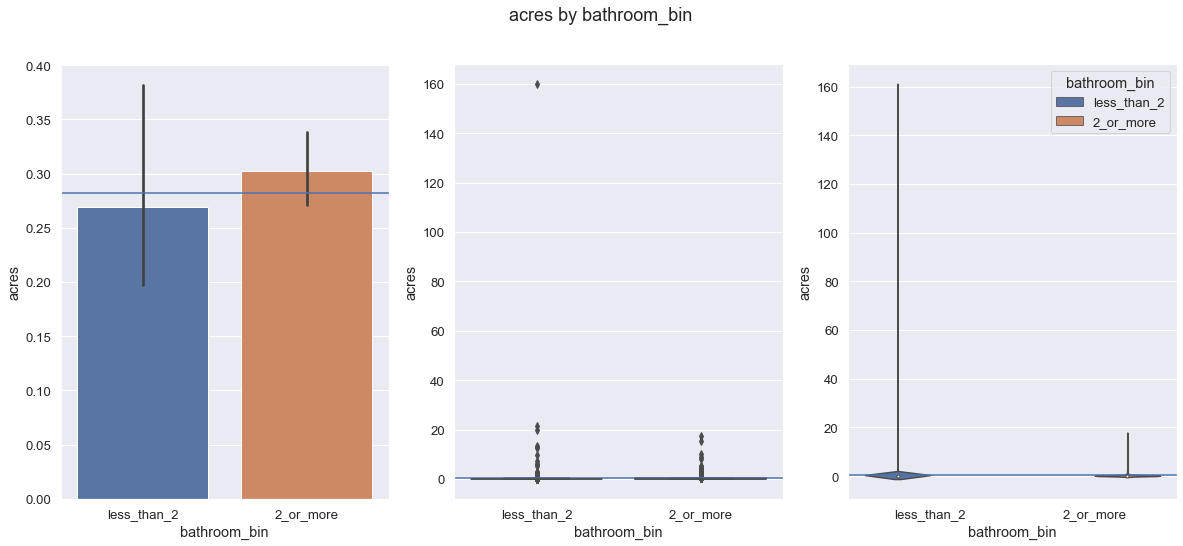

Generating plots acres by bedroom_bin


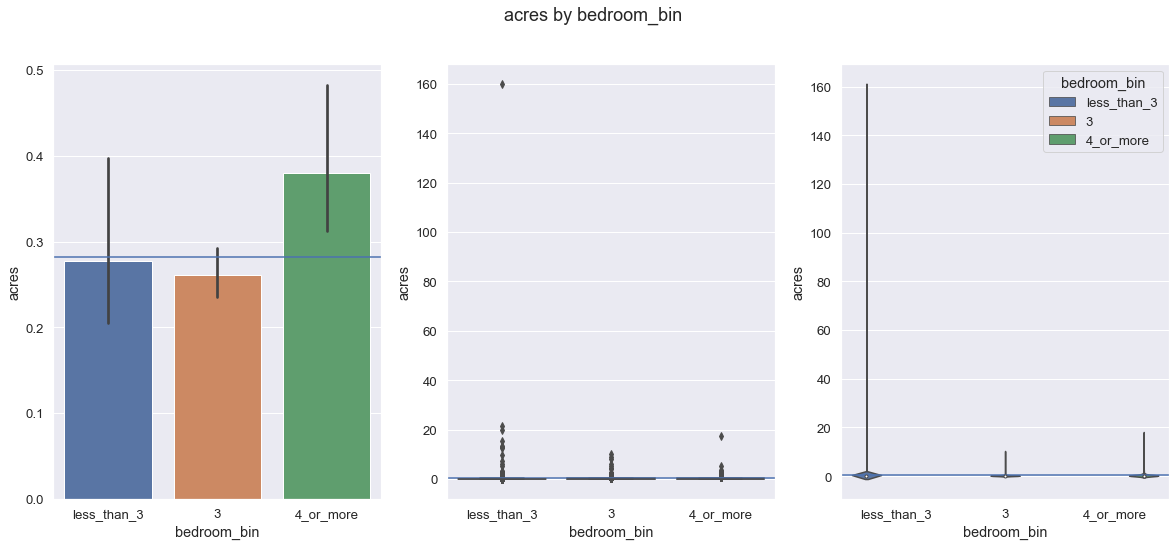

Generating plots acres by age_bin


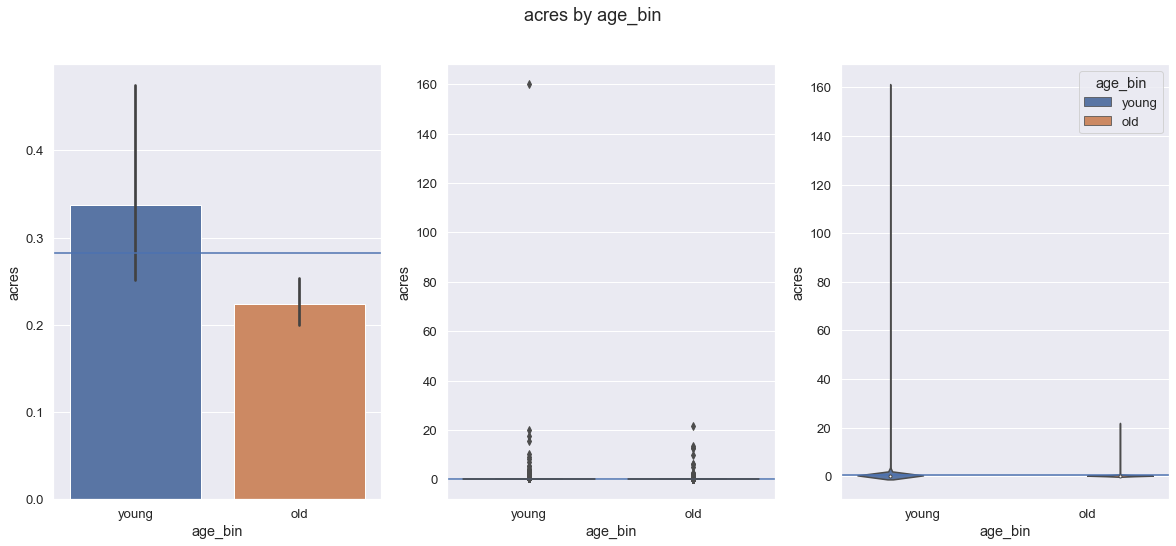

Generating plots acres by is_la


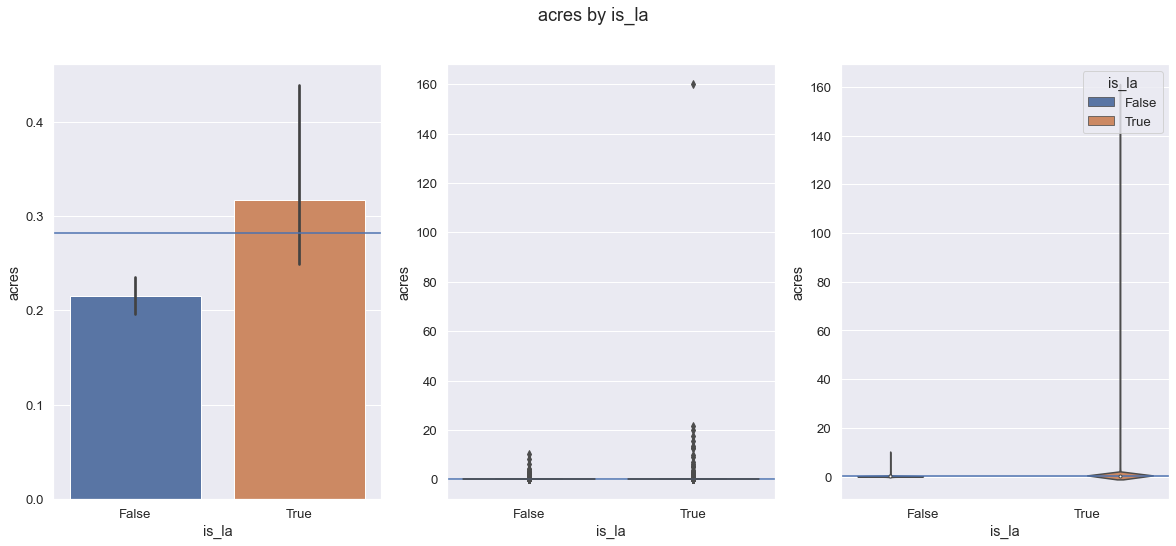

Generating plots structure_dollar_per_sqft by bedroom


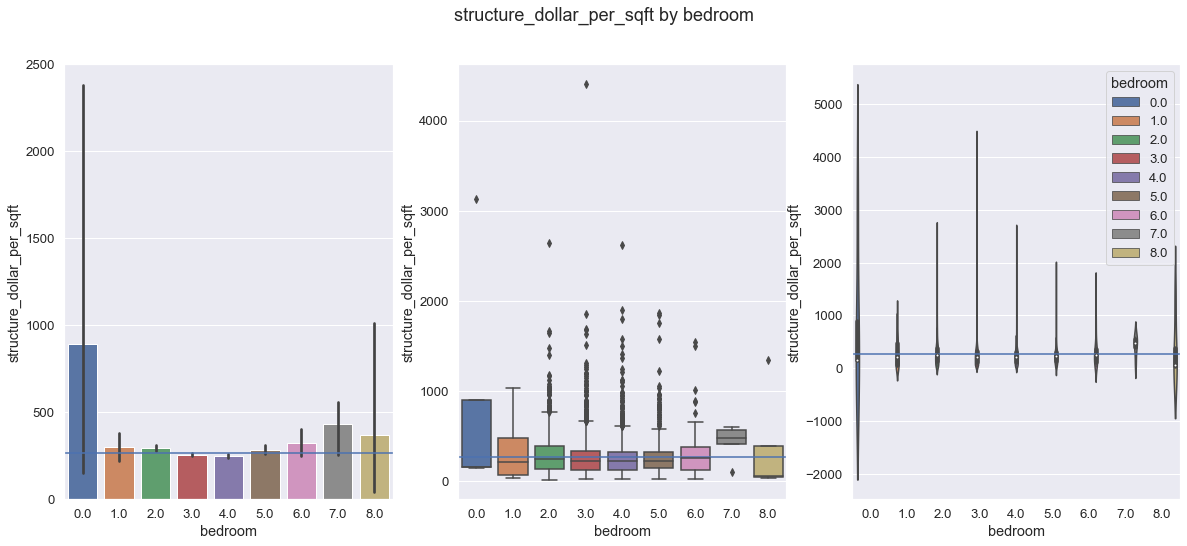

Generating plots structure_dollar_per_sqft by bathroom


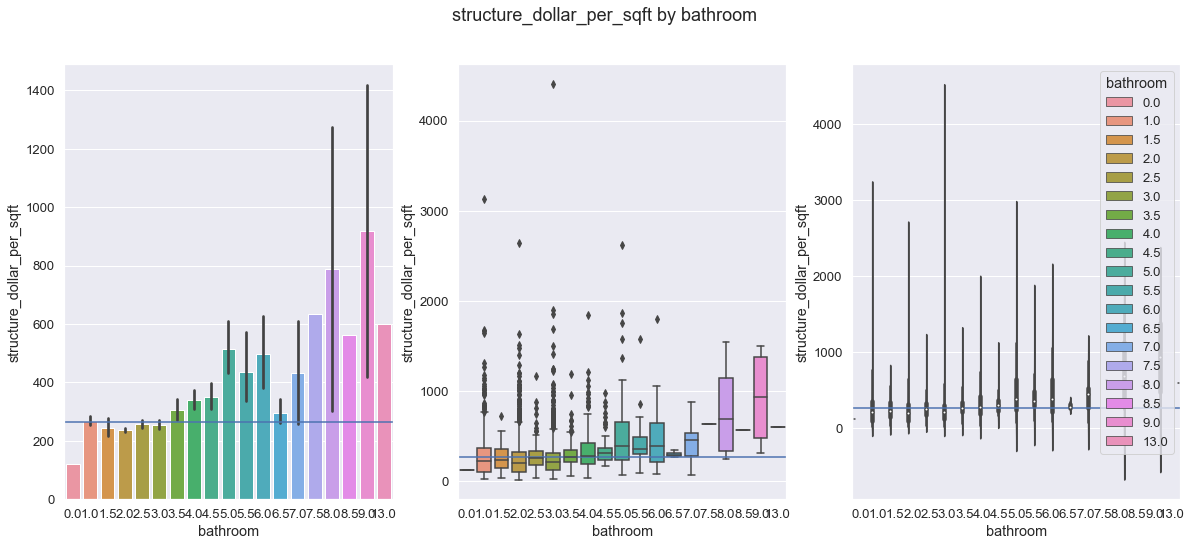

Generating plots structure_dollar_per_sqft by condition


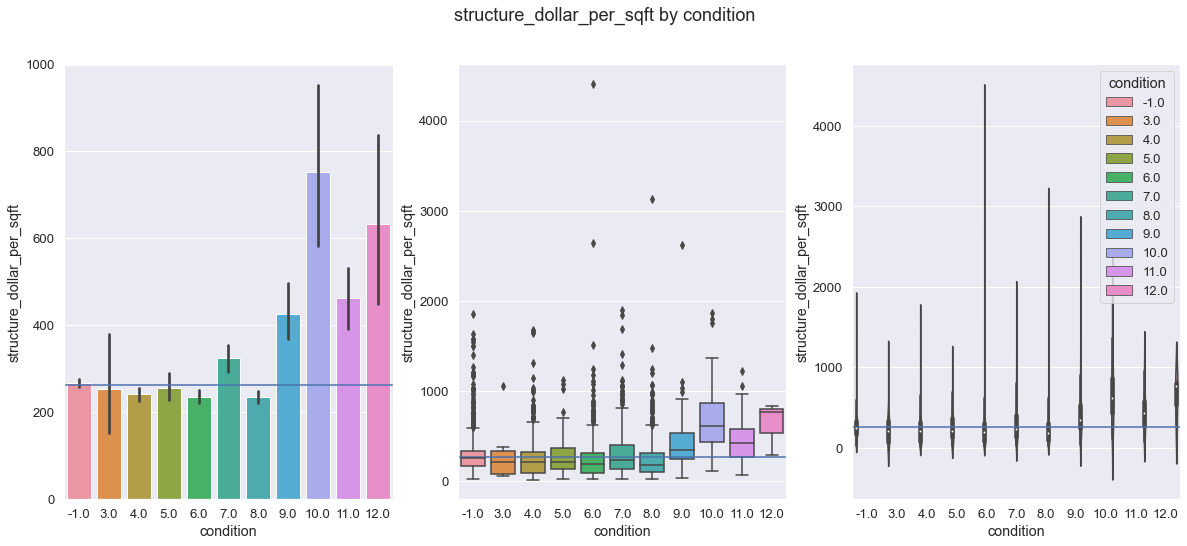

Generating plots structure_dollar_per_sqft by fips


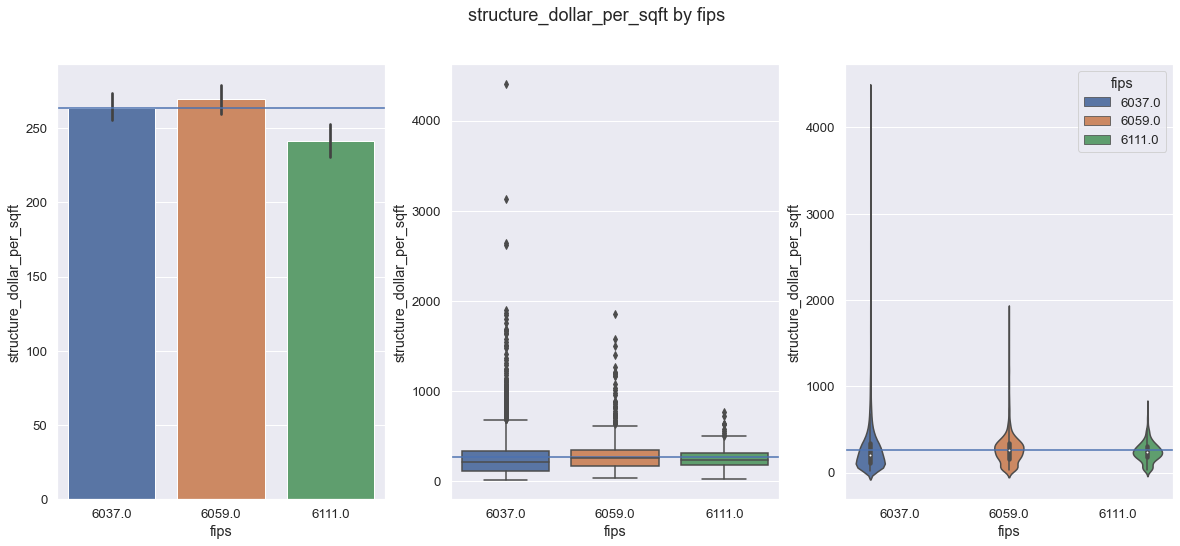

Generating plots structure_dollar_per_sqft by fireplacecnt


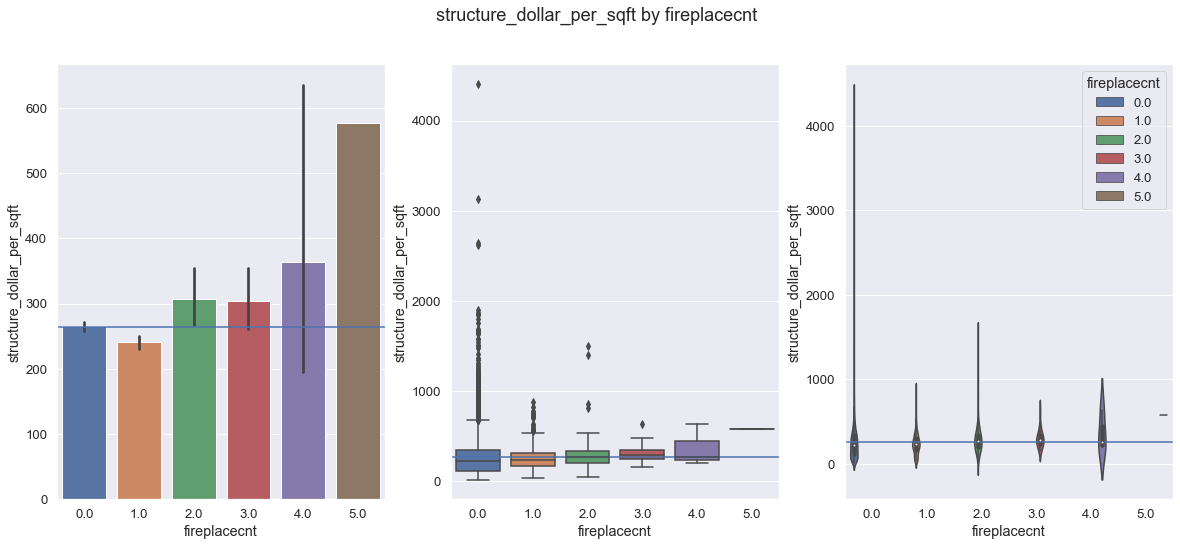

Generating plots structure_dollar_per_sqft by fullbathcnt


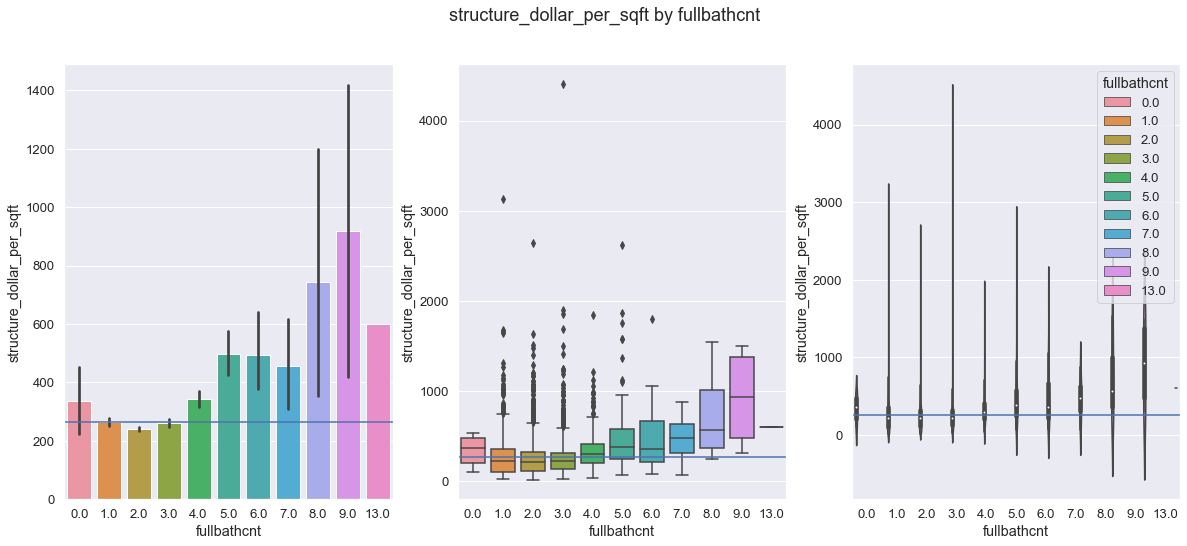

Generating plots structure_dollar_per_sqft by garage


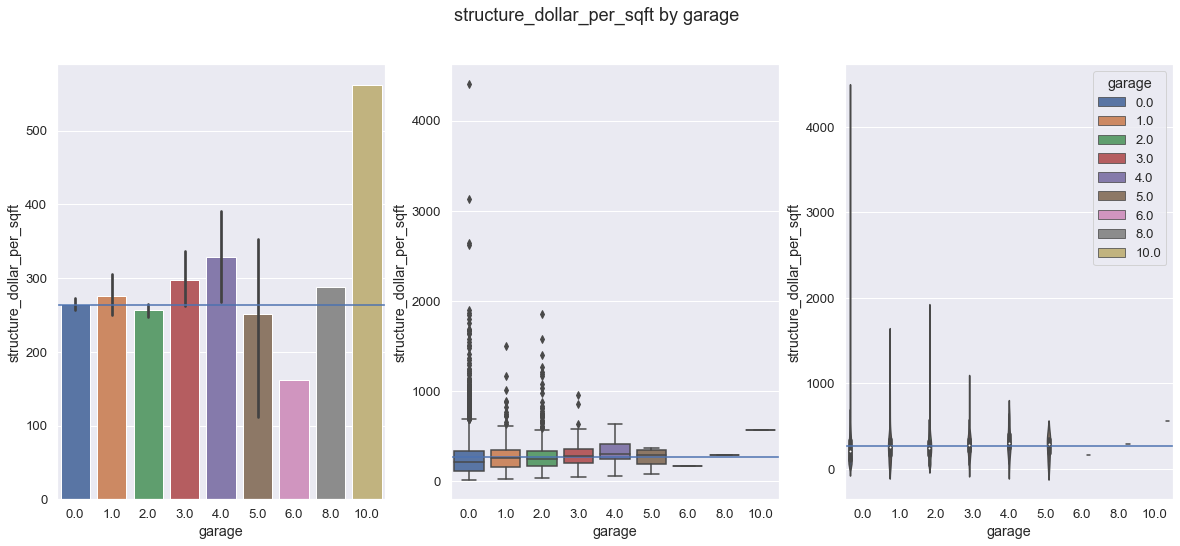

Generating plots structure_dollar_per_sqft by county


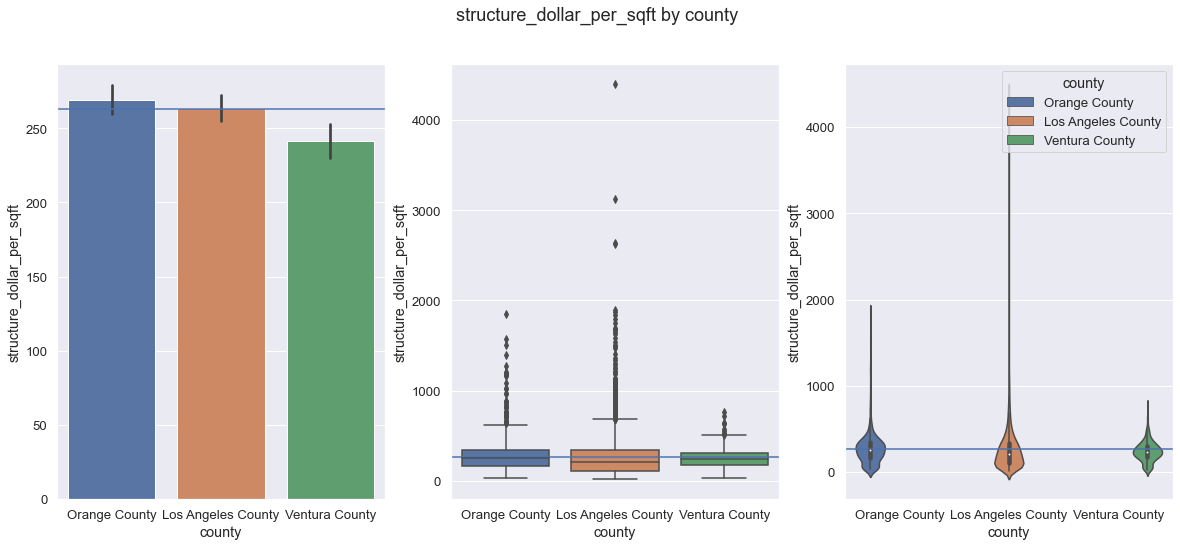

Generating plots structure_dollar_per_sqft by bathroom_bin


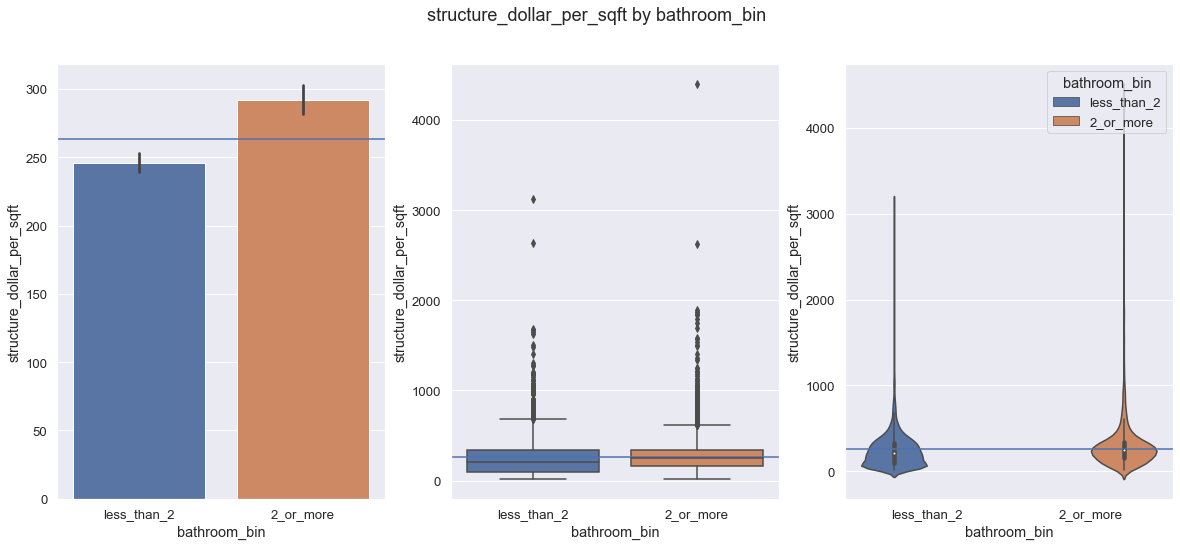

Generating plots structure_dollar_per_sqft by bedroom_bin


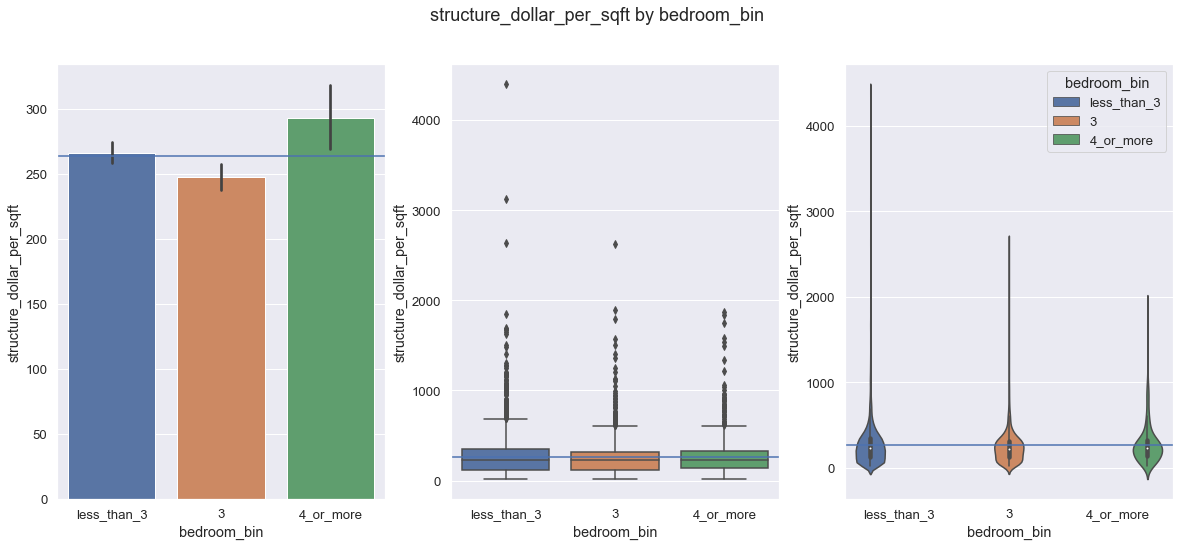

Generating plots structure_dollar_per_sqft by age_bin


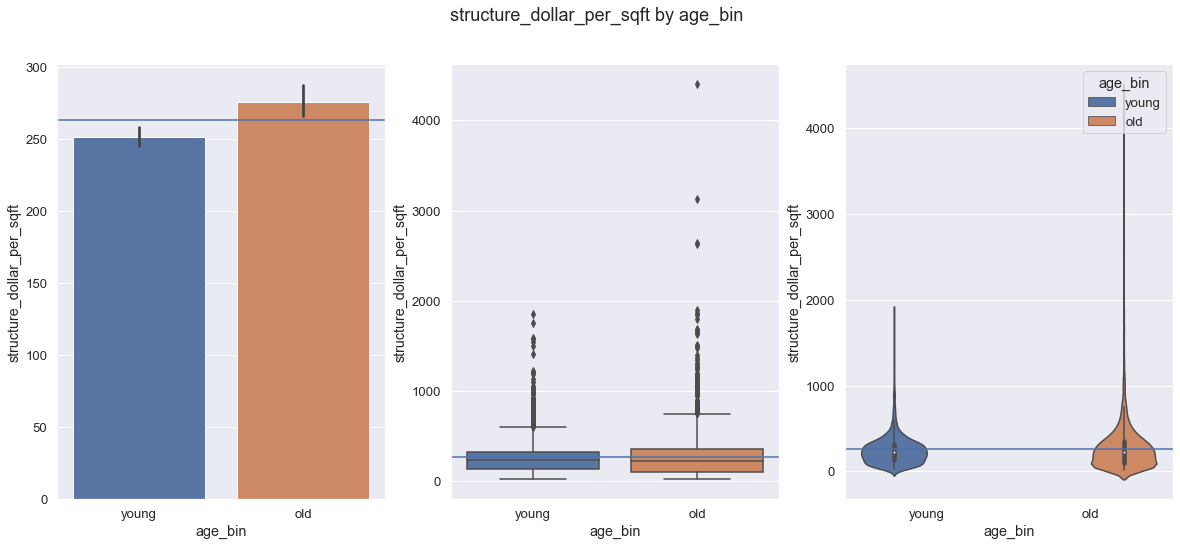

Generating plots structure_dollar_per_sqft by is_la


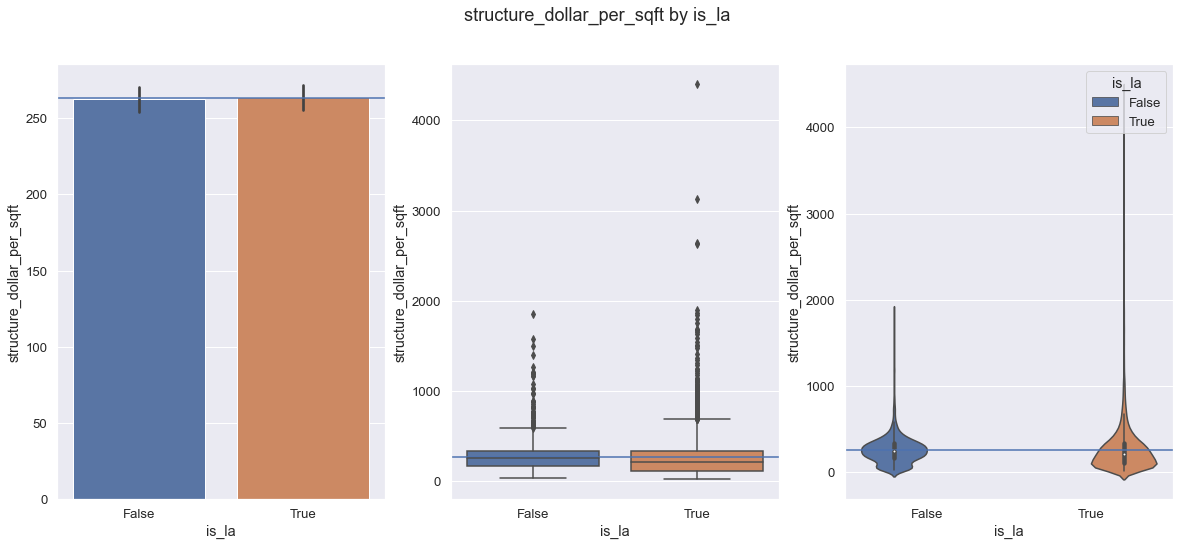

Generating plots land_dollar_per_sqft by bedroom


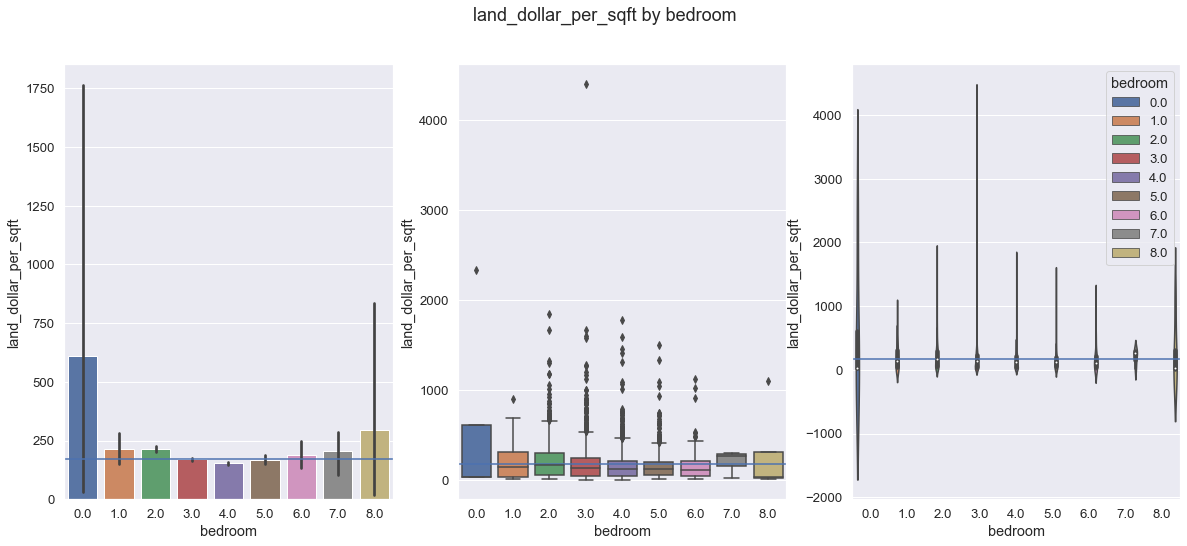

Generating plots land_dollar_per_sqft by bathroom


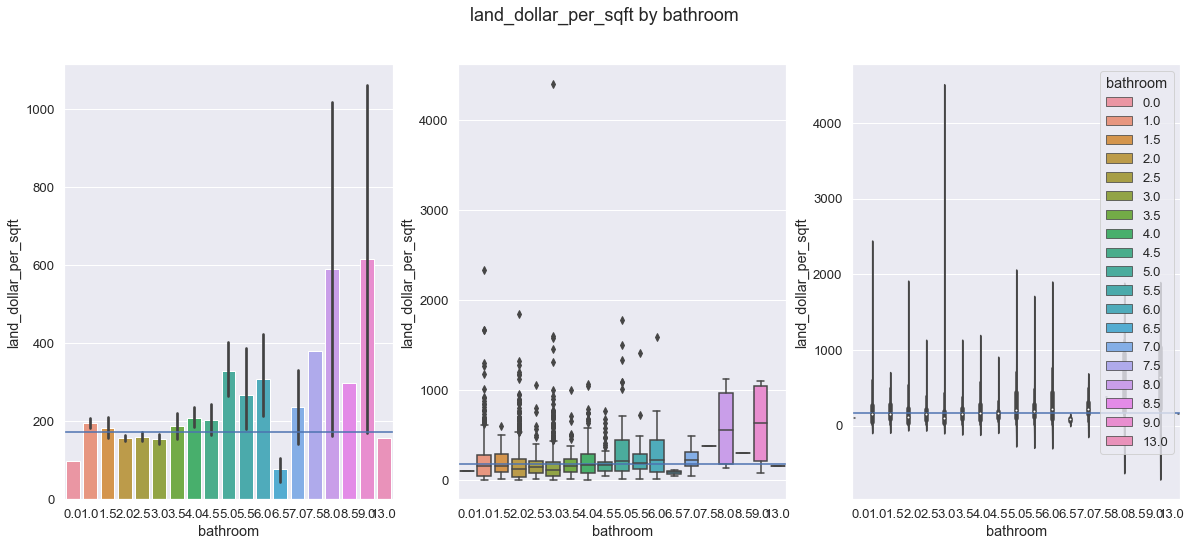

Generating plots land_dollar_per_sqft by condition


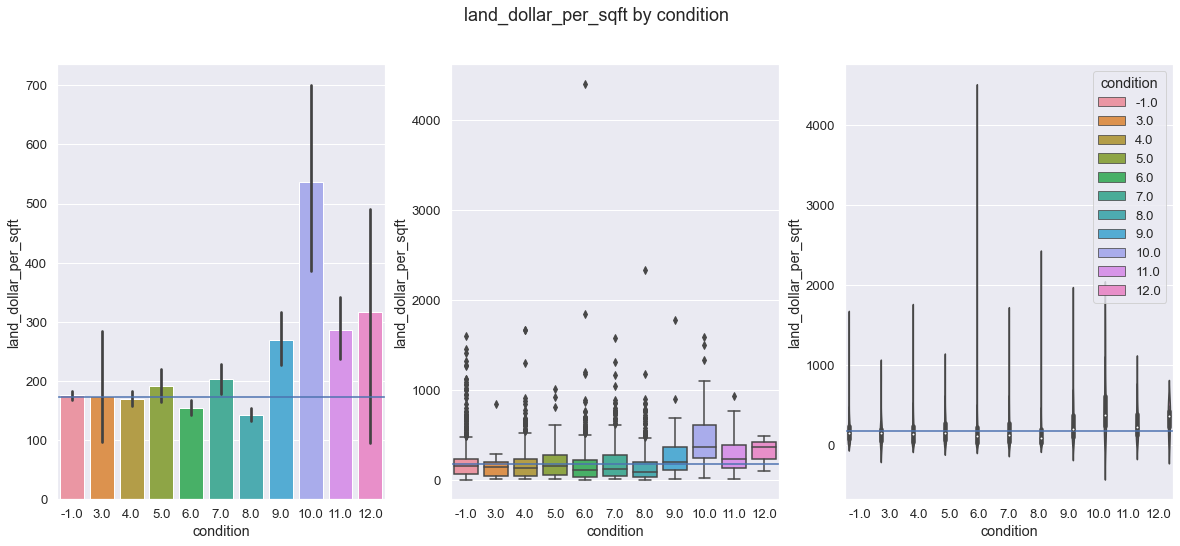

Generating plots land_dollar_per_sqft by fips


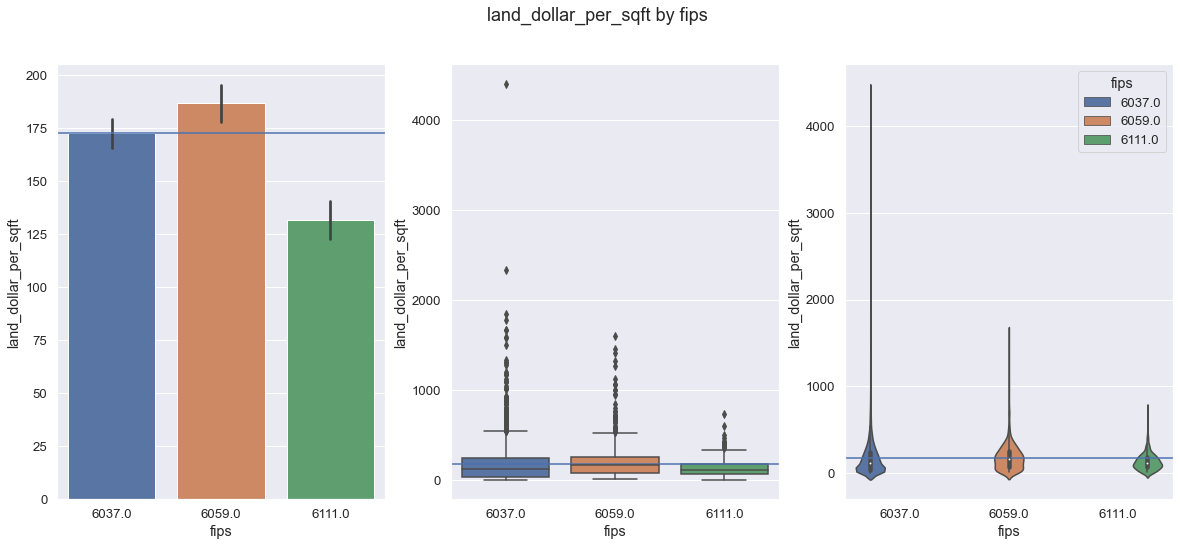

Generating plots land_dollar_per_sqft by fireplacecnt


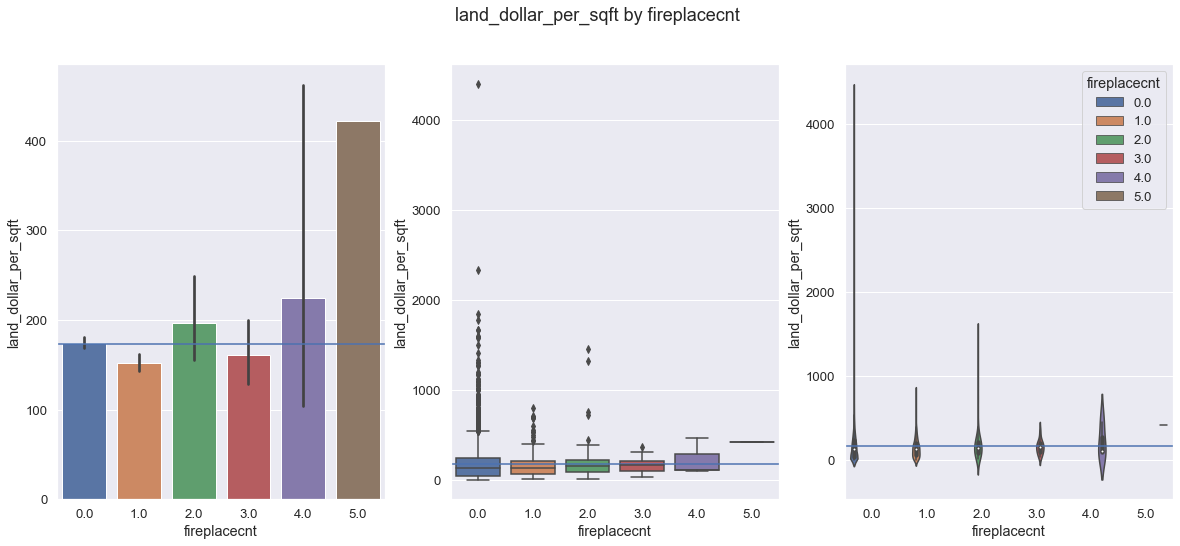

Generating plots land_dollar_per_sqft by fullbathcnt


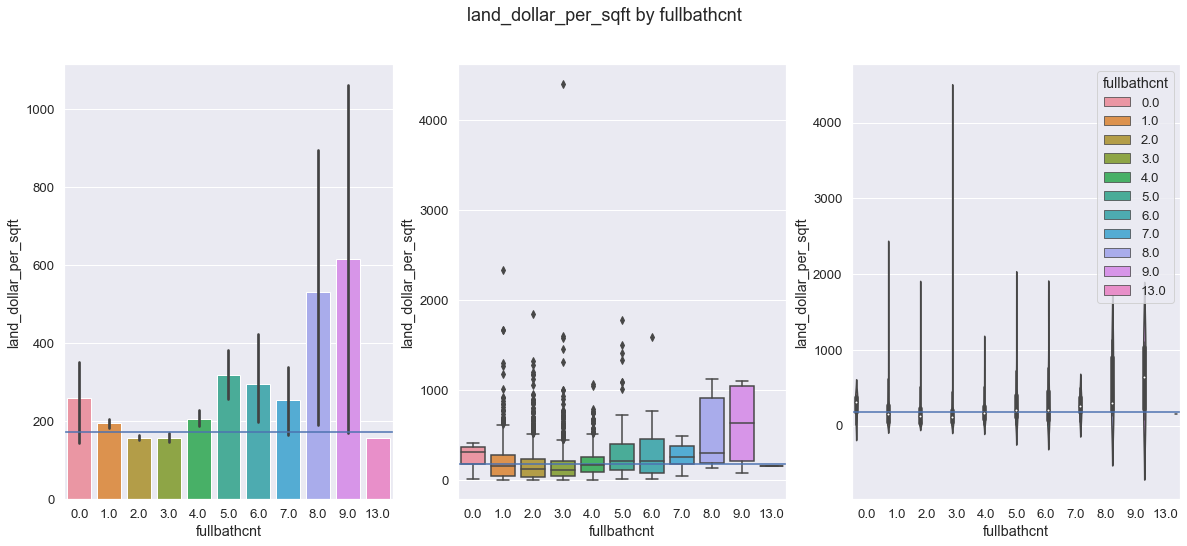

Generating plots land_dollar_per_sqft by garage


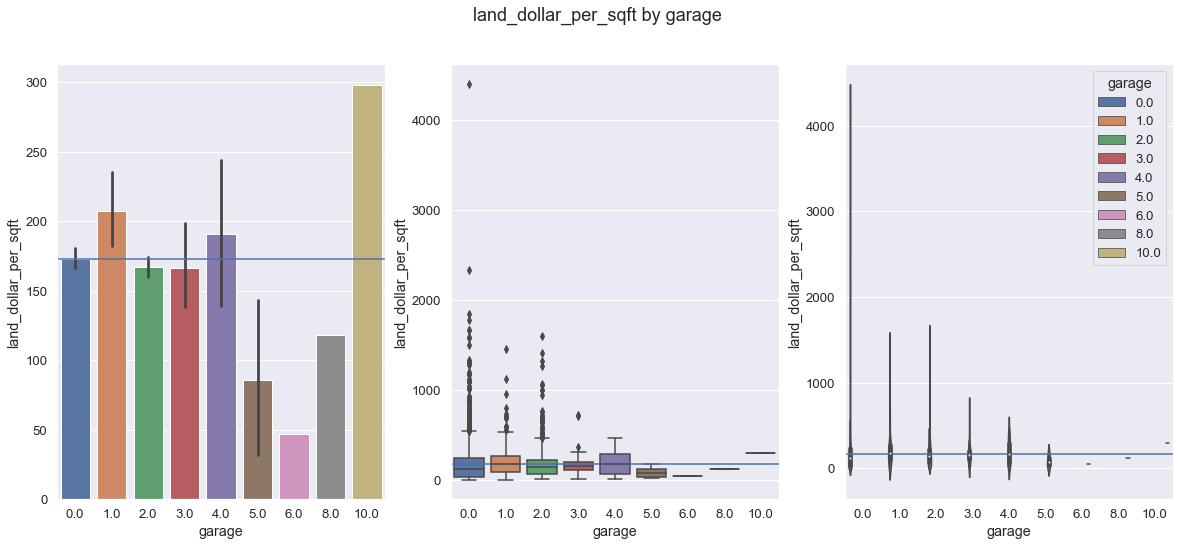

Generating plots land_dollar_per_sqft by county


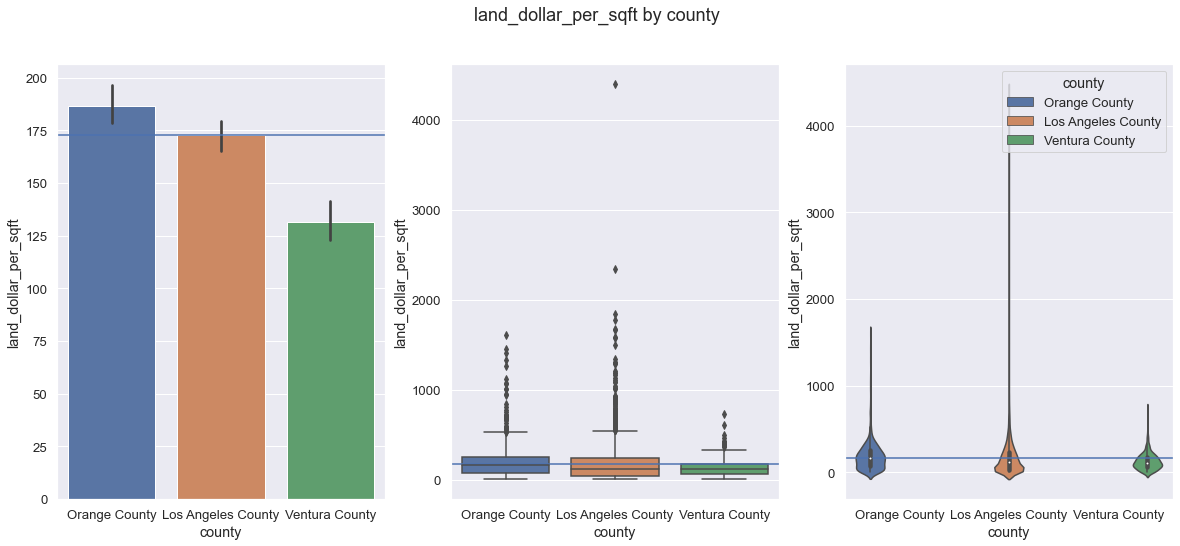

Generating plots land_dollar_per_sqft by bathroom_bin


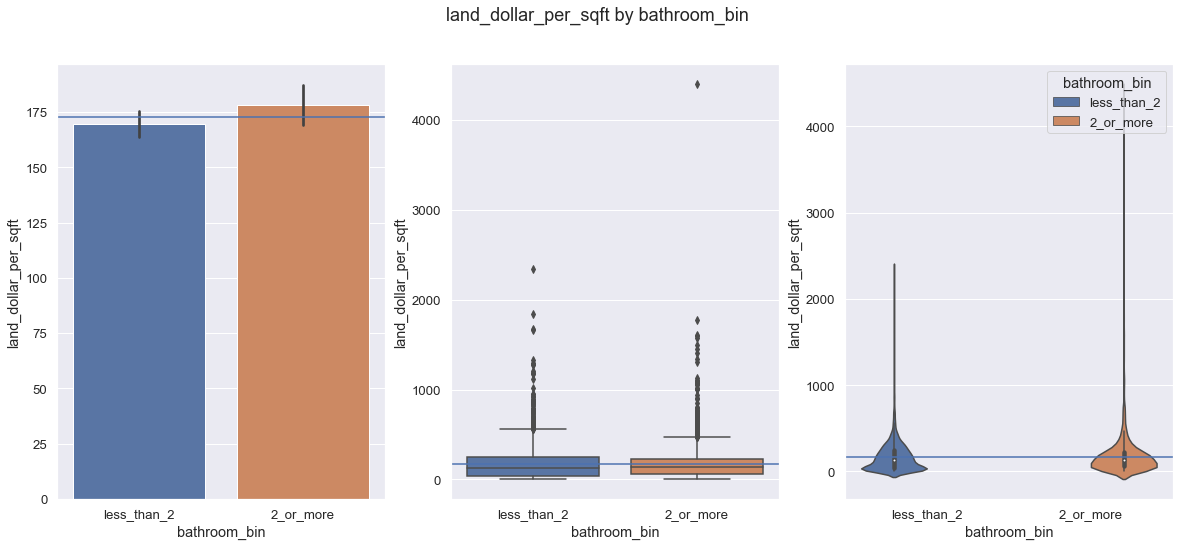

Generating plots land_dollar_per_sqft by bedroom_bin


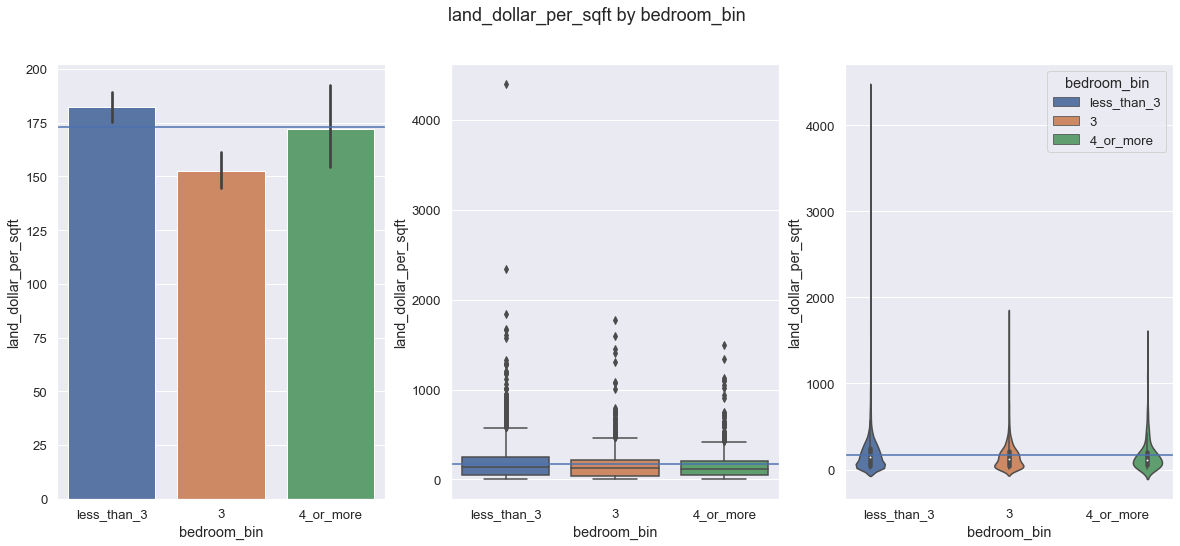

Generating plots land_dollar_per_sqft by age_bin


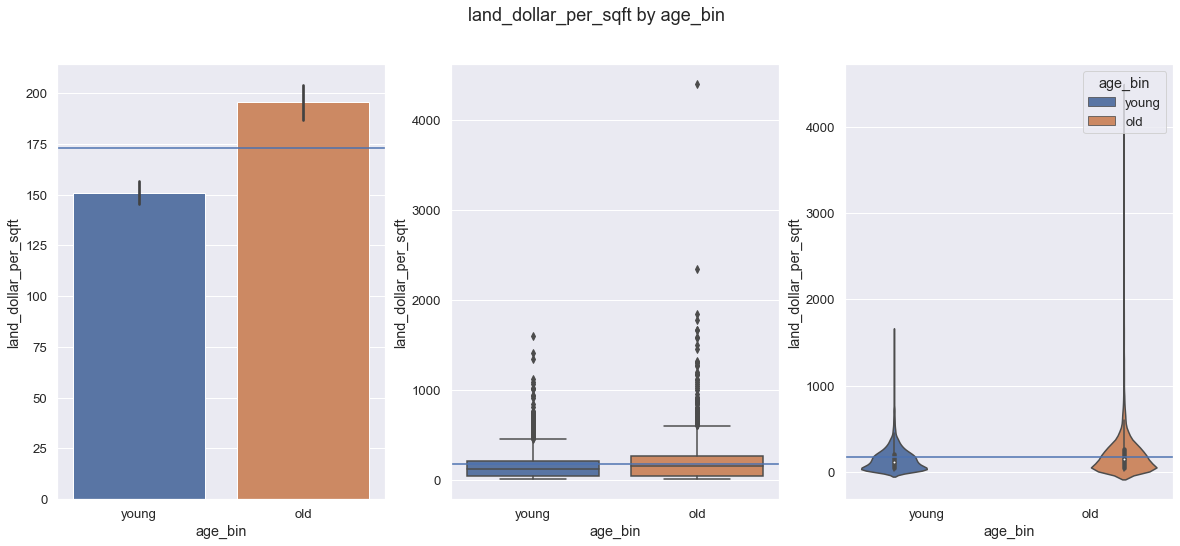

Generating plots land_dollar_per_sqft by is_la


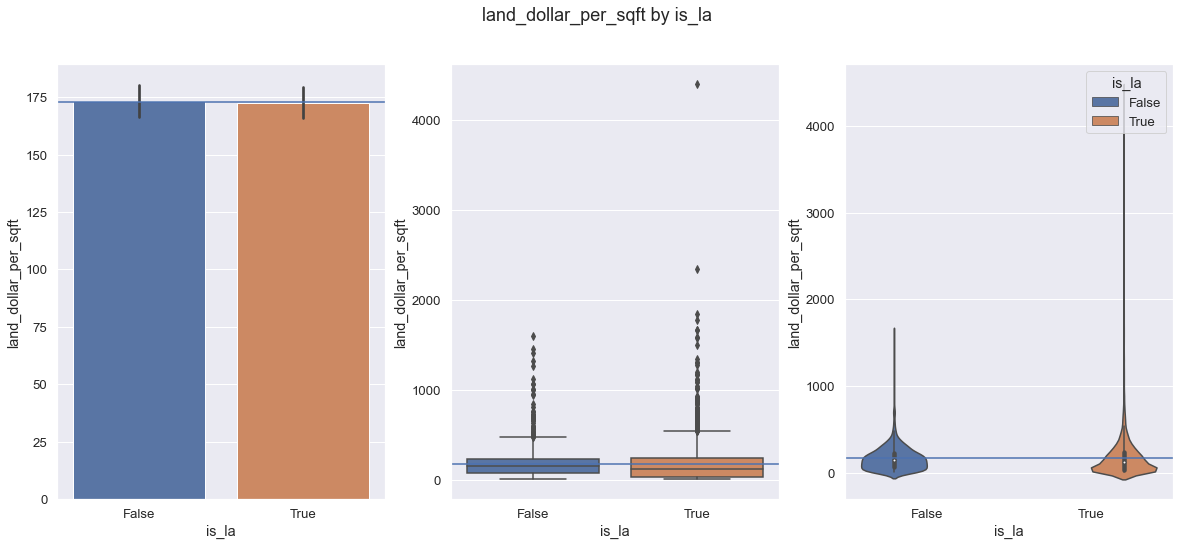

In [48]:
explore.plot_categorical_and_continuous_vars(train, categorical, continuous, sample_amt=5000)

#### is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

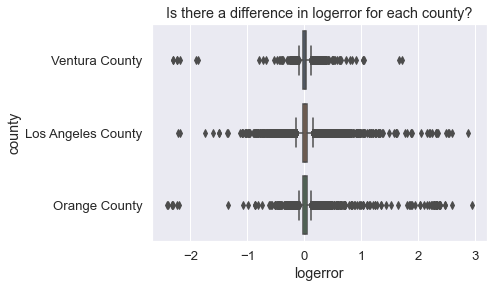

In [53]:
sns.boxplot(train.logerror, train.county)
plt.title("Is there a difference in logerror for each county?")
plt.show()

#### Question 2:
Is there a relationship between logerror and zipcode?

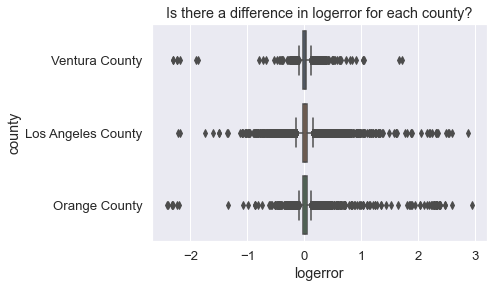

In [54]:
sns.boxplot(train.logerror, train.county)
plt.title("Is there a difference in logerror for each county?")
plt.show()

##### Based on t-test results the highest positive error differences were with:

- bedroom bin - 4 or more
- threequarterbathnbr - 1.0
- Orange county
- heatingsystem - Not specified
##### Highest negative error differences:



- Is log error significantly different for properties in different counties?

In [55]:
#ANOVA and/or T-test
ventura_properties = train[train.county == 'Ventura County'].logerror
la_properties = train[train.county == 'Los Angeles County'].logerror
orange_properties = train[train.county == 'Orange County'].logerror

- H
0
: log error means are all equal between each county
- H
a
: means are not equal to each other


In [56]:
ventura_properties.var(), la_properties.var(), orange_properties.var()

(0.02640727357180353, 0.02601732494807998, 0.04287695019874075)

In [57]:
print("can reject null hypothesis, there is a difference between the population medians: ", p<alpha)
stats.levene(ventura_properties, la_properties, orange_properties)

can reject null hypothesis, there is a difference between the population medians:  True


LeveneResult(statistic=14.350513208349438, pvalue=5.899117144829073e-07)

In [62]:
county_data = {'ventura': ventura_properties.median(),
               'la': la_properties.median(),
               'orange':orange_properties.median()}

In [60]:
# Variances are unequal
# Greater than 30 samples, approximately normal distribution
f, p = stats.kruskal(ventura_properties, la_properties, orange_properties)
print("Can reject null hypothesis, there is a difference between the population medians: ", p<alpha)

Can reject null hypothesis, there is a difference between the population medians:  True


Text(0.5, 1.0, 'Median Log Error by County. Red Line Shows Median for all Properties')

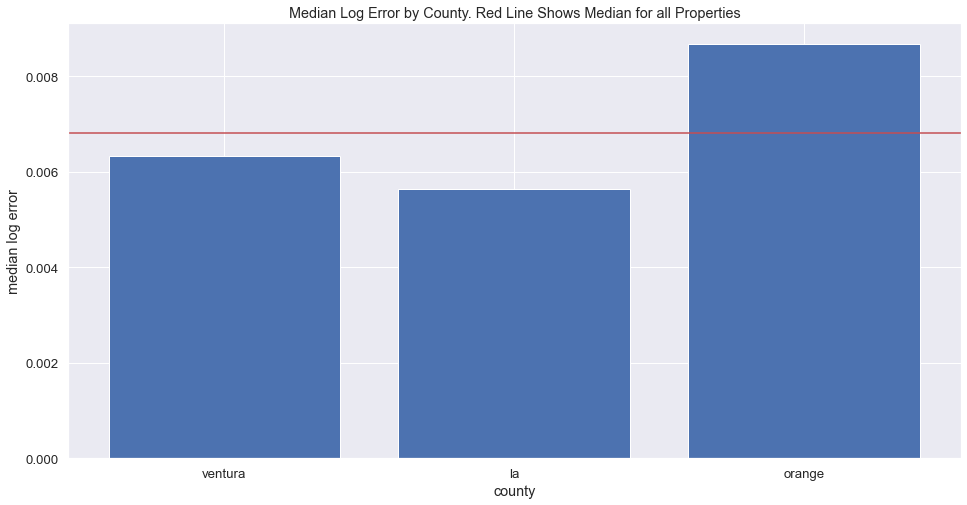

In [63]:
plt.figure(figsize=(16,8))
plt.bar(county_data.keys(), county_data.values())
plt.xlabel('county')
plt.ylabel('median log error')
plt.axhline(train.logerror.median(),color='r')
plt.title("Median Log Error by County. Red Line Shows Median for all Properties")

In [66]:
#Look at numeric features vs target for continuous variables
combos = combinations(['logerror','square_feet','garagetotalsqft','lot_size', 'tax_value','age', 'living_space','acres','structure_dollar_per_sqft', 'land_dollar_per_sqft'],2)
for pair in combos:
    h0 = f'There is no linear correlation between {pair[0]}  and {pair[1]} of a property'
    corr, p = stats.pearsonr(train[pair[0]],train[pair[1]])
    #use default alpha of .05
    explore.stats_result(p,h0,corr=corr)


H₀: There is no linear correlation between logerror  and square_feet of a property
We reject the null hypothesis, p = 3.85215452375176e-10 | α = 0.05
  corr: 0.03706545213660555

H₀: There is no linear correlation between logerror  and garagetotalsqft of a property
We reject the null hypothesis, p = 1.260710371408567e-05 | α = 0.05
  corr: 0.02586087000706562

H₀: There is no linear correlation between logerror  and lot_size of a property
We failed to reject the null hypothesis, p = 0.14459784517699595 | α = 0.05
  corr: 0.008640973739164247

H₀: There is no linear correlation between logerror  and tax_value of a property
We failed to reject the null hypothesis, p = 0.10146259113134053 | α = 0.05
  corr: -0.009700689611708934

H₀: There is no linear correlation between logerror  and age of a property
We reject the null hypothesis, p = 3.144461272970393e-05 | α = 0.05
  corr: -0.02465270523746436

H₀: There is no linear correlation between logerror  and living_space of a property
We re

In [69]:
#Look at numeric features vs target for categorical variables
combos = combinations(['logerror','bedroom', 'bathroom','condition', 'fips','fireplacecnt','fullbathcnt', 'garage'],2)
for pair in combos:
    h0 = f'There is no linear correlation between {pair[0]}  and {pair[1]} of a property'
    corr, p = stats.pearsonr(train[pair[0]],train[pair[1]])
    #use default alpha of .05
    explore.stats_result(p,h0,corr=corr)


H₀: There is no linear correlation between logerror  and bedroom of a property
We reject the null hypothesis, p = 1.2789481308365157e-09 | α = 0.05
  corr: 0.035941868337806396

H₀: There is no linear correlation between logerror  and bathroom of a property
We reject the null hypothesis, p = 2.2661774332537828e-08 | α = 0.05
  corr: 0.03310324370481055

H₀: There is no linear correlation between logerror  and condition of a property
We reject the null hypothesis, p = 1.215488880902465e-05 | α = 0.05
  corr: -0.02590808505695543

H₀: There is no linear correlation between logerror  and fips of a property
We failed to reject the null hypothesis, p = 0.3975216330431726 | α = 0.05
  corr: 0.00501126269641673

H₀: There is no linear correlation between logerror  and fireplacecnt of a property
We failed to reject the null hypothesis, p = 0.8297315568837822 | α = 0.05
  corr: 0.001273743063815153

H₀: There is no linear correlation between logerror  and fullbathcnt of a property
We reject th

In [70]:
t, p = stats.ttest_ind(ventura_properties, la_properties, equal_var=False)
print("Ventura and LA logerror means differ significantly: ",p<alpha)

Ventura and LA logerror means differ significantly:  False


##### Ventura and LA are fairly close (not significantly different) while Orange is significantly different from the other two counties in terms of mean log error.

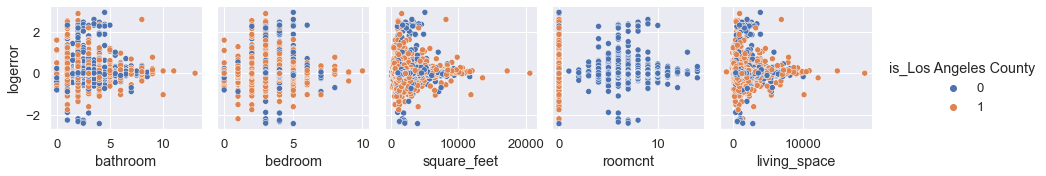

In [71]:
county_train = pd.get_dummies(train, columns = ['county'],prefix = 'is')

sns.pairplot(x_vars=['bathroom','bedroom','square_feet','roomcnt', 'living_space'], y_vars='logerror', data=county_train, hue='is_Los Angeles County')

<AxesSubplot:xlabel='roomcnt', ylabel='logerror'>

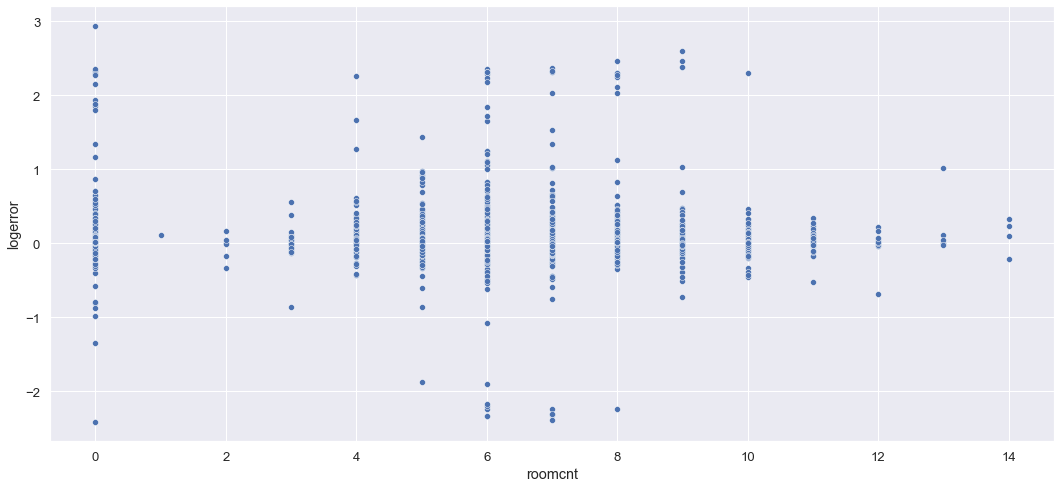

In [72]:
# Looking at roomcnt vs logerror - doesn't look like any data for LA county but for the other counties there appear to be some high and lower clusters of log error

not_la = county_train[county_train["is_Los Angeles County"]==0]

plt.figure(figsize=(18,8))
sns.scatterplot(data = not_la, x='roomcnt', y = 'logerror')

<AxesSubplot:xlabel='roomcnt', ylabel='logerror'>

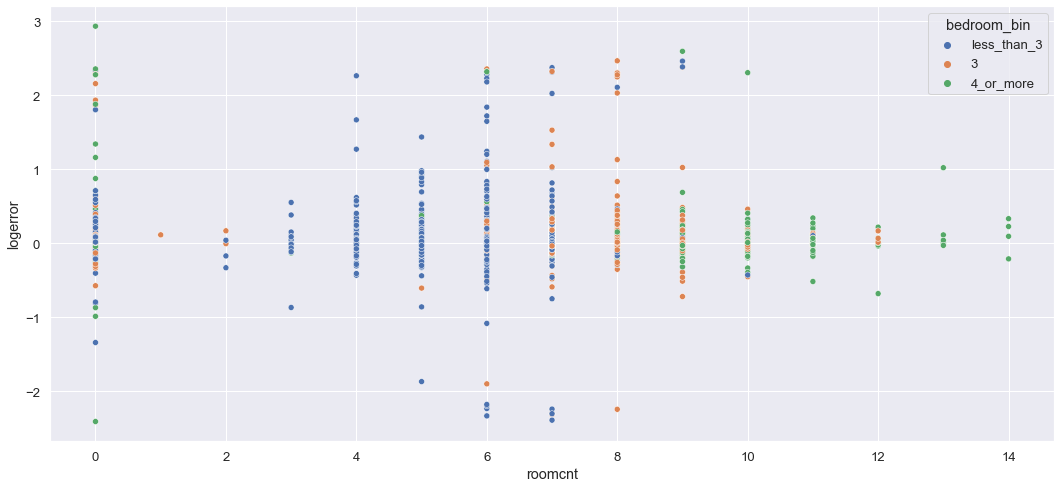

In [73]:
plt.figure(figsize=(18,8))
sns.scatterplot(data = not_la, x='roomcnt', y = 'logerror', hue = 'bedroom_bin')

In [74]:
# How does log error change with square footage

r, p = stats.pearsonr(train.square_feet, train.logerror)
print(f"Correlation of {r} is significant: {p<alpha}")
print("This is a very weak correlation")

Correlation of 0.03706545213660555 is significant: True
This is a very weak correlation


<AxesSubplot:xlabel='square_feet', ylabel='logerror'>

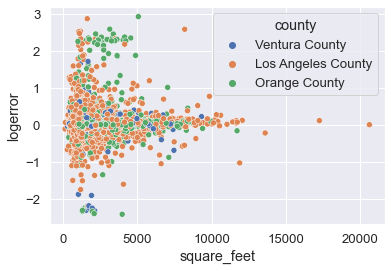

In [97]:
sns.scatterplot(data = train, x = 'square_feet', y = 'logerror', hue = 'county')

#### How does # bathrooms correlate with logerror if bedrooms count constant?

In [77]:
# Correlation test
print("Log error to Bathroom count correlation, holding bedroom count constant")
print("------")
for bed in train.bedroom.unique():
    bedroom_sample = train[train.bedroom == bed]
    # Check if actually values in the sample to allow for correlation test
    if len(bedroom_sample)>1:
        r, p = stats.pearsonr(bedroom_sample.bathroom, bedroom_sample.logerror)
        print(f"For {bed} bedrooms, correlation of {r} is significant: {p<alpha}")
        if p<alpha:
            if r<0.3 and r>-0.3:
                print("This is a very weak correlation")

Log error to Bathroom count correlation, holding bedroom count constant
------
For 3.0 bedrooms, correlation of 0.0031090471436558543 is significant: False
For 2.0 bedrooms, correlation of -0.012194951222318352 is significant: False
For 4.0 bedrooms, correlation of 0.01780049291430726 is significant: False
For 5.0 bedrooms, correlation of 0.060361772246668485 is significant: True
This is a very weak correlation
For 1.0 bedrooms, correlation of -0.05460323208145075 is significant: False
For 6.0 bedrooms, correlation of 0.0586600567310378 is significant: False
For 7.0 bedrooms, correlation of -0.2217630951753906 is significant: False
For 8.0 bedrooms, correlation of 0.2924469401706446 is significant: False
For 0.0 bedrooms, correlation of -0.1272152908576515 is significant: False
For 9.0 bedrooms, correlation of -0.8528553929073034 is significant: False


<AxesSubplot:xlabel='bathroom', ylabel='logerror'>

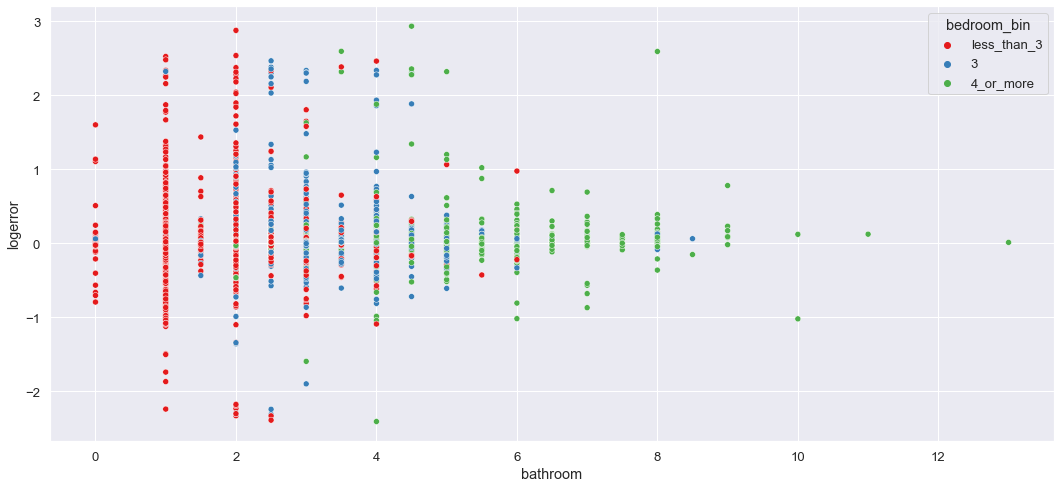

In [78]:
plt.figure(figsize=(18,8))
sns.scatterplot(data = train, hue = 'bedroom_bin', x='bathroom', y='logerror', palette='Set1')

# Bedrooms?

In [79]:
r, p = stats.pearsonr(train.bedroom, train.logerror)
print(f"Correlation of {r} is significant: {p<alpha}")
print("This is a very weak correlation")


Correlation of 0.035941868337806396 is significant: True
This is a very weak correlation


In [81]:
bedroom_data = {k:0 for k in train.bedroom_bin.unique()}
for bed_bin in train.bedroom_bin.unique():
    
    bedroom_data[bed_bin] = train[train.bedroom_bin == bed_bin].logerror.mean()


Text(0.5, 1.0, 'Median Log Error by Bedroom Count. Red Line Shows Median for all Properties')

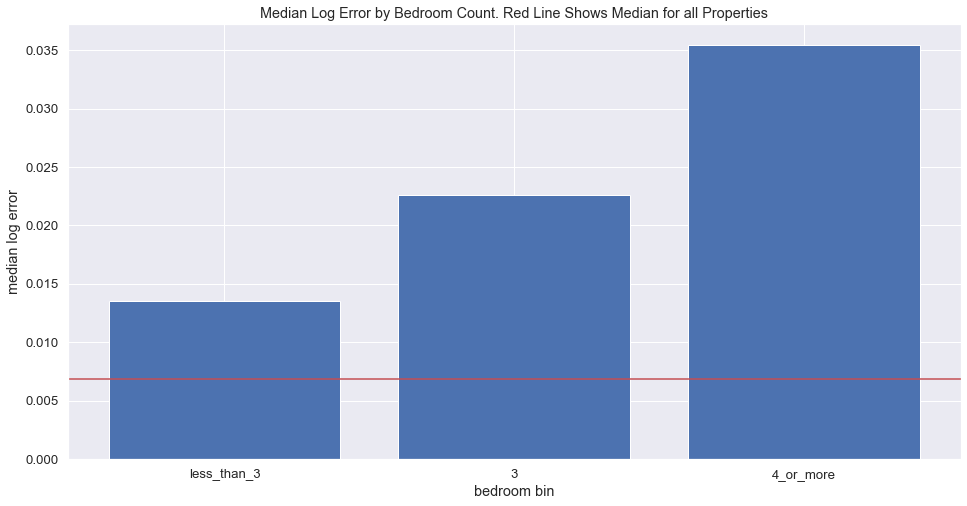

In [82]:
plt.figure(figsize=(16,8))
plt.bar(bedroom_data.keys(), bedroom_data.values())
plt.xlabel('bedroom bin')
plt.ylabel('median log error')
plt.axhline(train.logerror.median(),color='r')
plt.title("Median Log Error by Bedroom Count. Red Line Shows Median for all Properties")

#### How does logerror change with square Footage?

In [99]:
r, p = stats.pearsonr(train.square_feet, train.logerror)
print(f"Correlation of {r} is significant: {p<alpha}")
print("This is a very weak correlation")

Correlation of 0.03706545213660555 is significant: True
This is a very weak correlation


<AxesSubplot:xlabel='square_feet', ylabel='logerror'>

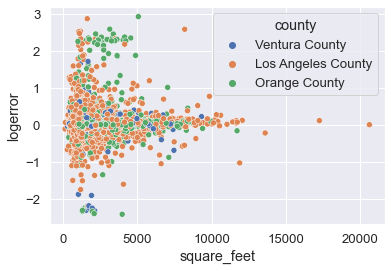

In [100]:
sns.scatterplot(data = train, x = 'square_feet', y = 'logerror', hue='county')


#### Takeaway
-No Correlation

In [101]:
# Same with living space
r, p = stats.pearsonr(train.living_space, train.logerror)
print(f"Correlation of {r} is significant: {p<alpha}")
print("This is a very weak correlation")

Correlation of 0.033667425259480556 is significant: True
This is a very weak correlation


#### Garages have logerrors?

In [102]:
with_garage = train[train.has_garage].logerror
without_garage = train[~train.has_garage].logerror

In [103]:
with_garage.var(), without_garage.var()

(0.03739316995581872, 0.02704537746190941)

In [104]:
stats.levene(with_garage, without_garage)


LeveneResult(statistic=38.8499878991891, pvalue=4.6406239350179917e-10)

<BarContainer object of 2 artists>

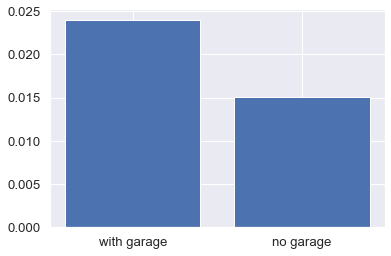

In [105]:
# Unequal variances
plt.bar(['with garage', 'no garage'],[with_garage.mean(), without_garage.mean()])

In [106]:
t,p = stats.ttest_ind(with_garage, without_garage, equal_var=False)
if (t>0) and (p/2<alpha):
    print("Reject null: mean of logerror for with garage is greater than for those without garage")

Reject null: mean of logerror for with garage is greater than for those without garage


<AxesSubplot:xlabel='garage', ylabel='logerror'>

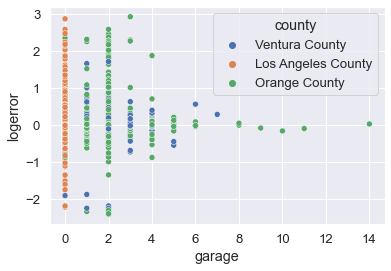

In [108]:
sns.scatterplot(data = train, x = 'garage', y = 'logerror', hue='county')


In [109]:
r, p = stats.pearsonr(train.square_feet, train.logerror)
print(f"Correlation of {r} is significant: {p<alpha}")
print("This is a very weak correlation")

Correlation of 0.03706545213660555 is significant: True
This is a very weak correlation


In [110]:
train.numberofstories.value_counts()

0.00    20501
1.00     4843
2.00     2973
3.00      189
Name: numberofstories, dtype: int64

<AxesSubplot:xlabel='numberofstories', ylabel='logerror'>

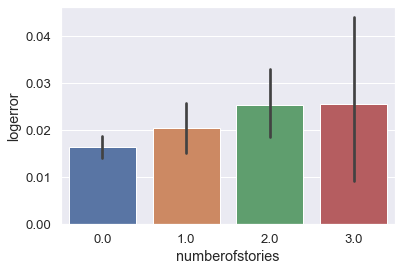

In [111]:
# Number of stories? 
sns.barplot(data = train, x = 'numberofstories', y = 'logerror')

<AxesSubplot:xlabel='airconditioningdesc', ylabel='logerror'>

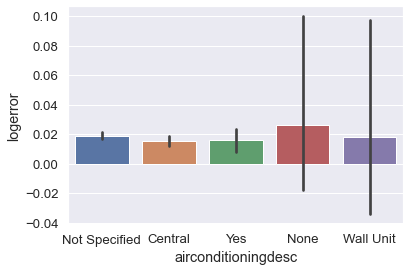

In [113]:
# Air Conditioning?
sns.barplot(data = train, x = 'airconditioningdesc', y ='logerror')

<AxesSubplot:xlabel='age', ylabel='logerror'>

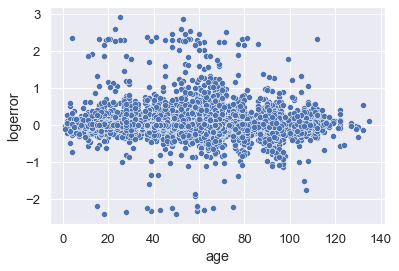

In [116]:
sns.scatterplot(data = train, x = 'age',y = 'logerror')

<AxesSubplot:xlabel='age', ylabel='logerror'>

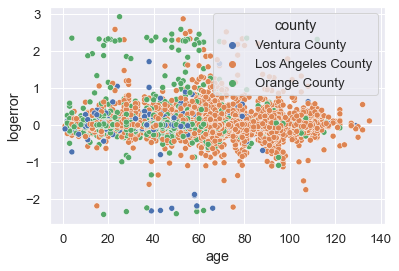

In [117]:
sns.scatterplot(data = train, x = 'age',y = 'logerror', hue = 'county')

<AxesSubplot:xlabel='age', ylabel='logerror'>

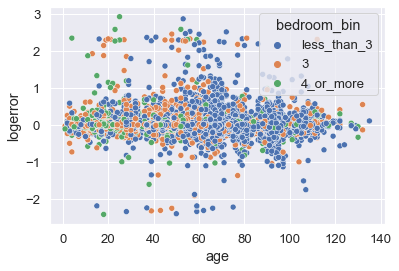

In [118]:
sns.scatterplot(data = train, x = 'age',y = 'logerror', hue = 'bedroom_bin')

### Region?

In [119]:
def is_error_above_threshold(regionidcity, threshold):
    return (train.groupby('regionidcity').logerror.agg('mean')>threshold).loc[regionidcity]


In [120]:
train["logerror_above_threshold"]=train.apply(lambda row: is_error_above_threshold(row.regionidcity, 0.1), axis=1)

In [121]:
train[train.logerror_above_threshold].regionidcity.value_counts()

118,994.00    39
 36,502.00    22
 25,468.00    16
 32,753.00     6
  3,491.00     4
 13,311.00     2
Name: regionidcity, dtype: int64

<AxesSubplot:xlabel='regionidcity', ylabel='logerror'>

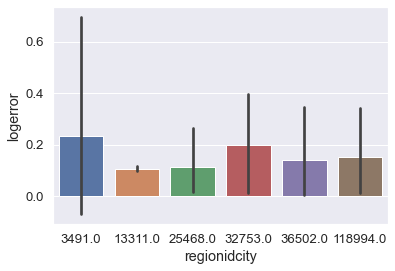

In [122]:
sns.barplot(data = train[train.logerror_above_threshold],  x='regionidcity',y='logerror')

#### Significance of region city above threshold?

In [123]:
regionidcitymeans=[]
ps=[]
num_samples=[]
cities = []
for city in train.regionidcity.unique():
    regionidcitymean = train[train.regionidcity == city].logerror.mean()
    t, p = stats.ttest_1samp(train[train.regionidcity == city].logerror, train.logerror.mean())
    if p<alpha:
        print(city, "City's mean logerror: ",round(regionidcitymean,4), "vs average", 
              round(train.logerror.mean(),4), "Significant?",p<alpha,
             ",number of samples: ",len(train[train.regionidcity == city]))
    regionidcitymeans.append(regionidcitymean)
    ps.append(p)
    num_samples.append(len(train[train.regionidcity == city]))
    cities.append(city)

results = pd.DataFrame(data = {'city':cities,'city_mean':regionidcitymeans, 'p_value':ps, 'number_of_samples':num_samples})
results["significant"]=results.p_value<0.05
results["overall_mean"] = train.logerror.mean()
results["city_vs_overall"] = results.city_mean - results.overall_mean
cities.append(city)

12447.0 City's mean logerror:  0.0073 vs average 0.0181 Significant? True ,number of samples:  6361
33612.0 City's mean logerror:  -0.0085 vs average 0.0181 Significant? True ,number of samples:  149
46298.0 City's mean logerror:  0.0059 vs average 0.0181 Significant? True ,number of samples:  808
29189.0 City's mean logerror:  -0.0178 vs average 0.0181 Significant? True ,number of samples:  55
10241.0 City's mean logerror:  0.0408 vs average 0.0181 Significant? True ,number of samples:  80
52650.0 City's mean logerror:  0.0421 vs average 0.0181 Significant? True ,number of samples:  414
19177.0 City's mean logerror:  -0.0157 vs average 0.0181 Significant? True ,number of samples:  153
27110.0 City's mean logerror:  0.009 vs average 0.0181 Significant? True ,number of samples:  477
25974.0 City's mean logerror:  0.0092 vs average 0.0181 Significant? True ,number of samples:  139
5465.0 City's mean logerror:  0.0001 vs average 0.0181 Significant? True ,number of samples:  114
26483.0 Ci